# Imports

In [1]:
DEF_THIRD_START   = 0
DEF_THIRD_END     = 40
MID_THIRD_END     = 80
ATT_THIRD_END     = 120
PITCH_WIDTH_START = 0
PITCH_WIDTH_END   = 80
DEF_ACTIONS = ['Ball Recovery', 'Duel', 'Block', 'Clearance', 'Interception', 'Pressure', 'Foul Committed']

import os.path
import pandas.io.json
from statsbombpy import sb
import pandas as pd
import numpy as np
import warnings
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Adjust cells' width
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Functions

In [17]:
def getEvents(matchId):
    
    '''
    Get available events and format locations coordinates
    '''
    
    matchEvents = sb.events(matchId)

    # Explode Location, Pass/Carry/Shot End Location to relevant Dimension Column
    matchEvents[['locationX', 'locationY']] = matchEvents.location.apply(pd.Series)
    matchEvents[['passEndLocationX', 'passEndLocationY']] = matchEvents.pass_end_location.apply(pd.Series)
    matchEvents[['carryEndLocationX', 'carryEndLocationY']] = matchEvents.carry_end_location.apply(pd.Series)

    matchEvents.shotEndLocationX, matchEvents.shotEndLocationY, matchEvents.shotEndLocationZ = np.nan, np.nan, np.nan
    endLocations = np.vstack(matchEvents.loc[matchEvents.type == 'Shot', 'shot_end_location'].apply(

    # If shot has 3 or 2 dimensions
    lambda x: x if len(x) == 3 else x + [np.nan]).values)

    matchEvents.loc[matchEvents.type == 'Shot', 'shotEndLocationX'] = endLocations[:, 0]
    matchEvents.loc[matchEvents.type == 'Shot', 'shotEndLocationY'] = endLocations[:, 1]
    matchEvents.loc[matchEvents.type == 'Shot', 'shotEndLocationZ'] = endLocations[:, 2]
    
    # Correct the Y axis mplsoccer mirror issue 
    matchEvents[['locationY']] = 80 - matchEvents[['locationY']]
    
    return matchEvents

In [3]:
def addLocationColumns(matchEvents):
    
    '''
    Adds location columns to df, for each third 
    '''
    
    # Create Boolean columns for 1st, 2nd and 3rd 1/3s of the pitch
    matchEvents['isDefThird'], matchEvents['isMidThird'], matchEvents['isAttThird'] = ((matchEvents.locationX > DEF_THIRD_START) & (matchEvents.locationX <= DEF_THIRD_END)),\
                                                                                      ((matchEvents.locationX > DEF_THIRD_END) & (matchEvents.locationX <= MID_THIRD_END)),\
                                                                                      ((matchEvents.locationX > MID_THIRD_END) & (matchEvents.locationX <= ATT_THIRD_END))

In [4]:
def addTimeColumns(matchEvents):
    
    '''
    Adds time columns to df, for each 15 minute period
    '''
    
    # Create boolean columns for 15-minute periods of time in match - Ignore extra-time (for now...)
    matchEvents['0to15'], matchEvents['15to30'], matchEvents['30to45'], matchEvents['45to60'], matchEvents['60to75'], matchEvents['75to90'] = ((0 <= matchEvents.minute) & (matchEvents.minute < 15)),\
                                                                                                                                              ((15 <= matchEvents.minute) & (matchEvents.minute < 30)),\
                                                                                                                                              ((30 <= matchEvents.minute) & (matchEvents.minute < 45)),\
                                                                                                                                              ((45 <= matchEvents.minute) & (matchEvents.minute < 60)),\
                                                                                                                                              ((60 <= matchEvents.minute) & (matchEvents.minute < 75)),\
                                                                                                                                              ((75 < matchEvents.minute) & (matchEvents.period < 3))    

In [5]:
def whereCount(matchEvents):
    
    '''
    Counts number of times actions happened in each third
    Returns 3 values - defensive, middle, and attacking thirds counters
    '''
    
    # Adds Location columns to df, for each third 
    addLocationColumns(matchEvents)

    # Set the where counters
    defCnt, midCnt, attCnt = 0,0,0
    
    # Use a loop to plot and count each press
    for i in range(matchEvents.locationX.count()):
    
        # Location ifs
        # Defensive third
        if matchEvents['isDefThird'].iloc[i]:
            defCnt += 1

        # Middle third
        elif matchEvents['isMidThird'].iloc[i]:
            midCnt += 1

        # Attacking third
        elif matchEvents['isAttThird'].iloc[i]:
            attCnt += 1
    
    return defCnt, midCnt, attCnt

In [6]:
def whenCountAndPlot(matchEvents):
    
    '''
    Counts number of times action happened in 15 minute period
    Scatter the action in the vizz
    Returns 8 values - defensive, middle, and attacking thirds counters
    '''
    
    # Adds Time columns to df, for each 15 minute period
    addTimeColumns(matchEvents)
    
    # Set the when counters
    cnt0to15, cnt15to30, cnt30to45, cnt45to60, cnt60to75, cnt75to90, cntHalf1, cntHalf2 = 0, 0, 0, 0, 0, 0, 0, 0
    
    # Use a loop to plot and count each press
    for i in range(matchEvents.locationX.count()):
        
        # Time ifs
        # Timeframe 1 - 0to15
        if matchEvents['0to15'].iloc[i]: 
            cnt0to15+=1
            plt.scatter(matchEvents['locationX'].iloc[i], matchEvents['locationY'].iloc[i], color='red')

        # Timeframe 2 - 15to30
        elif matchEvents['15to30'].iloc[i]:
            cnt15to30+=1
            plt.scatter(matchEvents['locationX'].iloc[i], matchEvents['locationY'].iloc[i], color='orange')

        # Timeframe 3 - 30to45
        elif matchEvents['30to45'].iloc[i]: 
            cnt30to45+=1
            plt.scatter(matchEvents['locationX'].iloc[i], matchEvents['locationY'].iloc[i], color='fuchsia')

        # Timeframe 4+5+6 - 45to60
        elif matchEvents['45to60'].iloc[i]:
            cnt45to60+=1
            plt.scatter(matchEvents['locationX'].iloc[i], matchEvents['locationY'].iloc[i], color='cyan')

        # Timeframe 5 - 60to75
        elif matchEvents['60to75'].iloc[i]: 
            cnt60to75+=1
            plt.scatter(matchEvents['locationX'].iloc[i], matchEvents['locationY'].iloc[i], color='dodgerblue')

        # Timeframe 6 - 75to90
        elif matchEvents['75to90'].iloc[i]:
            cnt75to90+=1
            plt.scatter(matchEvents['locationX'].iloc[i], matchEvents['locationY'].iloc[i], color='yellow')
    
    # Calculate first and second half counters
    cntHalf1 = cnt0to15 + cnt15to30 + cnt30to45
    cntHalf2 = cnt45to60 + cnt60to75 + cnt75to90
    
    return cnt0to15, cnt15to30, cnt30to45, cnt45to60, cnt60to75, cnt75to90, cntHalf1, cntHalf2

In [7]:
def extractOppName(matchEvents, notTheTeam):
    
    '''
    Extract the name of the opposition of notTheTeam
    '''
    
    for teamName in set(matchEvents['team'].values.tolist()):
        if teamName != notTheTeam:
            return teamName

In [8]:
def pressureVizz(matchEvents, team, counterPress=False):
    
    '''
    Plots all pressures of a team 
    '''
    
    # Take only pressure actions of requested team
    prsEvents = matchEvents[(matchEvents.type == 'Pressure') & (matchEvents.team == team)]
    
    # Take Only events of known location
    prsEvents = prsEvents[prsEvents['locationX'].notna()]
    
    # If counterPress was not requested, remove counterpress events - Default
    if not counterPress:
        prsEvents = prsEvents[~(prsEvents.counterpress == True)]
    
    # Plot the df
    fig, ax = plt.subplots(figsize = (13.5, 8))
    fig.set_facecolor('#22312b')
    ax.patch.set_facecolor('#22312b')
    
    ## Create maximun pitch - Can be used *instead* of Create minimal pitch block
    # maxPitch = Pitch(pitch_type = 'statsbomb', orientation = 'horizontal', pitch_color = '#22312b', line_color ='#c7d5cc',
    #               figsize = (13, 8), constrained_layout = False, tight_layout = True)
    # maxPitch.draw(ax = ax)
    # plt.gca().invert_yaxis()

    # Create minimal pitch - Create maximun pitch can be used *instead*
    minPitch = Pitch(pitch_type = 'statsbomb', pitch_color = '#22312b', line_color ='#c7d5cc')
    minPitch.draw(ax = ax)
    plt.gca().invert_yaxis()
    
    # Add thirds to plot
    xFirstDiv, yFirstDiv = [DEF_THIRD_END, DEF_THIRD_END], [PITCH_WIDTH_START, PITCH_WIDTH_END]
    xFinalDiv, yFinalDiv = [MID_THIRD_END, MID_THIRD_END], [PITCH_WIDTH_START, PITCH_WIDTH_END]
    plt.plot(xFirstDiv, yFirstDiv, xFinalDiv, yFinalDiv, color = 'black')

    # Extract where, when and total counters - ignore extra-time (for now...)
    prsDefCnt, prsMidCnt, prsAttCnt = whereCount(prsEvents)
    cnt0to15, cnt15to30, cnt30to45, cnt45to60, cnt60to75, cnt75to90, cntHalf1, cntHalf2 = whenCountAndPlot(prsEvents)
    prsTotalCnt = cntHalf1 + cntHalf2

    # initializing numbers for the location print
    # If some cnt is 0 the calculation will not work - "ValueError: cannot convert float NaN to integer" -> return the 0 as percentage
    try:
        defThirdPercent = int(float(prsDefCnt) / prsTotalCnt * 100)
    except ValueError:
        defThirdPercent = 0
    try:
        midThirdPercent = int(float(prsMidCnt) / prsTotalCnt * 100)
    except ValueError:
        midThirdPercent
    try:
        attThirdPercent = int(float(prsAttCnt) / prsTotalCnt * 100)
    except ValueError:
        attThirdPercent
        
    # Title
    teamName = prsEvents.team.iloc[0]
    oppName = extractOppName(matchEvents, team)
    fig.suptitle(f"Pressing Map - {teamName} vs {oppName}\nTotal number of presses: {prsTotalCnt}", horizontalalignment='center', color='white', fontsize=25)
    
    # Text of location of pressure
    ax.text(8, -8, f"Def 1/3 pressures: {prsDefCnt}\n          {defThirdPercent}%", color='white', fontsize=13)
    ax.text(45, -14, f"Mid 1/3 pressures: {prsMidCnt}\n          {midThirdPercent}%\n\n", color='white', fontsize=13)
    ax.text(85, -8, f"Att 1/3 pressures: {prsAttCnt}\n          {attThirdPercent}%", color='white', fontsize=13)

    # initializing numbers for the time print
    cntHalf1 = cnt0to15 + cnt15to30 + cnt30to45
    cntHalf2 = cnt45to60 + cnt60to75 + cnt75to90
    pcntHalf1 = int(float(cntHalf1) / prsTotalCnt * 100)
    pcntHalf2 = int(float(cntHalf2) / prsTotalCnt * 100)
    pcnt0to15 = int(float(cnt0to15) / prsTotalCnt * 100)
    pcnt15to30 = int(float(cnt15to30) / prsTotalCnt * 100)
    pcnt30to45 = int(float(cnt30to45) / prsTotalCnt * 100)
    pcnt45to60 = int(float(cnt45to60) / prsTotalCnt * 100)
    pcnt60to75 = int(float(cnt60to75) / prsTotalCnt * 100)
    pcnt75to90 = int(float(cnt75to90) / prsTotalCnt * 100)

    # Text of time of pressure
    ax.text(130,80,f'First Half Pressres: {cntHalf1}\n              {pcntHalf1}%', color='white', fontsize=12)
    ax.text(130,73,f'Second Half Pressures: {cntHalf2}\n              {pcntHalf2}%', color='white', fontsize=12)
    ax.text(130,60,f'Minute 0 to 15: {cnt0to15}\n          {pcnt0to15}%', color='red', fontsize=12)
    ax.text(130,50,f'Minute 15 to 30: {cnt15to30}\n          {pcnt15to30}%', color='orange', fontsize=12)
    ax.text(130,40,f'Minute 30 to 45: {cnt30to45}\n          {pcnt30to45}%', color='fuchsia', fontsize=12)
    ax.text(130,30,f'Minute 45 to 60: {cnt45to60}\n          {pcnt45to60}%', color='cyan', fontsize=12)
    ax.text(130,20,f'Minute 60 to 75: {cnt60to75}\n          {pcnt60to75}%', color='dodgerblue', fontsize=12)
    ax.text(130,10,f'Minute 75 to 90: {cnt75to90}\n          {pcnt75to90}%', color='yellow', fontsize=12)
    plt.show()

In [20]:
def defActionsVizz(matchEvents, team):
    
    '''
    Plots all Defensive Action of a each player of a team 
    '''
    
    # Take only defensive actions of requested team
    defActions = matchEvents.loc[(matchEvents['team'] == team) & (matchEvents['type'].isin(DEF_ACTIONS))]
    
    # Take Only events of known location
    defActions = defActions[defActions['locationX'].notna()]
    
    # Find unique names of players
    players = list(set(defActions['player'].values.tolist()))
    
    # Plot defensive actions of EACH player
    for player in players:
        
        # Filter only player's defensive actions
        playerDefActions = defActions.loc[defActions['player'] == player]
        
        # If the player didnt have defensive actions it will be printed
        if playerDefActions.shape[0] == 0:
            print(f"{player} Did 0 Defensive Actions")
            continue
        
        # Heatmap the player's defensive actions
        defActionsHeatMap(playerDefActions)
        
        # Plot the df
        fig, ax = plt.subplots(figsize = (13.5, 8))
        fig.set_facecolor('#22312b')
        ax.patch.set_facecolor('#22312b')

        ## Create maximun pitch - Can be used *instead* of Create minimal pitch block
        # maxPitch = Pitch(pitch_type = 'statsbomb', orientation = 'horizontal', pitch_color = '#22312b', line_color ='#c7d5cc',
        #               figsize = (13, 8), constrained_layout = False, tight_layout = True)
        # maxPitch.draw(ax = ax)
        # plt.gca().invert_yaxis()

        # Create minimal pitch - Create maximun pitch can be used *instead*
        minPitch = Pitch(pitch_type = 'statsbomb', pitch_color = '#22312b', line_color ='#c7d5cc')
        minPitch.draw(ax = ax)
        plt.gca().invert_yaxis()

        # Add thirds to plot
        xFirstDiv, yFirstDiv = [DEF_THIRD_END, DEF_THIRD_END], [PITCH_WIDTH_START, PITCH_WIDTH_END]
        xFinalDiv, yFinalDiv = [MID_THIRD_END, MID_THIRD_END], [PITCH_WIDTH_START, PITCH_WIDTH_END]
        plt.plot(xFirstDiv, yFirstDiv, xFinalDiv, yFinalDiv, color = 'black')

        # Extract where, when and total counters
        defDefCnt, defMidCnt, defAttCnt = whereCount(playerDefActions)
        cnt0to15, cnt15to30, cnt30to45, cnt45to60, cnt60to75, cnt75to90, cntHalf1, cntHalf2 = whenCountAndPlot(playerDefActions)
        defTotalCnt = playerDefActions.locationX.count()
        
        # initializing numbers for the location print
        # If some cnt is 0 the calculation will not work - "ValueError: cannot convert float NaN to integer"
        try:
            defThirdPercent = int(float(defDefCnt) / defTotalCnt * 100)
        except ValueError:
            defThirdPercent = 0
        try:
            midThirdPercent = int(float(defMidCnt) / defTotalCnt * 100)
        except ValueError:
            midThirdPercent = 0
        try:
            attThirdPercent = int(float(defAttCnt) / defTotalCnt * 100)
        except ValueError:
            attThirdPercent = 0

        # Title
        teamName = playerDefActions.team.iloc[0]
        playerName = playerDefActions.player.iloc[0]
        oppName = extractOppName(matchEvents, team)
        fig.suptitle(f"{playerName} - {teamName} vs {oppName}\nDefensive Actions Map\nTotal Number of Defensive Actions: {defTotalCnt}", horizontalalignment='center', color='white', fontsize=25)
        
        # Text of location of pressure
        ax.text(0, -8, f"Def 1/3 Defensive Actions: {defDefCnt}\n              {defThirdPercent}%", color='white', fontsize=13)
        ax.text(41, -14, f"Mid 1/3 Defensive Actions: {defMidCnt}\n                {midThirdPercent}%\n\n", color='white', fontsize=13)
        ax.text(81, -8, f"Att 1/3 Defensive Actions: {defAttCnt}\n                 {attThirdPercent}%", color='white', fontsize=13)

        # initializing numbers for the time print
        cntHalf1 = cnt0to15 + cnt15to30 + cnt30to45
        cntHalf2 = cnt45to60 + cnt60to75 + cnt75to90
        pcntHalf1 = int(float(cntHalf1) / defTotalCnt * 100)
        pcntHalf2 = int(float(cntHalf2) / defTotalCnt * 100)
        pcnt0to15 = int(float(cnt0to15) / defTotalCnt * 100)
        pcnt15to30 = int(float(cnt15to30) / defTotalCnt * 100)
        pcnt30to45 = int(float(cnt30to45) / defTotalCnt * 100)
        pcnt45to60 = int(float(cnt45to60) / defTotalCnt * 100)
        pcnt60to75 = int(float(cnt60to75) / defTotalCnt * 100)
        pcnt75to90 = int(float(cnt75to90) / defTotalCnt * 100)

        # Text of time of pressure
        ax.text(130,80,f'First Half Defensive Actions: {cntHalf1}\n              {pcntHalf1}%', color='white', fontsize=12)
        ax.text(130,73,f'Second Half Defensive Actions: {cntHalf2}\n              {pcntHalf2}%', color='white', fontsize=12)
        ax.text(130,60,f'Minute 0 to 15: {cnt0to15}\n          {pcnt0to15}%', color='red', fontsize=12)
        ax.text(130,50,f'Minute 15 to 30: {cnt15to30}\n          {pcnt15to30}%', color='orange', fontsize=12)
        ax.text(130,40,f'Minute 30 to 45: {cnt30to45}\n          {pcnt30to45}%', color='fuchsia', fontsize=12)
        ax.text(130,30,f'Minute 45 to 60: {cnt45to60}\n          {pcnt45to60}%', color='cyan', fontsize=12)
        ax.text(130,20,f'Minute 60 to 75: {cnt60to75}\n          {pcnt60to75}%', color='dodgerblue', fontsize=12)
        ax.text(130,10,f'Minute 75 to 90: {cnt75to90}\n          {pcnt75to90}%', color='yellow', fontsize=12)
        plt.show()

In [10]:
def defActionsHeatMap(playerDefActions):
    '''
    Plot a heatmap of the player's defnsive actions
    '''
    
    # Plot the df
    fig, ax = plt.subplots(figsize = (13.5, 8))
    fig.set_facecolor('#22312b')
    ax.patch.set_facecolor('#22312b') 
    
    # Create (minimal) pitch
    pitch = Pitch(pitch_type = 'statsbomb', line_zorder=2, pitch_color = '#22312b', line_color ='#c7d5cc')
    pitch.draw(ax = ax)
    plt.gca().invert_yaxis()
    
    bin_statistic = pitch.bin_statistic(playerDefActions.locationX, playerDefActions.locationY, statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
    
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

# Code

## Pressures Vizz

In [12]:
# Find Euro 2020 - CompID-55 SeasonID-43
sb.competitions()

competition_id  season_id              country_name  \
0               16          4                    Europe   
1               16          1                    Europe   
2               16          2                    Europe   
3               16         27                    Europe   
4               16         26                    Europe   
5               16         25                    Europe   
6               16         24                    Europe   
7               16         23                    Europe   
8               16         22                    Europe   
9               16         21                    Europe   
10              16         41                    Europe   
11              16         39                    Europe   
12              16         37                    Europe   
13              16         44                    Europe   
14              16         76                    Europe   
15              37         90                   England   
16              37         42                   England   
17              37          4                   England   
18              43          3             International   
19            1238        108                     India   
20              11         90                     Spain   
21              11         42                     Spain   
22              11          4                     Spain   
23              11          1                     Spain   
24              11          2                     Spain   
25              11         27                     Spain   
26              11         26                     Spain   
27              11         25                     Spain   
28              11         24                     Spain   
29              11         23                     Spain   
30              11         22                     Spain   
31              11         21                     Spain   
32              11         41                     Spain   
33              11         40                     Spain   
34              11         39                     Spain   
35              11         38                     Spain   
36              11         37                     Spain   
37              49          3  United States of America   
38               2         44                   England   
39              55         43                    Europe   
40              53        106                    Europe   
41              72         30             International   

           competition_name competition_gender  competition_youth  \
0          Champions League               male              False   
1          Champions League               male              False   
2          Champions League               male              False   
3          Champions League               male              False   
4          Champions League               male              False   
5          Champions League               male              False   
6          Champions League               male              False   
7          Champions League               male              False   
8          Champions League               male              False   
9          Champions League               male              False   
10         Champions League               male              False   
11         Champions League               male              False   
12         Champions League               male              False   
13         Champions League               male              False   
14         Champions League               male              False   
15  FA Women's Super League             female              False   
16  FA Women's Super League             female              False   
17  FA Women's Super League             female              False   
18           FIFA World Cup               male              False   
19      Indian Super league               male              False   
20               

In [13]:
# Show all matches
sb.matches(55, 43)

match_id  match_date      kick_off         competition season  \
0    3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020   
1    3788769  2021-06-21  21:00:00.000  Europe - UEFA Euro   2020   
2    3788761  2021-06-18  15:00:00.000  Europe - UEFA Euro   2020   
3    3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020   
4    3788764  2021-06-19  18:00:00.000  Europe - UEFA Euro   2020   
5    3788773  2021-06-23  21:00:00.000  Europe - UEFA Euro   2020   
6    3788755  2021-06-16  18:00:00.000  Europe - UEFA Euro   2020   
7    3788754  2021-06-16  21:00:00.000  Europe - UEFA Euro   2020   
8    3788762  2021-06-19  21:00:00.000  Europe - UEFA Euro   2020   
9    3788760  2021-06-18  18:00:00.000  Europe - UEFA Euro   2020   
10   3788747  2021-06-13  18:00:00.000  Europe - UEFA Euro   2020   
11   3788741  2021-06-11  21:00:00.000  Europe - UEFA Euro   2020   
12   3795109  2021-07-03  18:00:00.000  Europe - UEFA Euro   2020   
13   3795187  2021-07-03  21:00:00.000  Europe - UEFA Euro   2020   
14   3795108  2021-07-02  18:00:00.000  Europe - UEFA Euro   2020   
15   3788770  2021-06-21  18:00:00.000  Europe - UEFA Euro   2020   
16   3795506  2021-07-11  21:00:00.000  Europe - UEFA Euro   2020   
17   3794688  2021-06-29  18:00:00.000  Europe - UEFA Euro   2020   
18   3794692  2021-06-29  21:00:00.000  Europe - UEFA Euro   2020   
19   3794686  2021-06-28  18:00:00.000  Europe - UEFA Euro   2020   
20   3794687  2021-06-27  21:00:00.000  Europe - UEFA Euro   2020   
21   3794685  2021-06-26  21:00:00.000  Europe - UEFA Euro   2020   
22   3788774  2021-06-23  21:00:00.000  Europe - UEFA Euro   2020   
23   3788771  2021-06-22  21:00:00.000  Europe - UEFA Euro   2020   
24   3788772  2021-06-22  21:00:00.000  Europe - UEFA Euro   2020   
25   3788768  2021-06-21  21:00:00.000  Europe - UEFA Euro   2020   
26   3788767  2021-06-21  18:00:00.000  Europe - UEFA Euro   2020   
27   3788753  2021-06-16  15:00:00.000  Europe - UEFA Euro   2020   
28   3788765  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020   
29   3788763  2021-06-19  15:00:00.000  Europe - UEFA Euro   2020   
30   3788759  2021-06-18  21:00:00.000  Europe - UEFA Euro   2020   
31   3788758  2021-06-17  15:00:00.000  Europe - UEFA Euro   2020   
32   3788757  2021-06-17  18:00:00.000  Europe - UEFA Euro   2020   
33   3788745  2021-06-13  15:00:00.000  Europe - UEFA Euro   2020   
34   3795107  2021-07-02  21:00:00.000  Europe - UEFA Euro   2020   
35   3795221  2021-07-07  21:00:00.000  Europe - UEFA Euro   2020   
36   3794689  2021-06-26  18:00:00.000  Europe - UEFA Euro   2020   
37   3788746  2021-06-13  21:00:00.000  Europe - UEFA Euro   2020   
38   3794691  2021-06-28  21:00:00.000  Europe - UEFA Euro   2020   
39   3794690  2021-06-27  18:00:00.000  Europe - UEFA Euro   2020   
40   3788756  2021-06-17  21:00:00.000  Europe - UEFA Euro   2020   
41   3788749  2021-06-14  18:00:00.000  Europe - UEFA Euro   2020   
42   3788750  2021-06-14  21:00:00.000  Europe - UEFA Euro   2020   
43   3788748  2021-06-14  15:00:00.000  Europe - UEFA Euro   2020   
44   3788751  2021-06-15  21:00:00.000  Europe - UEFA Euro   2020   
45   3788752  2021-06-15  18:00:00.000  Europe - UEFA Euro   2020   
46   3788742  2021-06-12  18:00:00.000  Europe - UEFA Euro   2020   
47   3788775  2021-06-23  18:00:00.000  Europe - UEFA Euro   2020   
48   3788776  2021-06-23  18:00:00.000  Europe - UEFA Euro   2020   
49   3788743  2021-06-12  21:00:00.000  Europe - UEFA Euro   2020   
50   3788744  2021-06-12  15:00:00.000  Europe - UEFA Euro   2020   

          home_team        away_team  home_score  away_score match_status  \
0             Italy            Spain           1           1    available   
1            Russia          Denmark           1           4    available   
2            Sweden         Slovakia           1           0    available   
3             Italy            Wales           1           0    available   
4          Portugal          G

In [14]:
# Find Italy matches (Except for final)
euroDf = sb.matches(55, 43)
itaDf = euroDf.loc[((euroDf['home_team'] == 'Italy') | (euroDf['away_team'] == 'Italy')) & (euroDf['competition_stage'] != 'Final')]
itaDf.sort_values('match_date')

match_id  match_date      kick_off         competition season home_team  \
11   3788741  2021-06-11  21:00:00.000  Europe - UEFA Euro   2020    Turkey   
7    3788754  2021-06-16  21:00:00.000  Europe - UEFA Euro   2020     Italy   
3    3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020     Italy   
21   3794685  2021-06-26  21:00:00.000  Europe - UEFA Euro   2020     Italy   
34   3795107  2021-07-02  21:00:00.000  Europe - UEFA Euro   2020   Belgium   
0    3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020     Italy   

      away_team  home_score  away_score match_status  ...  last_updated_360  \
11        Italy           0           3    available  ...  2022-08-04T12:00   
7   Switzerland           3           0    available  ...  2022-08-04T12:00   
3         Wales           1           0    available  ...  2022-08-04T12:00   
21      Austria           2           1    available  ...  2022-08-04T12:00   
34        Italy           1           2    available  ...  2022-08-04T12:00   
0         Spain           1           1    available  ...  2022-08-04T12:00   

   match_week competition_stage           stadium                 referee  \
11          1       Group Stage  Estadio Olímpico  Danny Desmond Makkelie   
7           2       Group Stage  Estadio Olímpico          Sergey Karasev   
3           3       Group Stage  Estadio Olímpico     Ovidiu Alin Hațegan   
21          4       Round of 16   Wembley Stadium          Anthony Taylor   
34          5    Quarter-finals     Allianz Arena           Slavko Vinčić   
0           6       Semi-finals   Wembley Stadium             Felix Brych   

                home_managers                 away_managers data_version  \
11                Şenol Güneş               Roberto Mancini        1.1.0   
7             Roberto Mancini             Vladimir Petković        1.1.0   
3                                                                  1.1.0   
21            Roberto Mancini                   Franco Foda        1.1.0   
34  Roberto Martínez Montoliú               Roberto Mancini        1.1.0   
0             Roberto Mancini  Luis Enrique Martínez García        1.1.0   

   shot_fidelity_version xy_fidelity_version  
11                     2                   2  
7                      2                   2  
3                      2                   2  
21                     2                   2  
34                     2                   2  
0                      2                   2  

[6 rows x 22 columns]

In [9]:
# Store all match IDs in list
itaMatchIds = itaDf['match_id'].tolist() 
itaMatchIds

[3795220, 3788766, 3788754, 3788741, 3794685, 3795107]

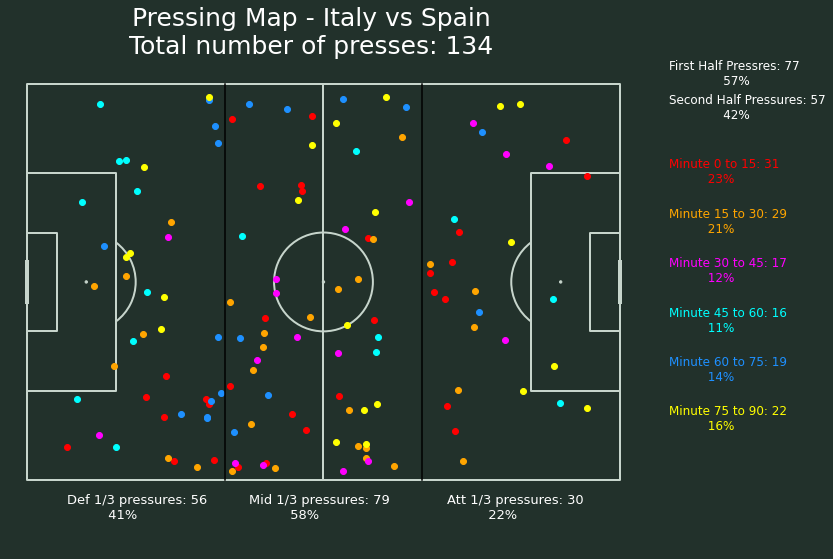

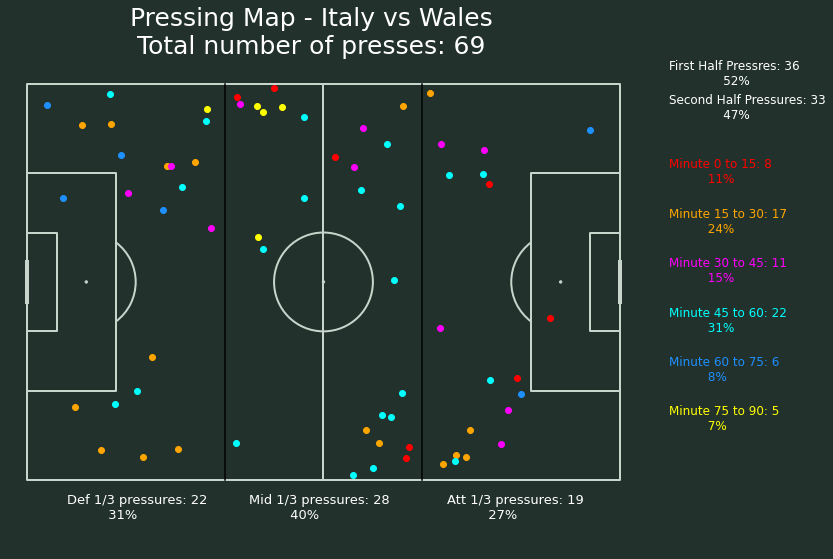

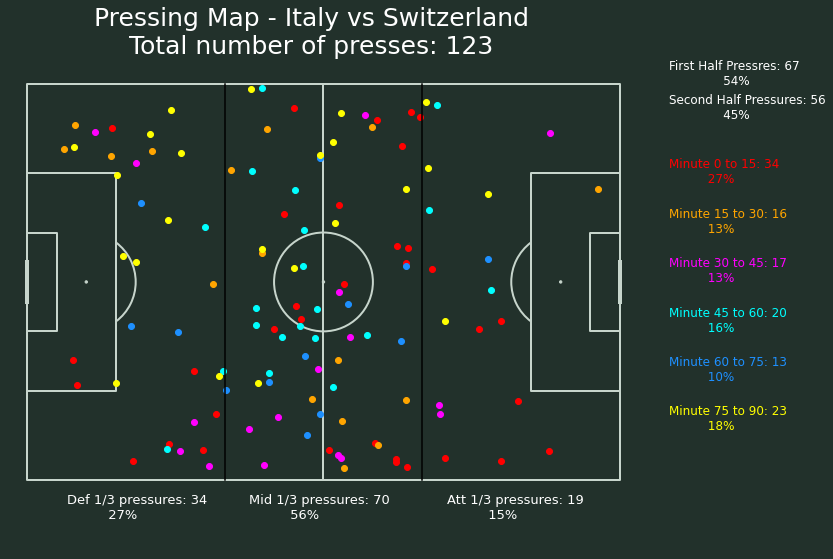

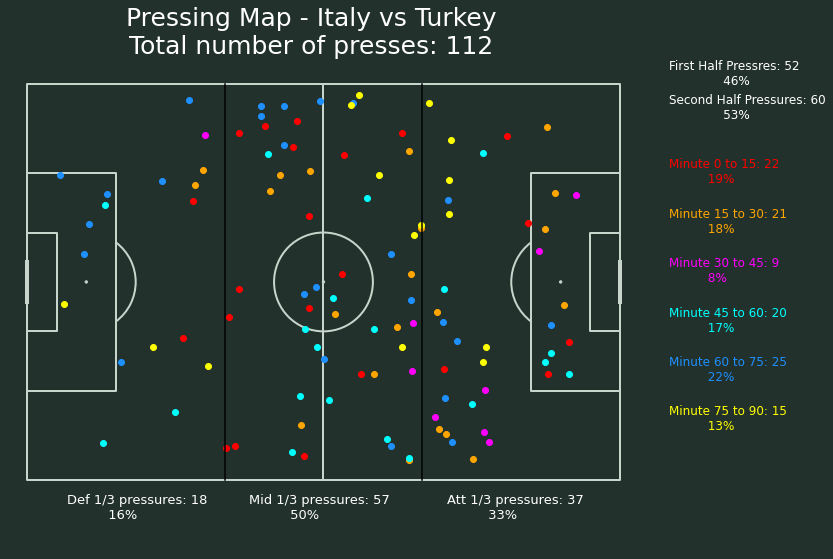

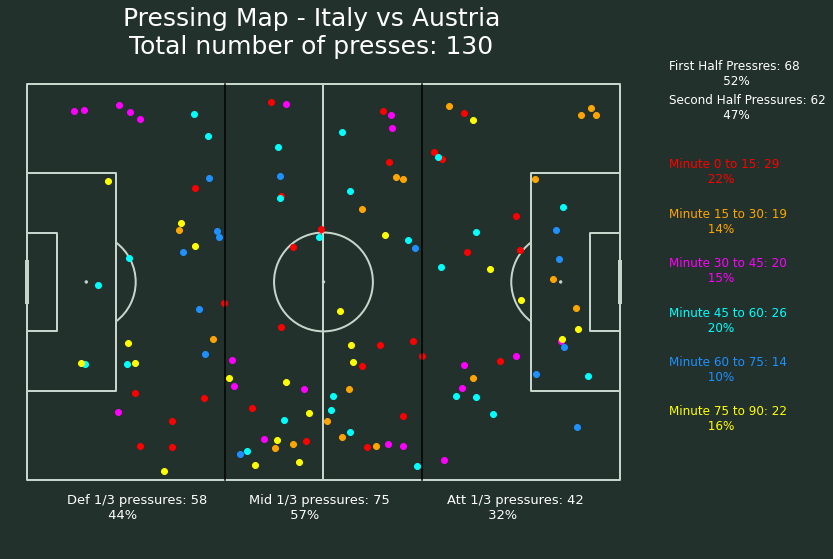

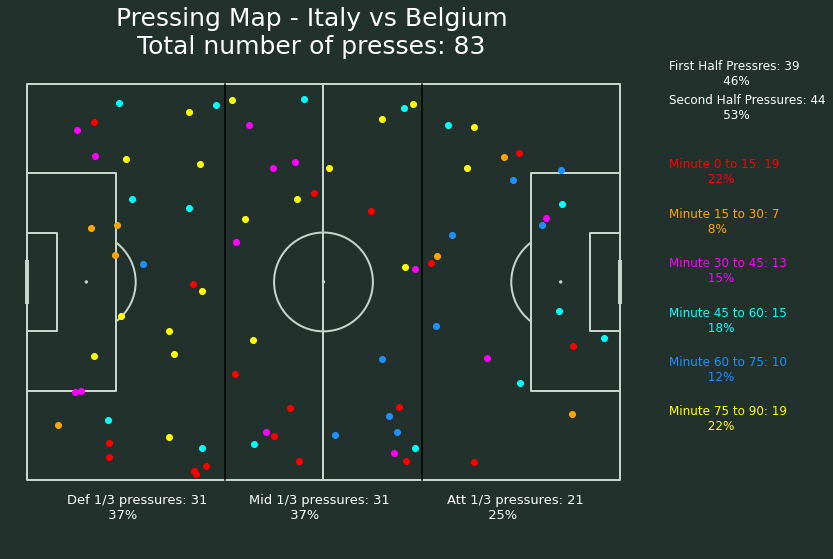

In [10]:
# Print all pressures of all Italy matches
for matchId in itaMatchIds:
    tempMatchDf = getEvents(matchId)
    pressureVizz(tempMatchDf, 'Italy')

## Def Actions per player

In [15]:
# Find Italy matches (Except for final)
euroDf = sb.matches(55, 43)
itaDf = euroDf.loc[((euroDf['home_team'] == 'Italy') | (euroDf['away_team'] == 'Italy')) & (euroDf['competition_stage'] != 'Final')]
itaDf.sort_values('match_date')

match_id  match_date      kick_off         competition season home_team  \
11   3788741  2021-06-11  21:00:00.000  Europe - UEFA Euro   2020    Turkey   
7    3788754  2021-06-16  21:00:00.000  Europe - UEFA Euro   2020     Italy   
3    3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020     Italy   
21   3794685  2021-06-26  21:00:00.000  Europe - UEFA Euro   2020     Italy   
34   3795107  2021-07-02  21:00:00.000  Europe - UEFA Euro   2020   Belgium   
0    3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020     Italy   

      away_team  home_score  away_score match_status  ...  last_updated_360  \
11        Italy           0           3    available  ...  2022-08-04T12:00   
7   Switzerland           3           0    available  ...  2022-08-04T12:00   
3         Wales           1           0    available  ...  2022-08-04T12:00   
21      Austria           2           1    available  ...  2022-08-04T12:00   
34        Italy           1           2    available  ...  2022-08-04T12:00   
0         Spain           1           1    available  ...  2022-08-04T12:00   

   match_week competition_stage           stadium                 referee  \
11          1       Group Stage  Estadio Olímpico  Danny Desmond Makkelie   
7           2       Group Stage  Estadio Olímpico          Sergey Karasev   
3           3       Group Stage  Estadio Olímpico     Ovidiu Alin Hațegan   
21          4       Round of 16   Wembley Stadium          Anthony Taylor   
34          5    Quarter-finals     Allianz Arena           Slavko Vinčić   
0           6       Semi-finals   Wembley Stadium             Felix Brych   

                home_managers                 away_managers data_version  \
11                Şenol Güneş               Roberto Mancini        1.1.0   
7             Roberto Mancini             Vladimir Petković        1.1.0   
3                                                                  1.1.0   
21            Roberto Mancini                   Franco Foda        1.1.0   
34  Roberto Martínez Montoliú               Roberto Mancini        1.1.0   
0             Roberto Mancini  Luis Enrique Martínez García        1.1.0   

   shot_fidelity_version xy_fidelity_version  
11                     2                   2  
7                      2                   2  
3                      2                   2  
21                     2                   2  
34                     2                   2  
0                      2                   2  

[6 rows x 22 columns]

In [18]:
# Find defnsive actions in Switzerland - Italy
defActions = ['Ball Recovery', 'Duel', 'Block', 'Clearance', 'Interception', 'Pressure', 'Foul Committed']
matchDf = getEvents(3788741)
itaDefActions = matchDf.loc[(matchDf['team'] == 'Italy') & (matchDf['type'].isin(defActions))]
itaDefActions.dropna(axis=1, how='all')

ball_recovery_offensive ball_recovery_recovery_failure  \
2948                     NaN                            NaN   
2949                     NaN                            NaN   
2951                     NaN                            NaN   
2952                     NaN                            NaN   
2953                     NaN                            NaN   
...                      ...                            ...   
3730                     NaN                            NaN   
3733                     NaN                            NaN   
3741                     NaN                            NaN   
3742                     NaN                            NaN   
3745                     NaN                            NaN   

     clearance_aerial_won clearance_body_part clearance_head  \
2948                  NaN                 NaN            NaN   
2949                  NaN                 NaN            NaN   
2951                  NaN                 NaN            NaN   
2952                  NaN                 NaN            NaN   
2953                  NaN                 NaN            NaN   
...                   ...                 ...            ...   
3730                  NaN                 NaN            NaN   
3733                  NaN                 NaN            NaN   
3741                  NaN                 NaN            NaN   
3742                  NaN                 NaN            NaN   
3745                  NaN                 NaN            NaN   

     clearance_left_foot clearance_right_foot counterpress duel_outcome  \
2948                 NaN                  NaN          NaN          NaN   
2949                 NaN                  NaN          NaN          NaN   
2951                 NaN                  NaN         True          NaN   
2952                 NaN                  NaN         True          NaN   
2953                 NaN                  NaN         True          NaN   
...                  ...                  ...          ...          ...   
3730                 NaN                  NaN          NaN          NaN   
3733                 NaN                  NaN          NaN          NaN   
3741                 NaN                  NaN          NaN          NaN   
3742                 NaN                  NaN          NaN          NaN   
3745                 NaN                  NaN         True          NaN   

     duel_type  ...  possession_team possession_team_id  \
2948       NaN  ...           Turkey                909   
2949       NaN  ...            Italy                914   
2951       NaN  ...           Turkey                909   
2952       NaN  ...           Turkey                909   
2953       NaN  ...           Turkey                909   
...        ...  ...              ...                ...   
3730       NaN  ...           Turkey                909   
3733       NaN  ...           Turkey                909   
3741       NaN  ...            Italy                914   
3742       NaN  ...           Turkey                909   
3745       NaN  ...           Turkey                909   

                                         related_events  second   team  \
2948  [37105d1f-4313-4db6-b8ba-76c224e488ca, ced7b36...       6  Italy   
2949             [441bd112-a75f-42cc-a37d-34b61e6ce123]      37  Italy   
2951             [b3b47c74-acf5-4617-8b3a-48338d3fd00e]       0  Italy   
2952  [233c2310-e155-4a84-884e-f9c00aa207c8, 589f3d5...       1  Italy   
2953             [cd12db99-3569-4124-a81e-156b91eb97e5]       4  Italy   
...                                                 ...     ...    ...   
3730  [8b6ba870-4f8f-4b0c-884a-45c121651ced, f924881...      33  Italy   
3733             [41074f33-29d5-46dc-ad79-2633c95ec12d]      36  Italy   
3741             [2c3da2e0-f9d7-4b69-93e0-20a6a95b98af]      49  Italy   
3742             [a814633a-ccdf-46a2-8750-7ac360ee4ae0]      18  Italy   
3745  [0932fb8b-705c-4441-9fac-ffce571f3784, b37d2a3...

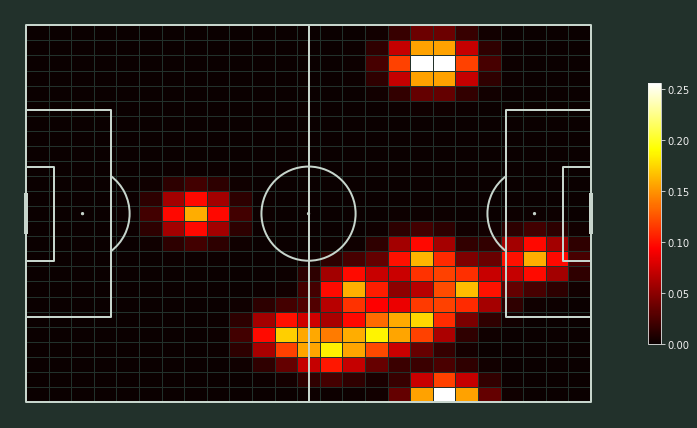

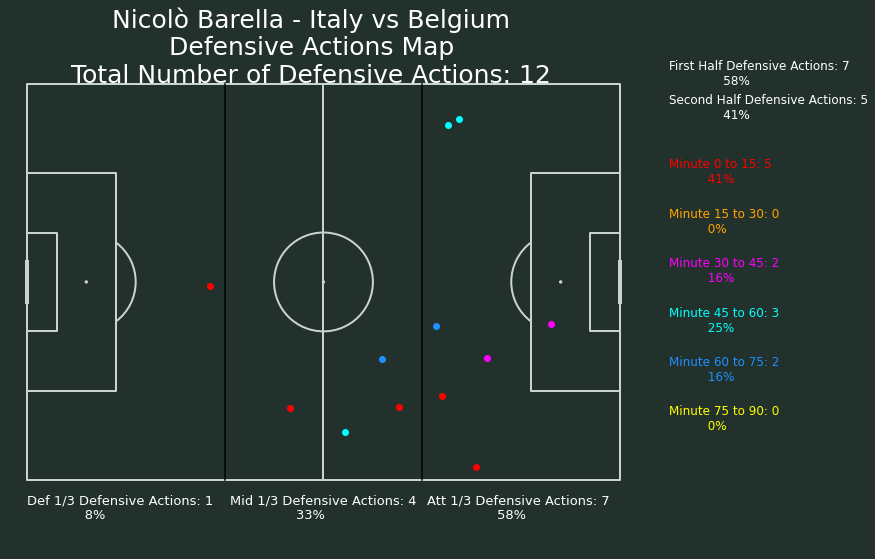

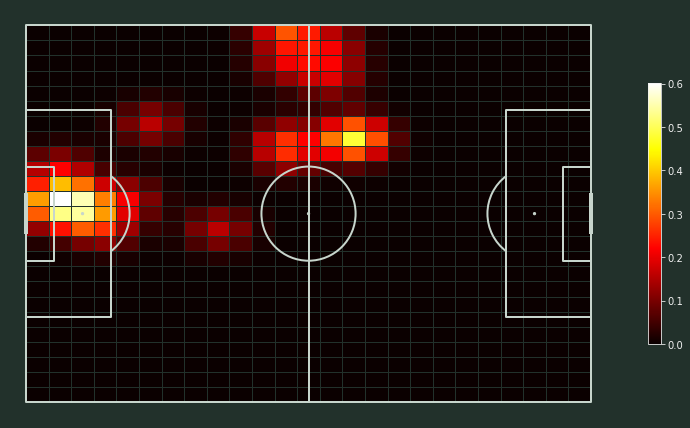

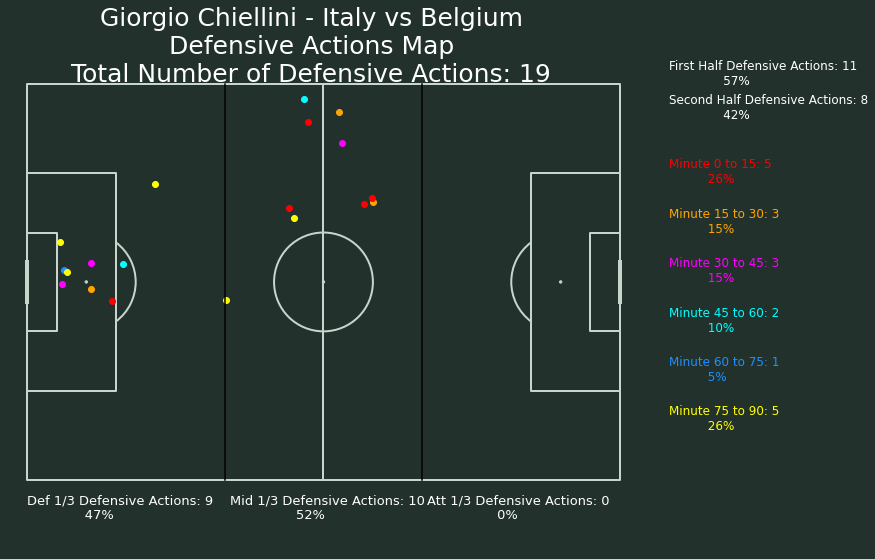

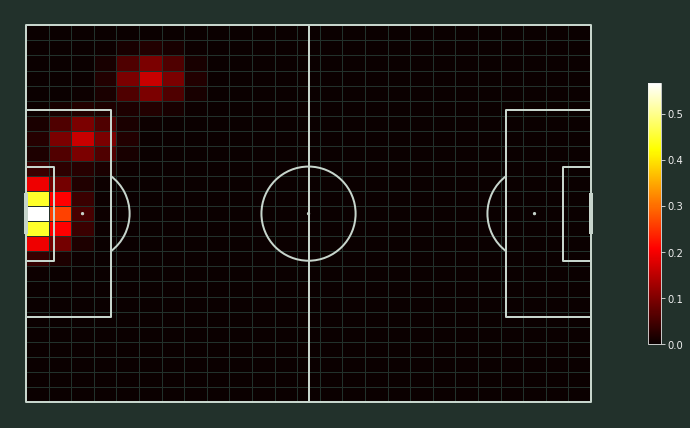

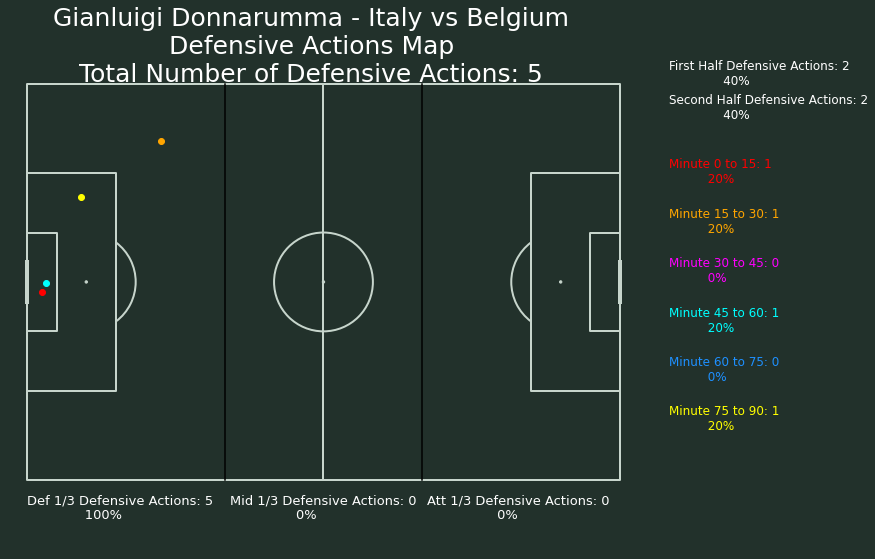

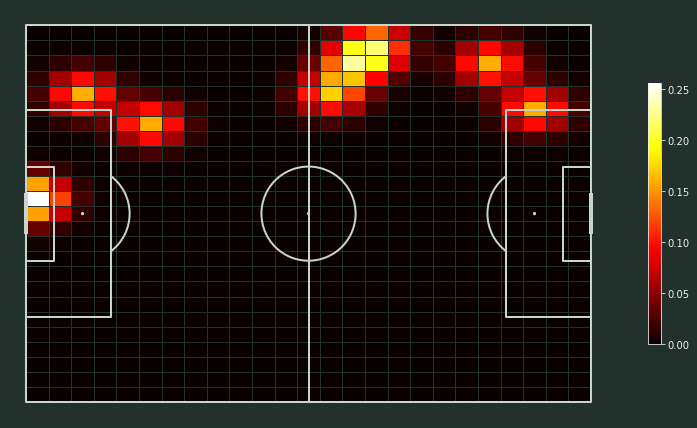

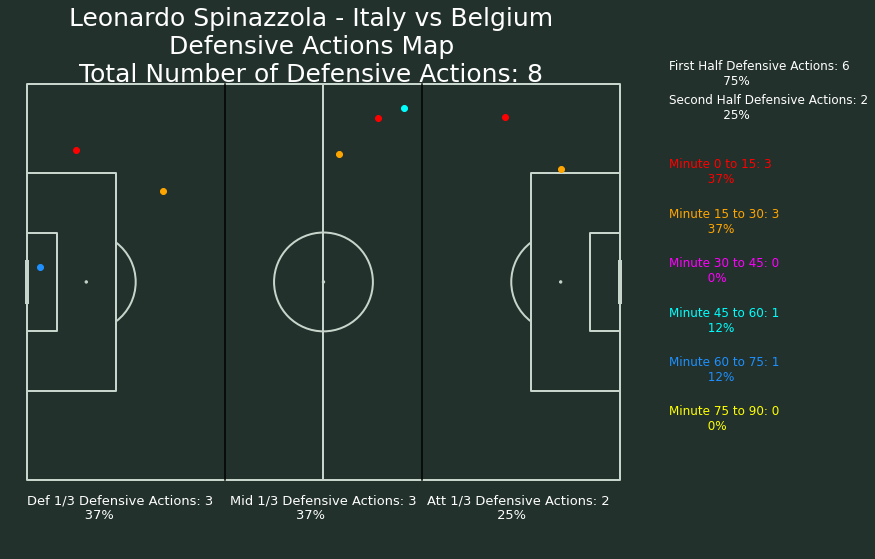

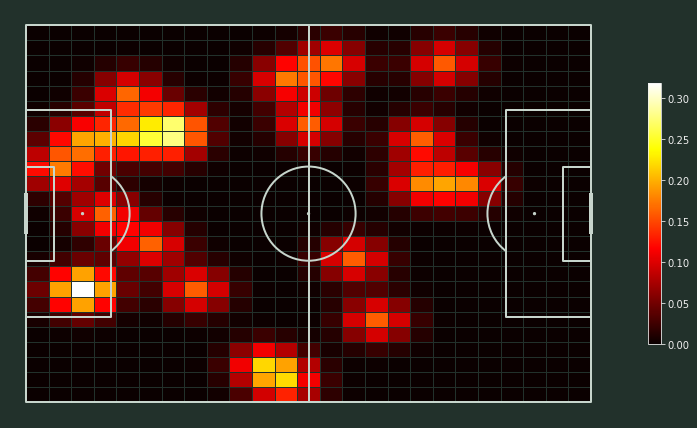

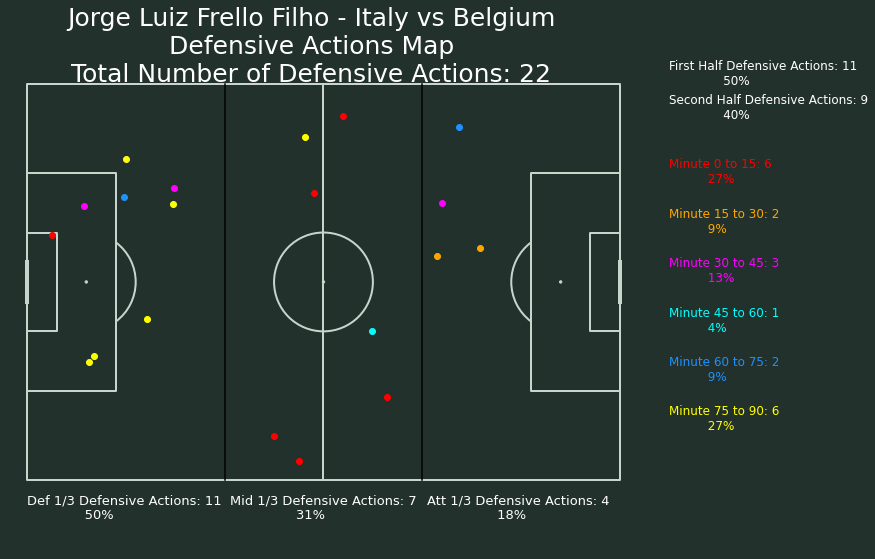

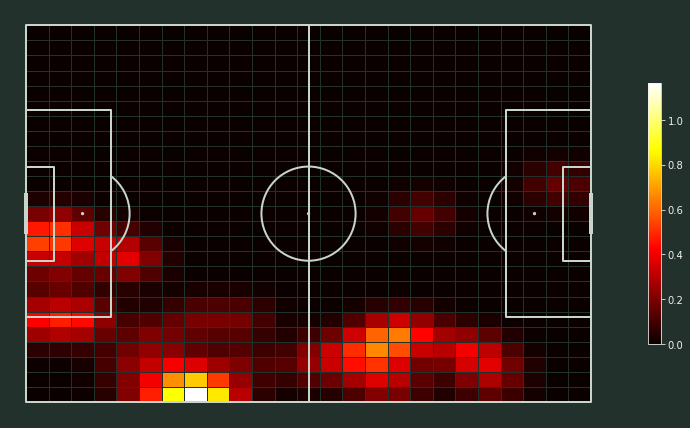

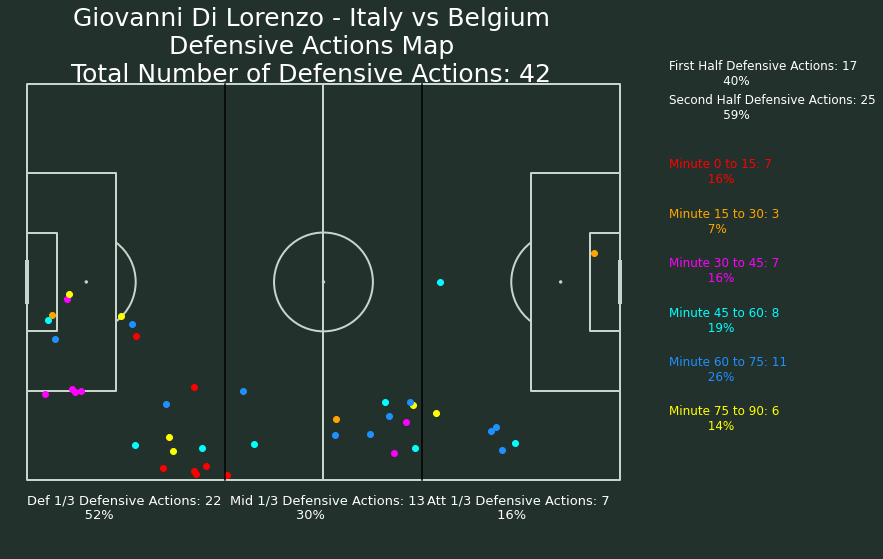

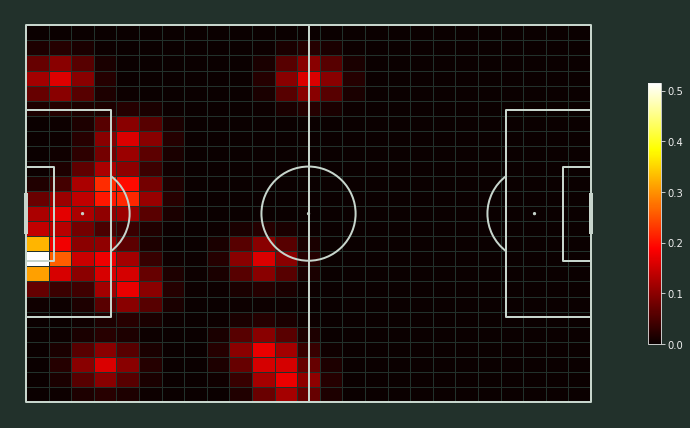

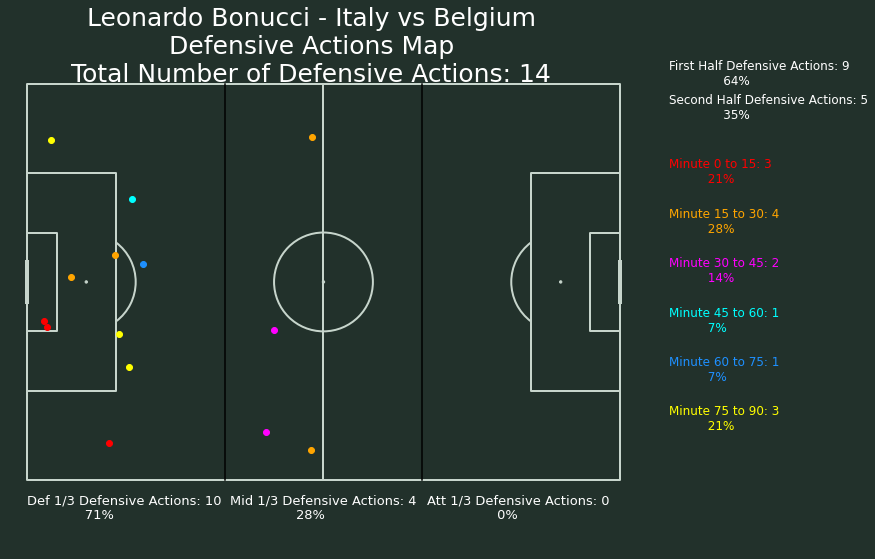

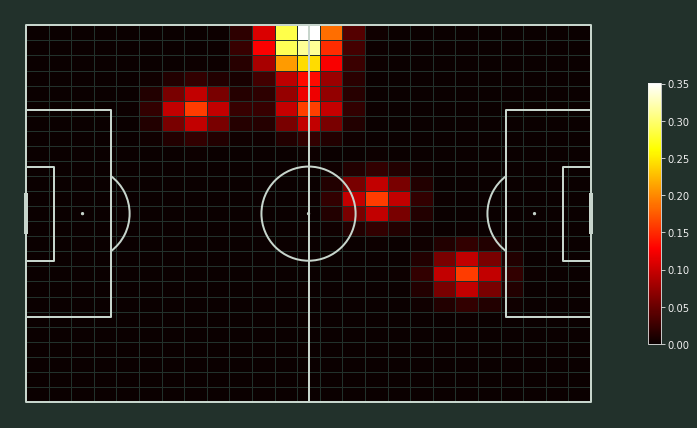

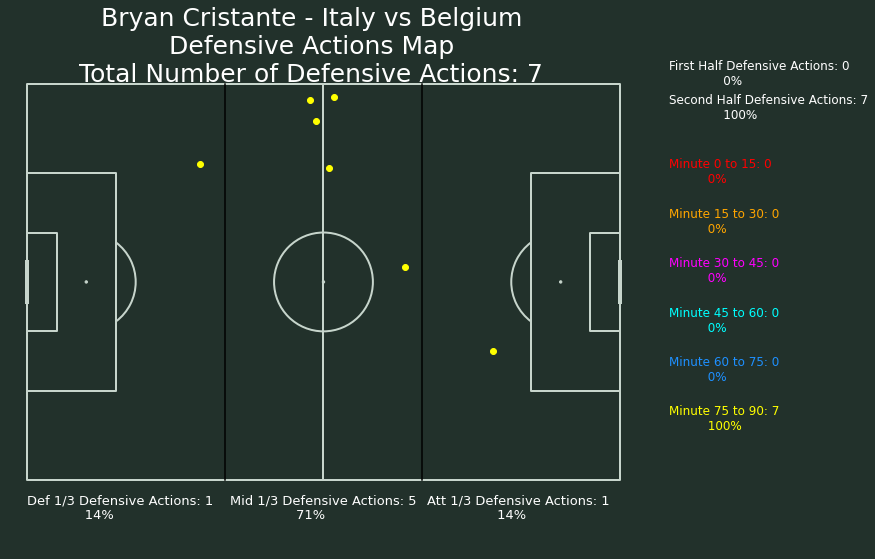

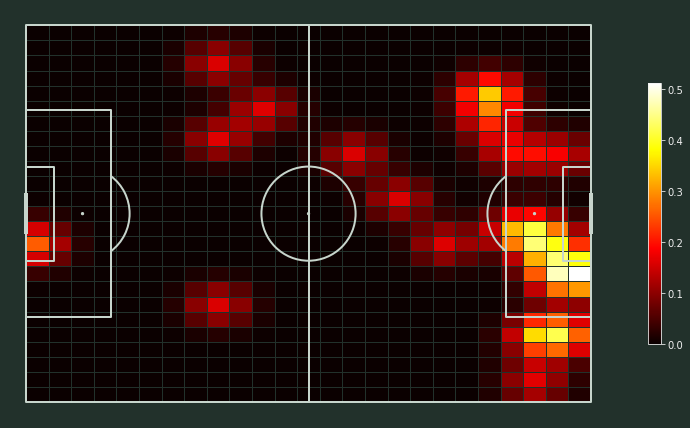

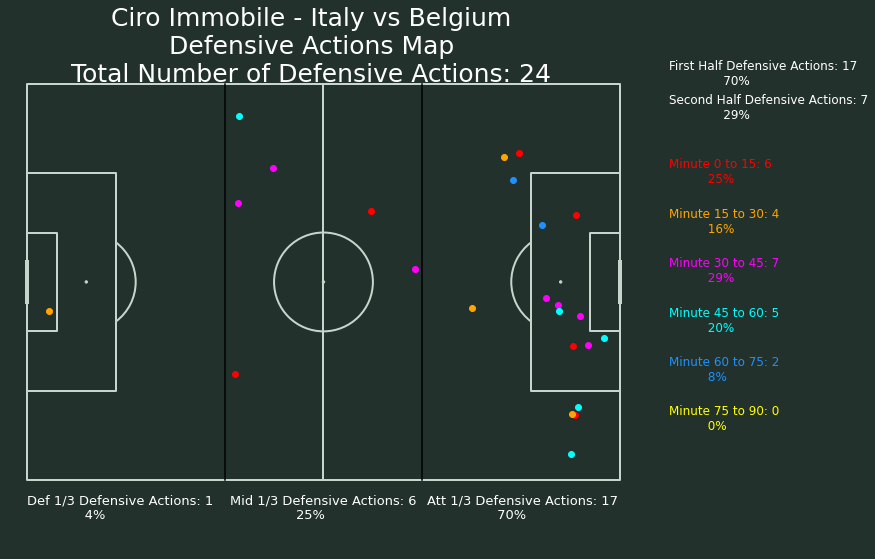

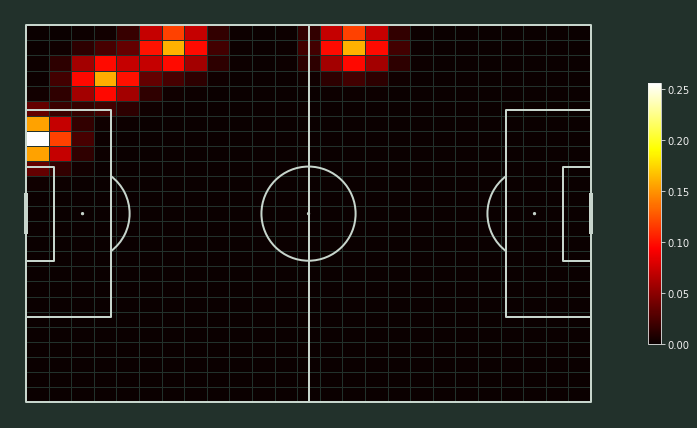

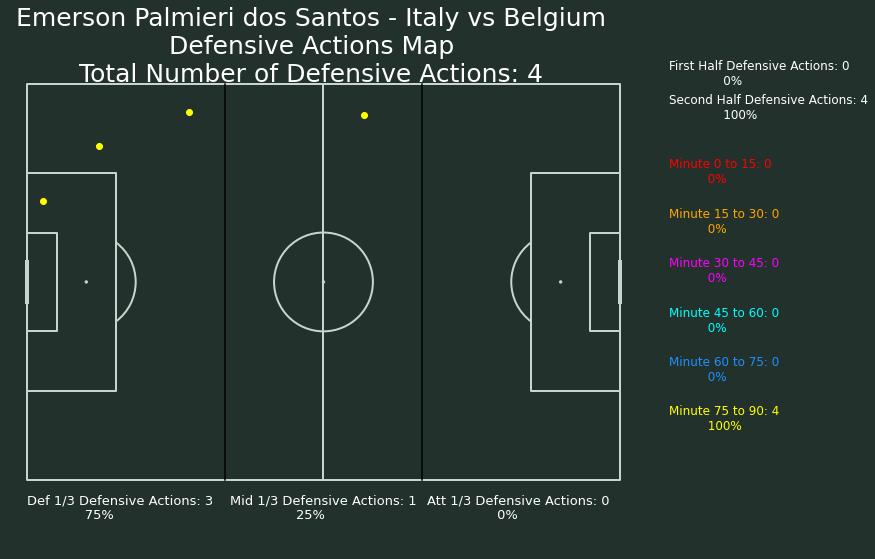

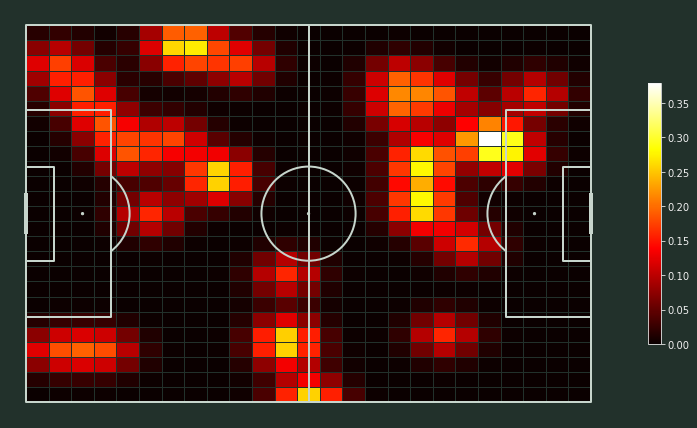

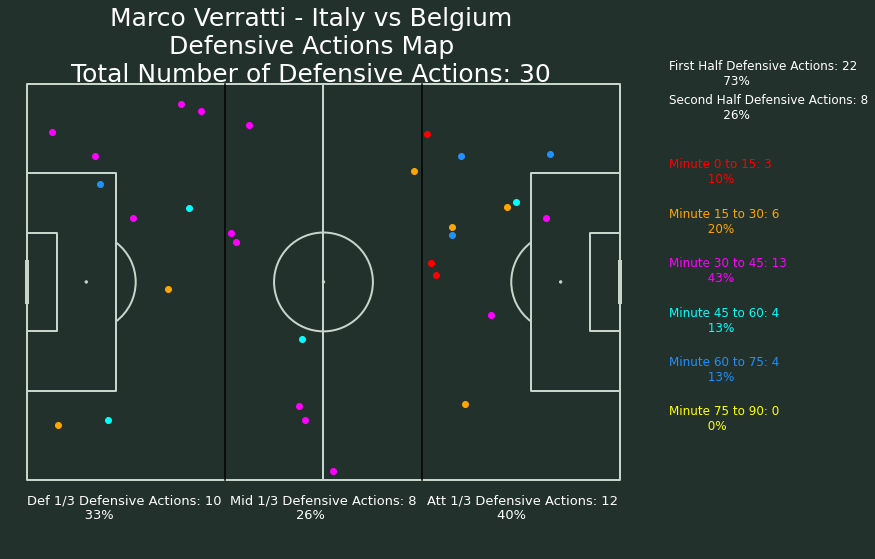

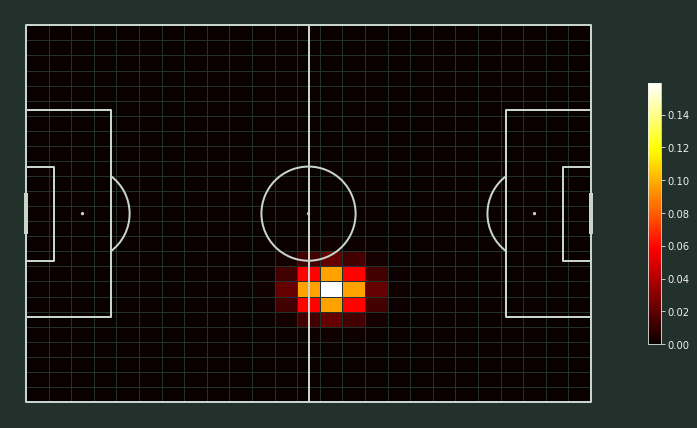

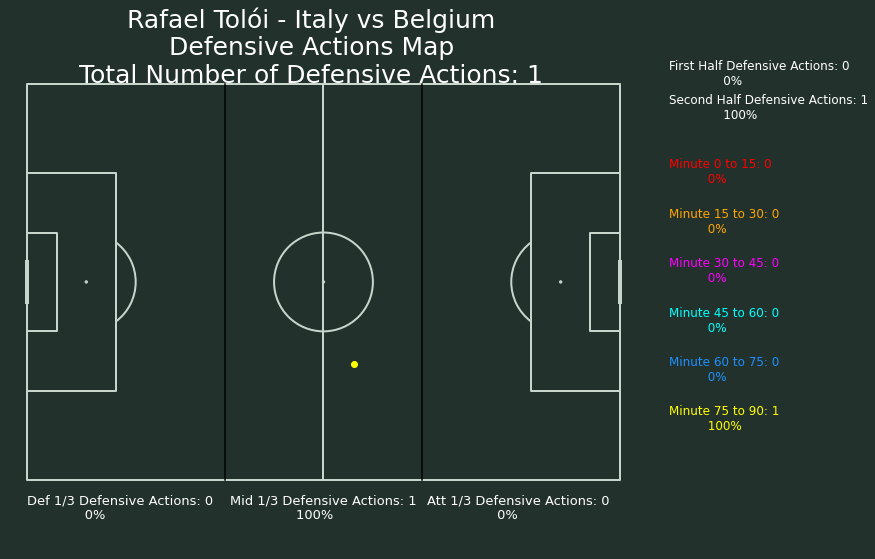

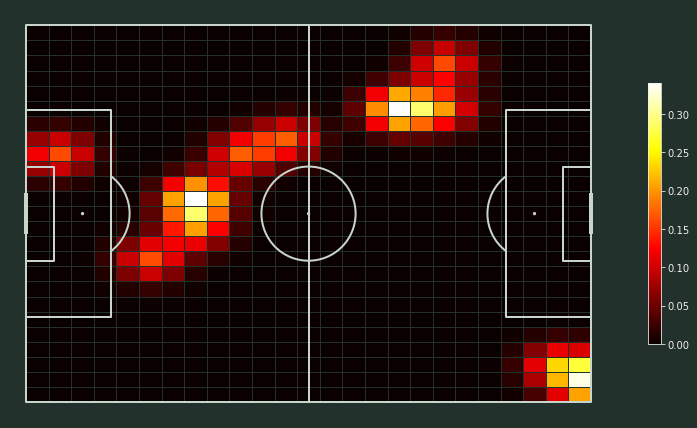

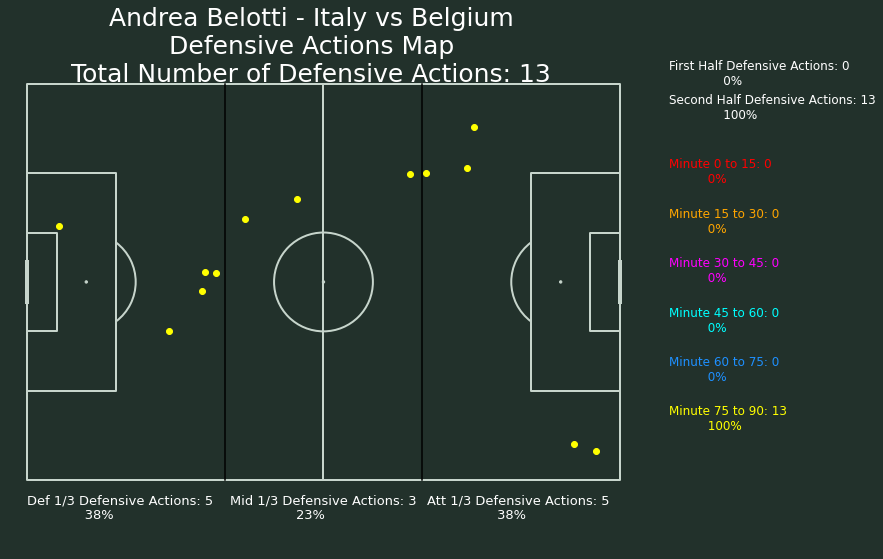

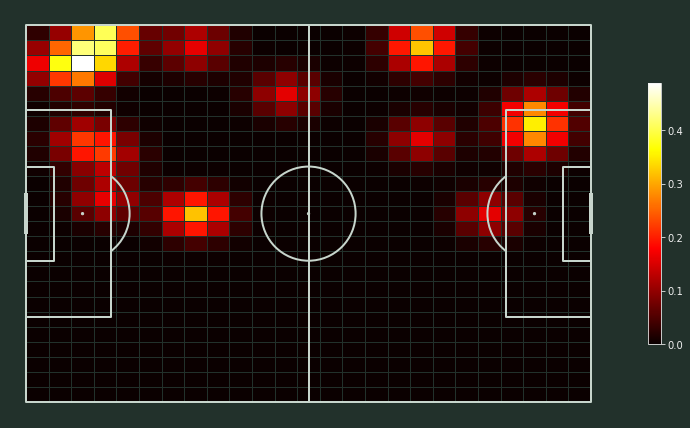

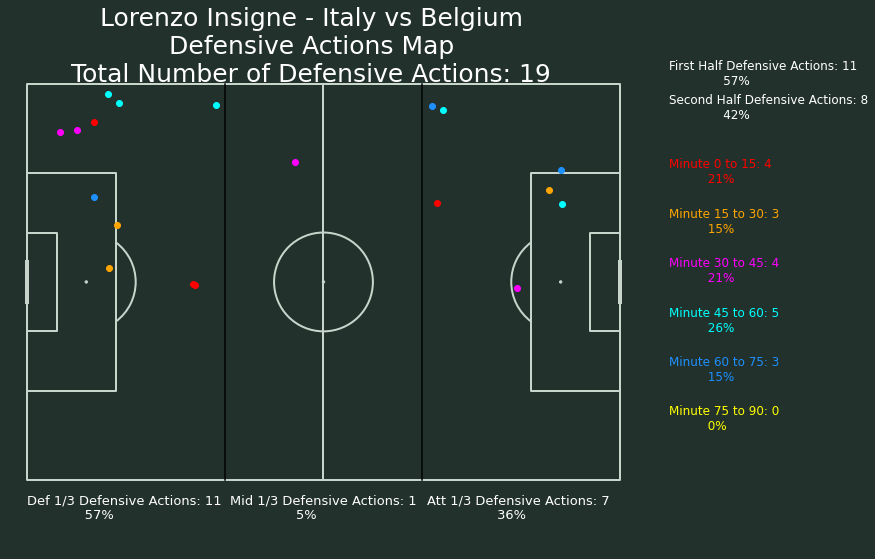

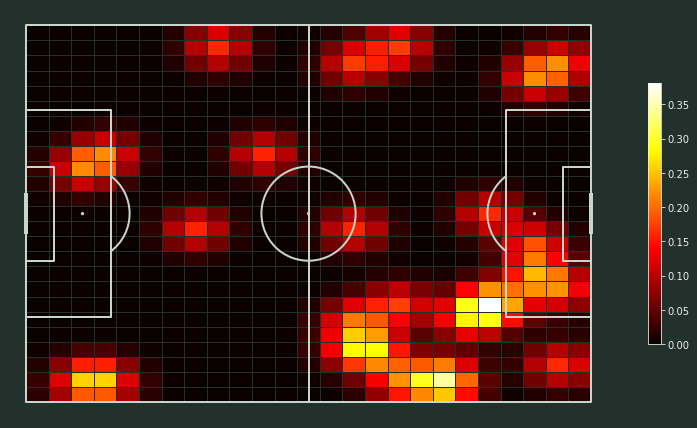

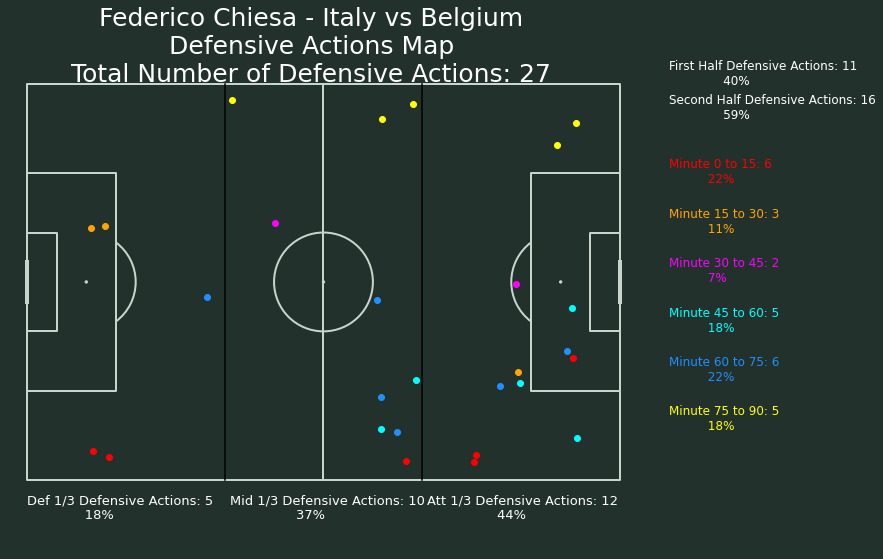

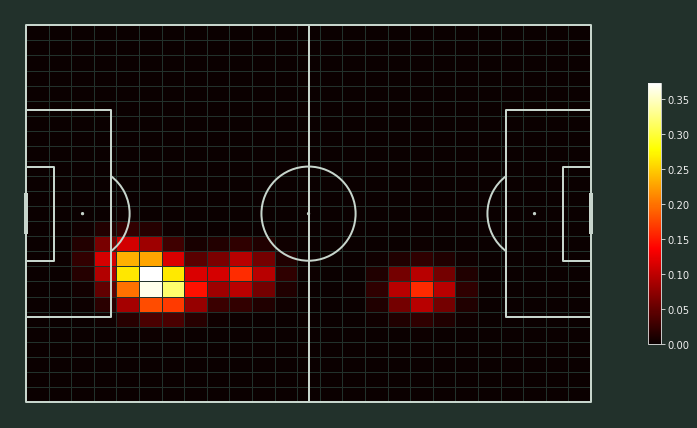

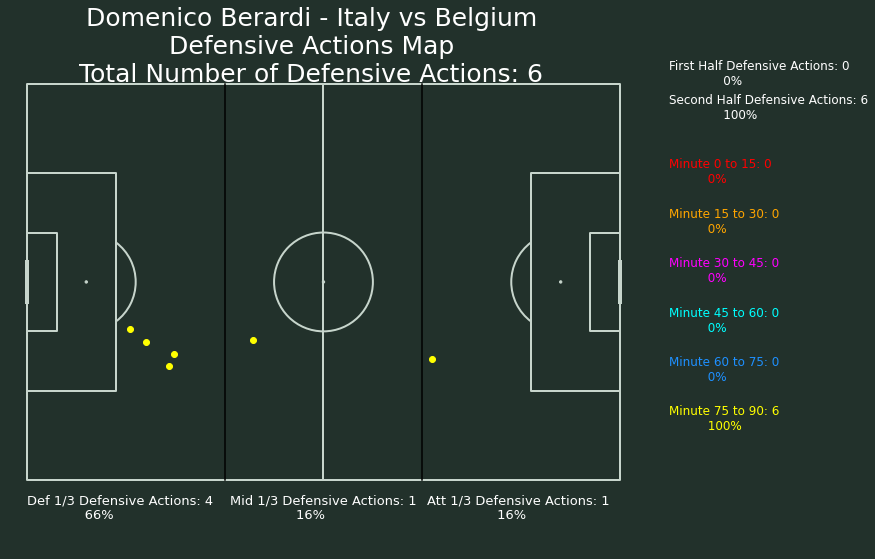

In [21]:
# Create by player def actions vizz

# Italy - Belgium
someDf = getEvents(3795107)

defActionsVizz(someDf, 'Italy')

# Italy Analysis

### Avg Pressure Number

In [16]:
# Find Italy matches (Except for final)
euroDf = sb.matches(55, 43)
itaDf = euroDf.loc[((euroDf['home_team'] == 'Italy') | (euroDf['away_team'] == 'Italy')) & (euroDf['competition_stage'] != 'Final')]
itaDf.sort_values('match_date')

match_id  match_date      kick_off         competition season home_team  \
11   3788741  2021-06-11  21:00:00.000  Europe - UEFA Euro   2020    Turkey   
7    3788754  2021-06-16  21:00:00.000  Europe - UEFA Euro   2020     Italy   
3    3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020     Italy   
21   3794685  2021-06-26  21:00:00.000  Europe - UEFA Euro   2020     Italy   
34   3795107  2021-07-02  21:00:00.000  Europe - UEFA Euro   2020   Belgium   
0    3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020     Italy   

      away_team  home_score  away_score match_status  ...  last_updated_360  \
11        Italy           0           3    available  ...  2022-08-04T12:00   
7   Switzerland           3           0    available  ...  2022-08-04T12:00   
3         Wales           1           0    available  ...  2022-08-04T12:00   
21      Austria           2           1    available  ...  2022-08-04T12:00   
34        Italy           1           2    available  ...  2022-08-04T12:00   
0         Spain           1           1    available  ...  2022-08-04T12:00   

   match_week competition_stage           stadium                 referee  \
11          1       Group Stage  Estadio Olímpico  Danny Desmond Makkelie   
7           2       Group Stage  Estadio Olímpico          Sergey Karasev   
3           3       Group Stage  Estadio Olímpico     Ovidiu Alin Hațegan   
21          4       Round of 16   Wembley Stadium          Anthony Taylor   
34          5    Quarter-finals     Allianz Arena           Slavko Vinčić   
0           6       Semi-finals   Wembley Stadium             Felix Brych   

                home_managers                 away_managers data_version  \
11                Şenol Güneş               Roberto Mancini        1.1.0   
7             Roberto Mancini             Vladimir Petković        1.1.0   
3                                                                  1.1.0   
21            Roberto Mancini                   Franco Foda        1.1.0   
34  Roberto Martínez Montoliú               Roberto Mancini        1.1.0   
0             Roberto Mancini  Luis Enrique Martínez García        1.1.0   

   shot_fidelity_version xy_fidelity_version  
11                     2                   2  
7                      2                   2  
3                      2                   2  
21                     2                   2  
34                     2                   2  
0                      2                   2  

[6 rows x 22 columns]

In [17]:
# Store all match IDs in list
itaMatchIds = itaDf['match_id'].tolist() 
itaMatchIds

[3795220, 3788766, 3788754, 3788741, 3794685, 3795107]

In [18]:
totalPrs = 0
numOfMatches = len(itaMatchIds)

# Extract number of pressure actions in every Italy match
for matchId in itaMatchIds:
    matchEvents = getEvents(matchId)
    
    # Take only pressure actions of requested team
    prsEvents = matchEvents[(matchEvents.type == 'Pressure') & (matchEvents.team == 'Italy')]

    # Take Only events of known location
    prsEvents = prsEvents[prsEvents['locationX'].notna()]

    # Remove counterpress actions, has more to do with attacking attributes than defending
    prsEvents = prsEvents[~(prsEvents.counterpress == True)]
    
    # Add number of pressures from match to total
    totalPrs += prsEvents.shape[0]

avgPrs = totalPrs / numOfMatches
print(f'Average Pressures per match: {int(avgPrs)}')

Average Pressures per match: 121


## Italy - Belgium (3795107) Quarter Final

In [19]:
# Find Italy matches (Except for final)
euroDf = sb.matches(55, 43)
itaDf = euroDf.loc[((euroDf['home_team'] == 'Italy') | (euroDf['away_team'] == 'Italy')) & (euroDf['competition_stage'] != 'Final')]
itaDf.sort_values('match_date')

match_id  match_date      kick_off         competition season home_team  \
11   3788741  2021-06-11  21:00:00.000  Europe - UEFA Euro   2020    Turkey   
7    3788754  2021-06-16  21:00:00.000  Europe - UEFA Euro   2020     Italy   
3    3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020     Italy   
21   3794685  2021-06-26  21:00:00.000  Europe - UEFA Euro   2020     Italy   
34   3795107  2021-07-02  21:00:00.000  Europe - UEFA Euro   2020   Belgium   
0    3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020     Italy   

      away_team  home_score  away_score match_status  ...  last_updated_360  \
11        Italy           0           3    available  ...  2022-08-04T12:00   
7   Switzerland           3           0    available  ...  2022-08-04T12:00   
3         Wales           1           0    available  ...  2022-08-04T12:00   
21      Austria           2           1    available  ...  2022-08-04T12:00   
34        Italy           1           2    available  ...  2022-08-04T12:00   
0         Spain           1           1    available  ...  2022-08-04T12:00   

   match_week competition_stage           stadium                 referee  \
11          1       Group Stage  Estadio Olímpico  Danny Desmond Makkelie   
7           2       Group Stage  Estadio Olímpico          Sergey Karasev   
3           3       Group Stage  Estadio Olímpico     Ovidiu Alin Hațegan   
21          4       Round of 16   Wembley Stadium          Anthony Taylor   
34          5    Quarter-finals     Allianz Arena           Slavko Vinčić   
0           6       Semi-finals   Wembley Stadium             Felix Brych   

                home_managers                 away_managers data_version  \
11                Şenol Güneş               Roberto Mancini        1.1.0   
7             Roberto Mancini             Vladimir Petković        1.1.0   
3                                                                  1.1.0   
21            Roberto Mancini                   Franco Foda        1.1.0   
34  Roberto Martínez Montoliú               Roberto Mancini        1.1.0   
0             Roberto Mancini  Luis Enrique Martínez García        1.1.0   

   shot_fidelity_version xy_fidelity_version  
11                     2                   2  
7                      2                   2  
3                      2                   2  
21                     2                   2  
34                     2                   2  
0                      2                   2  

[6 rows x 22 columns]

### Pressures

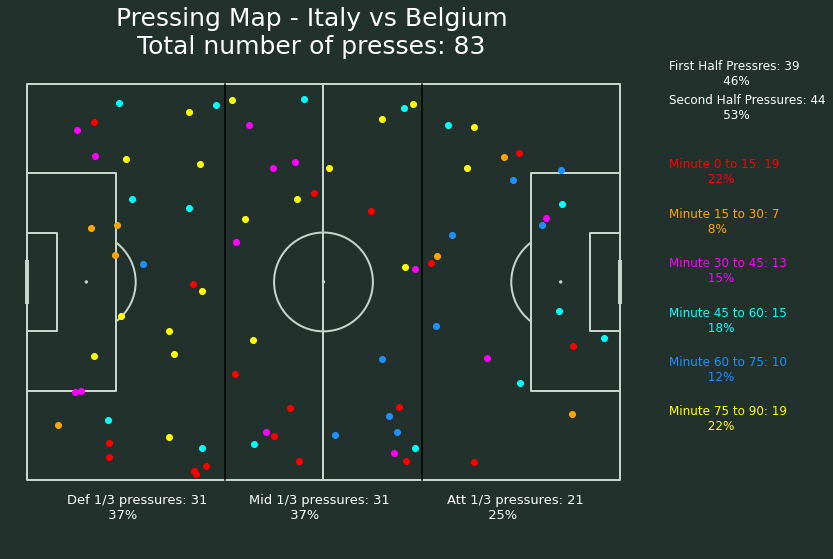

In [20]:
# Create Italy pressure vizz

# Italy - Belgium
itaBelDf = getEvents(3795107)

pressureVizz(itaBelDf, 'Italy')

### Def Actions

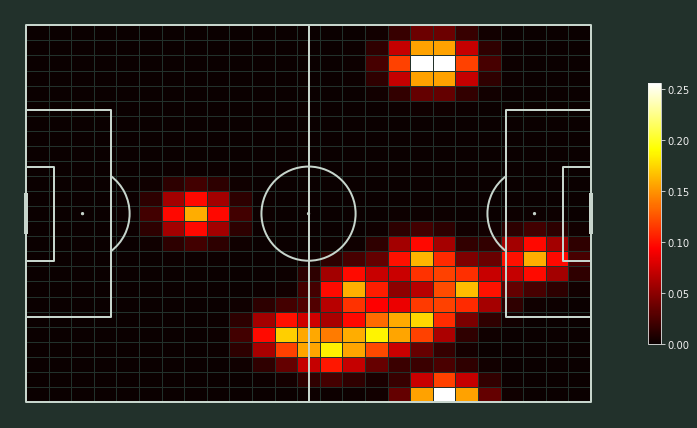

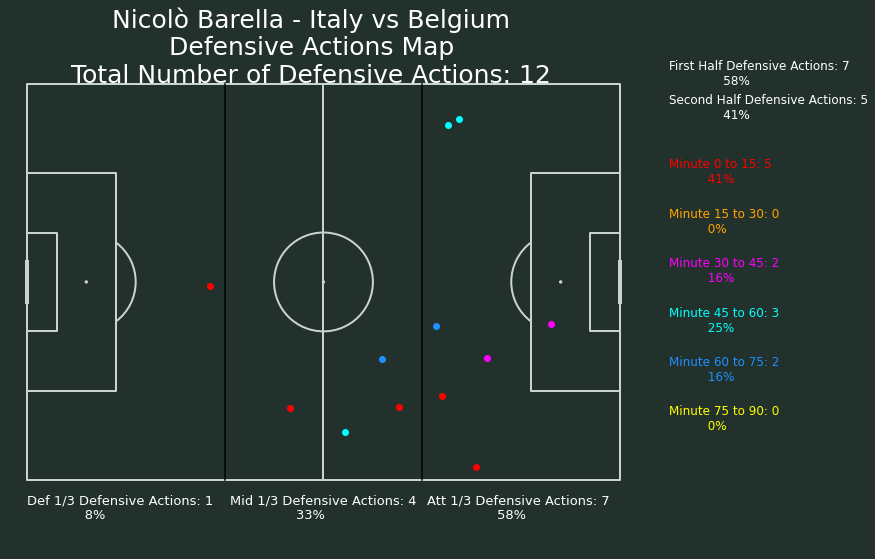

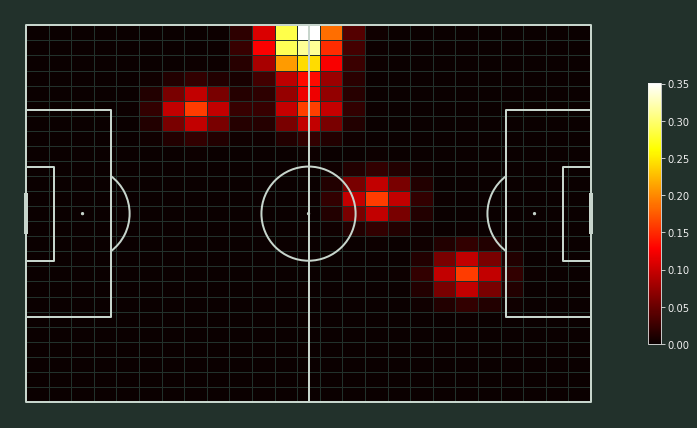

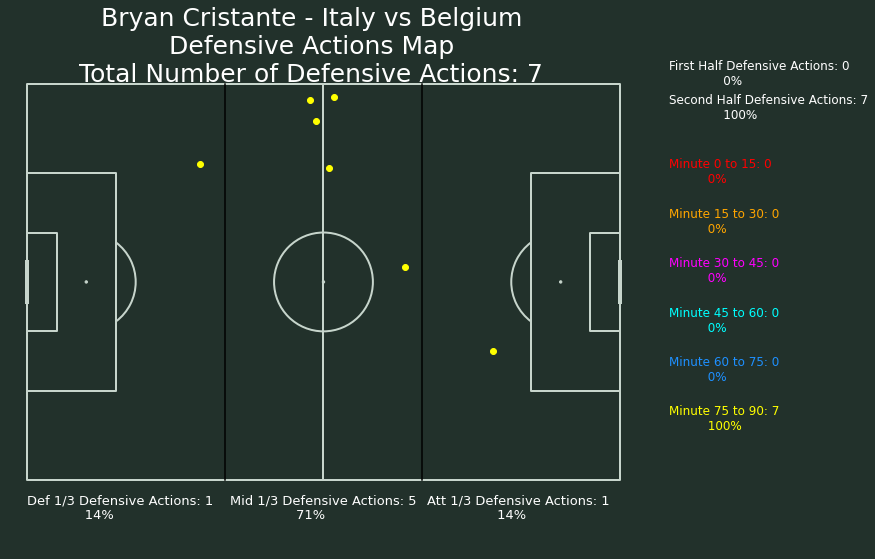

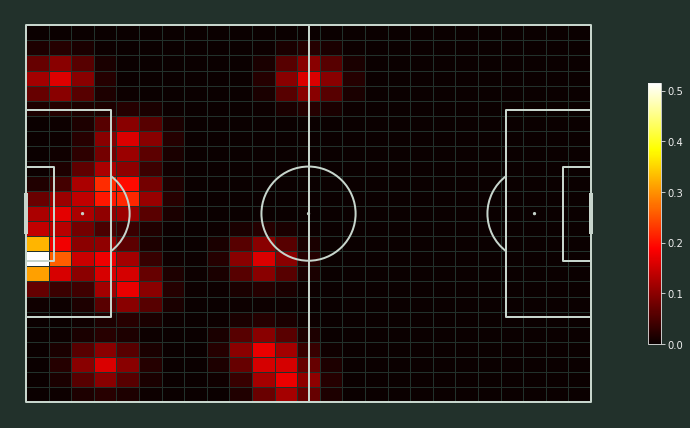

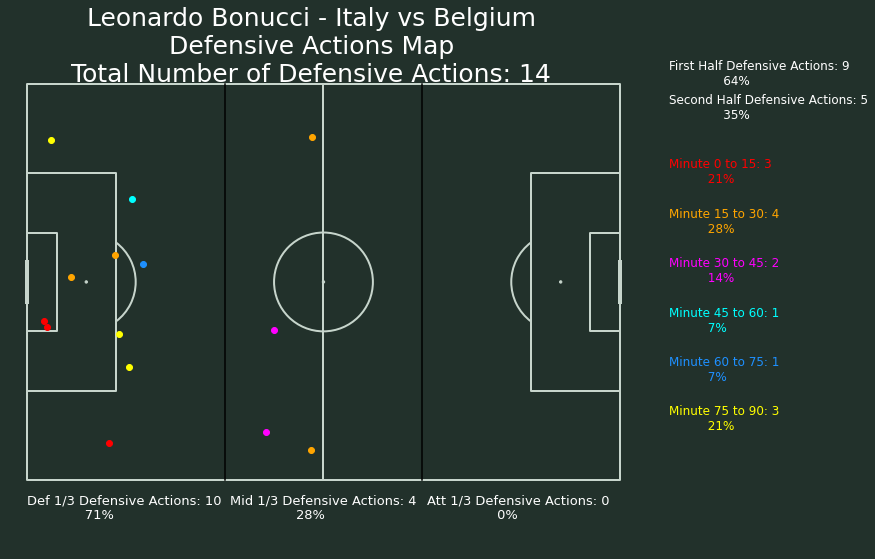

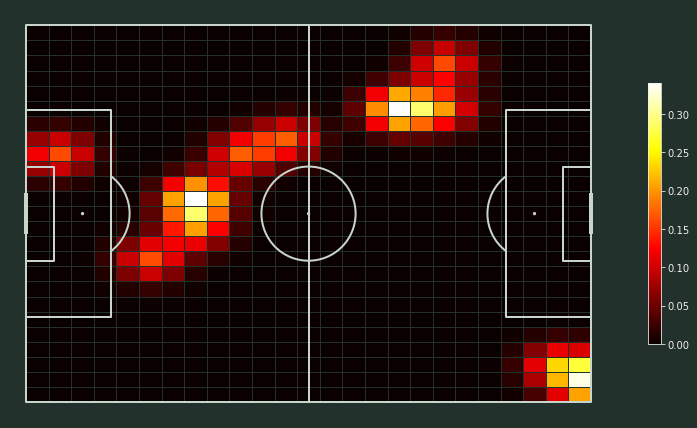

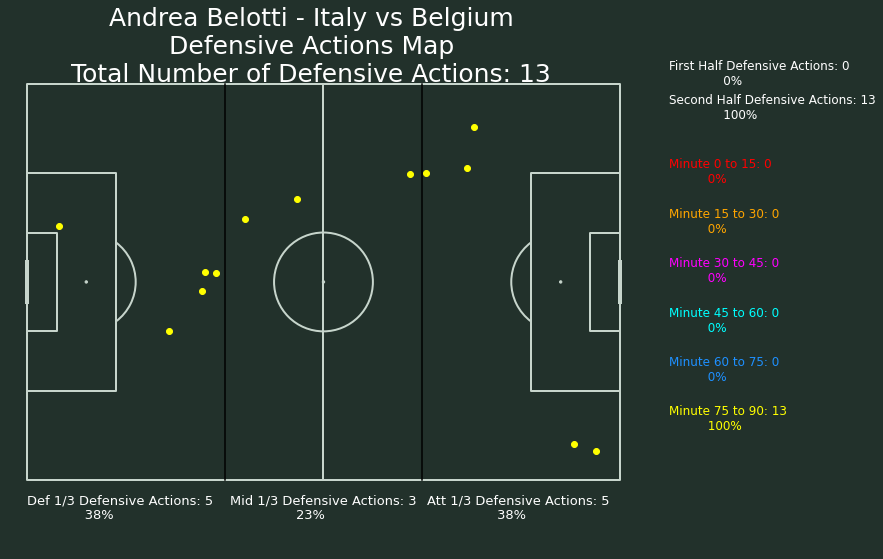

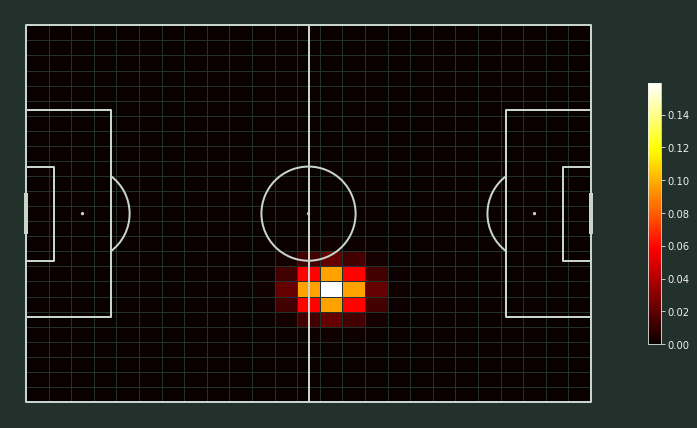

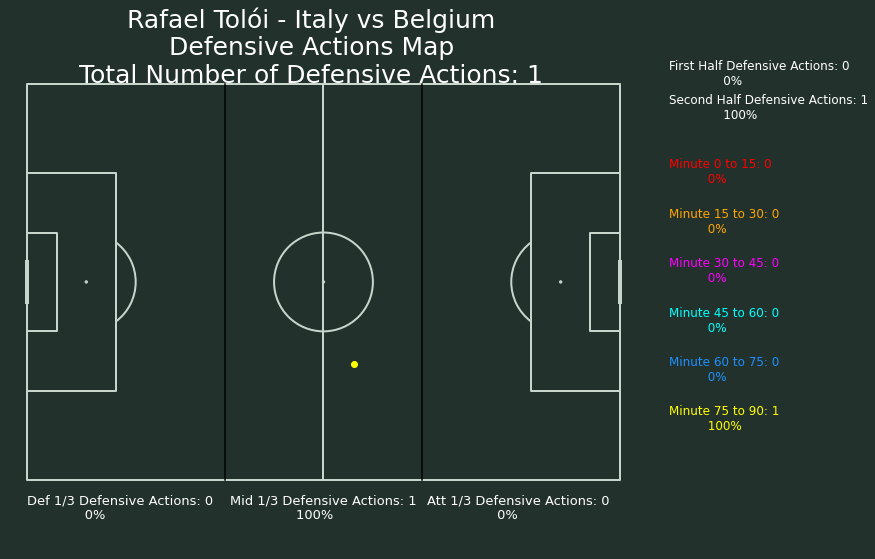

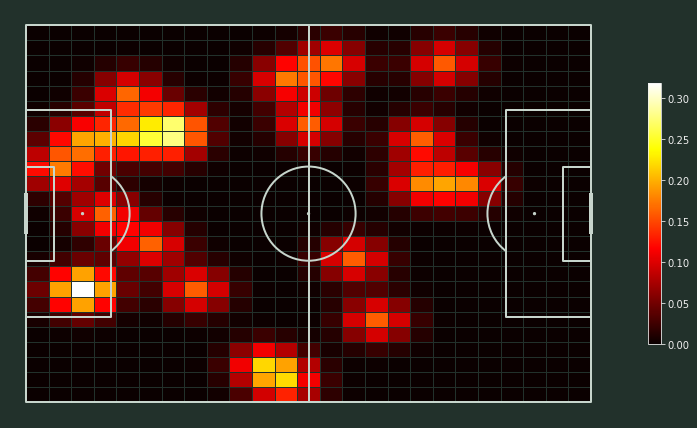

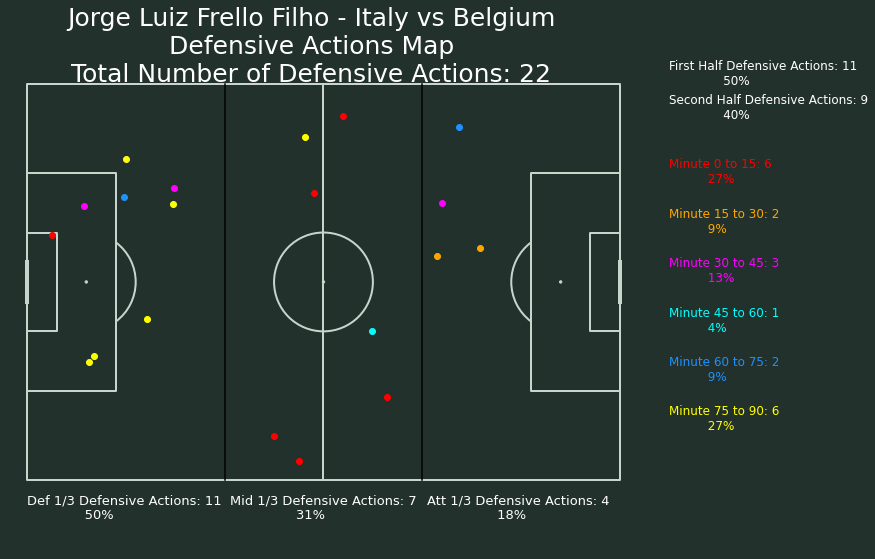

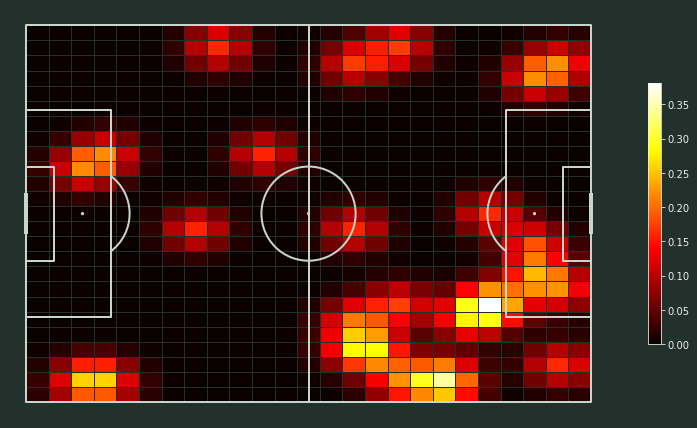

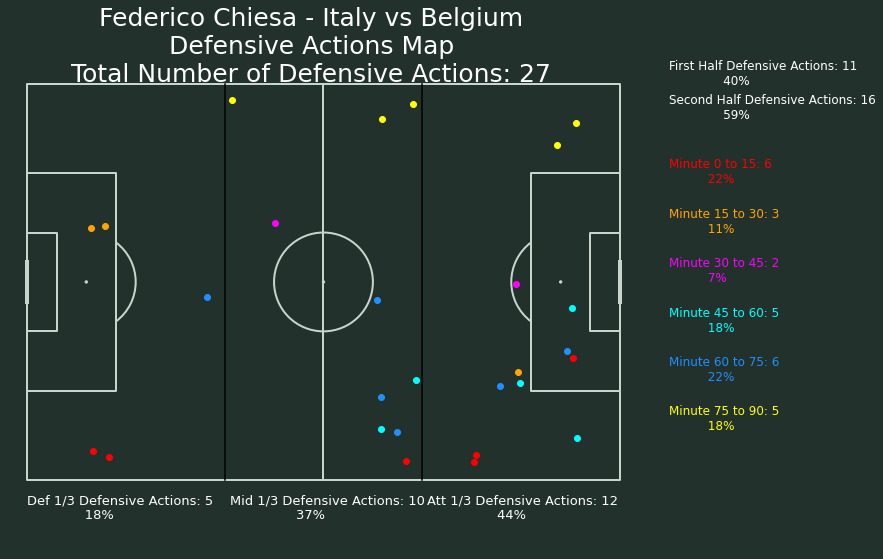

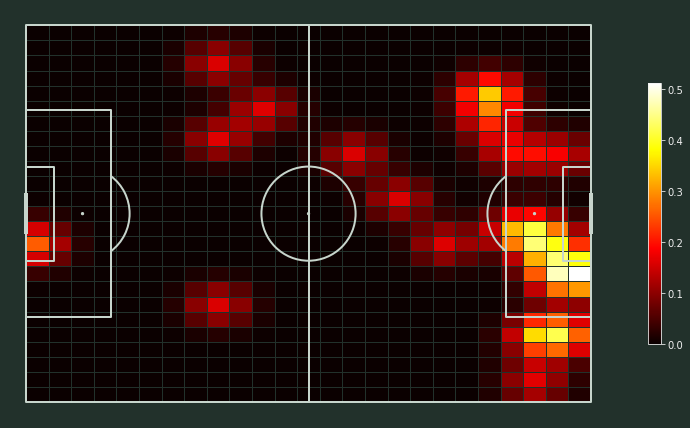

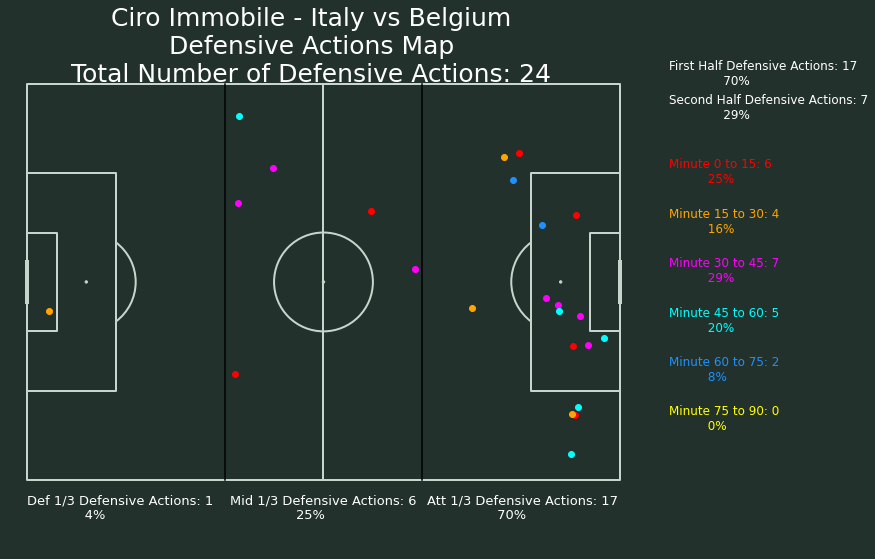

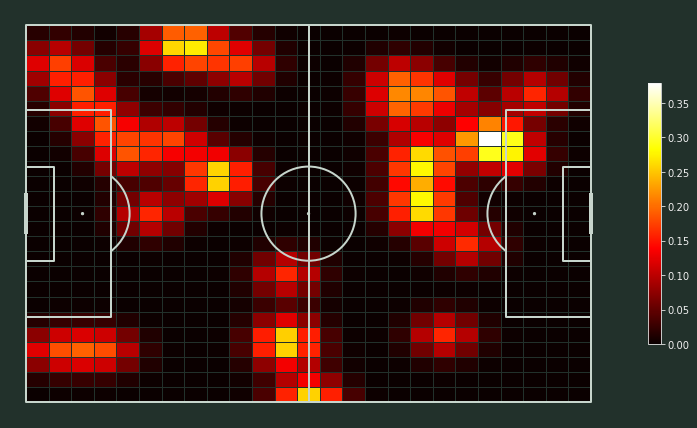

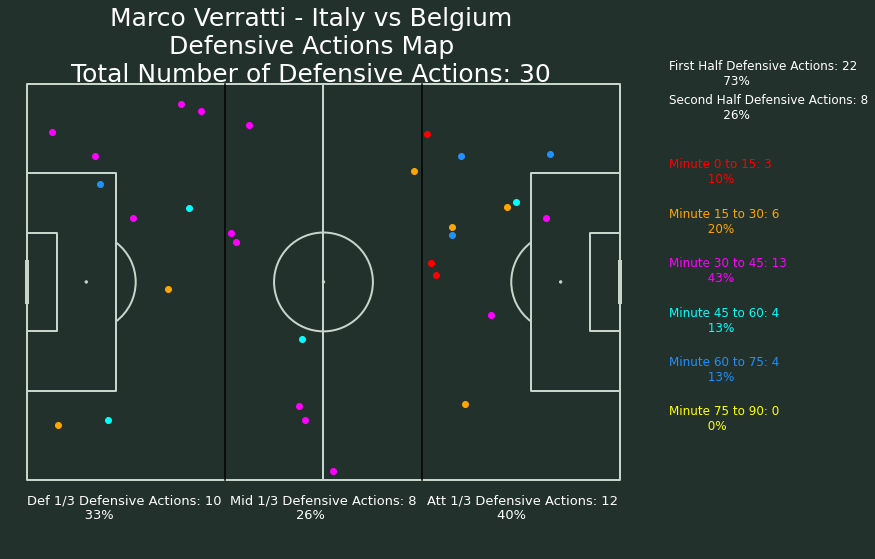

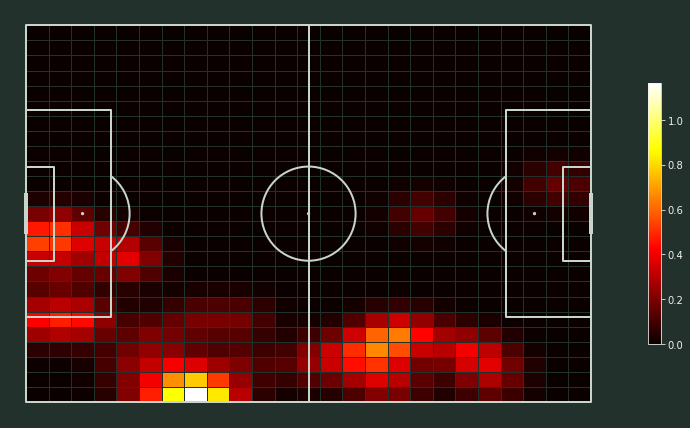

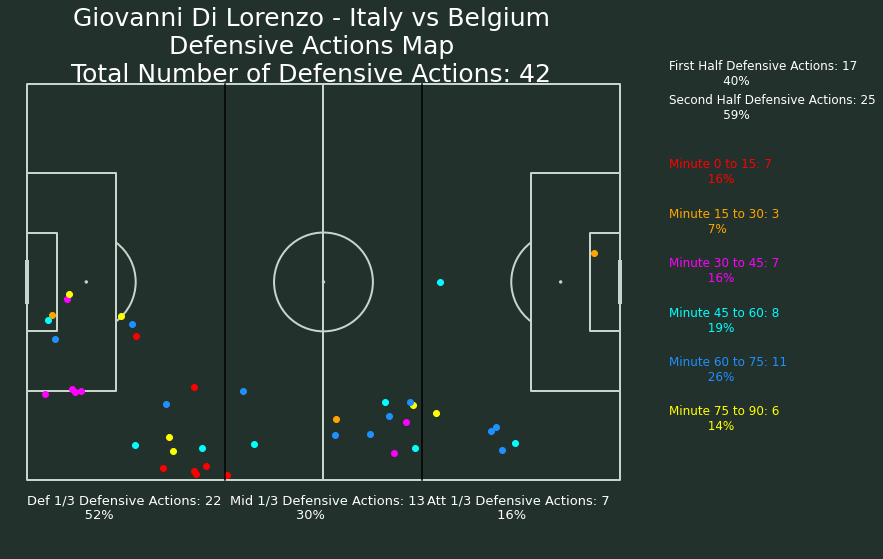

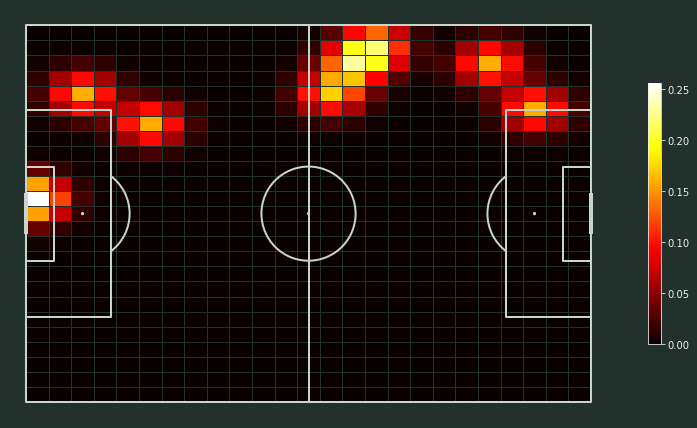

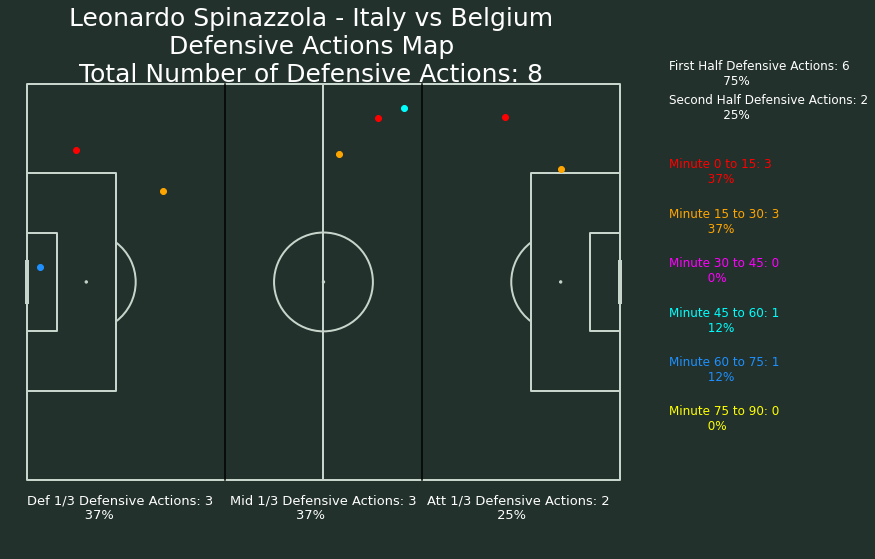

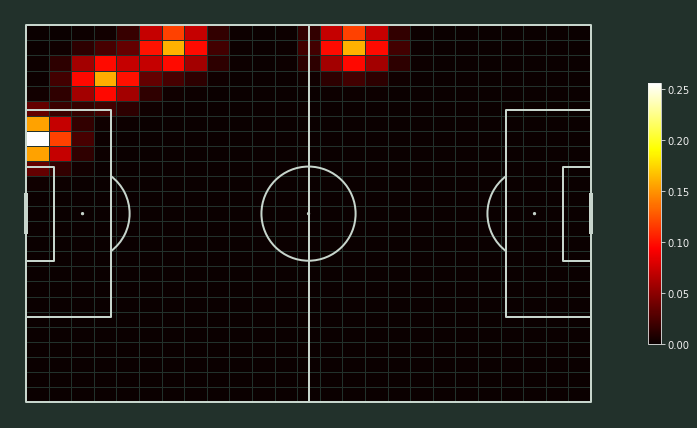

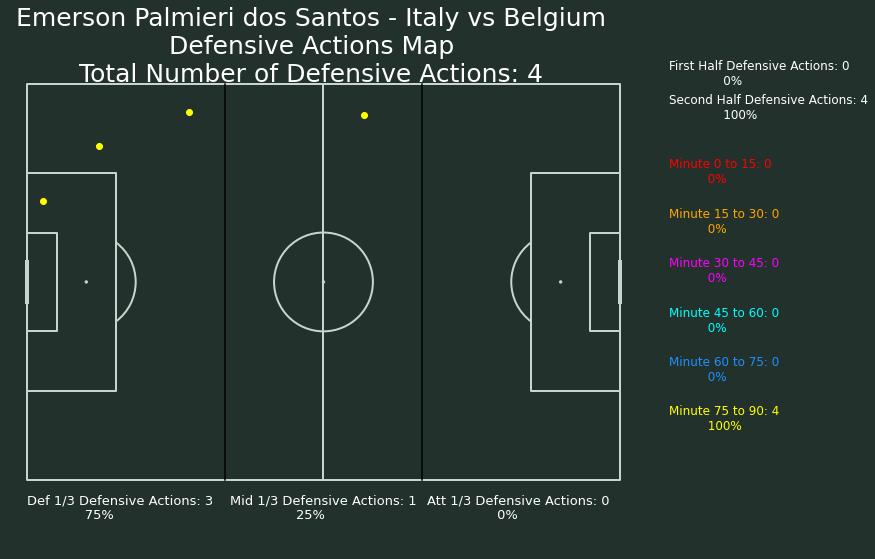

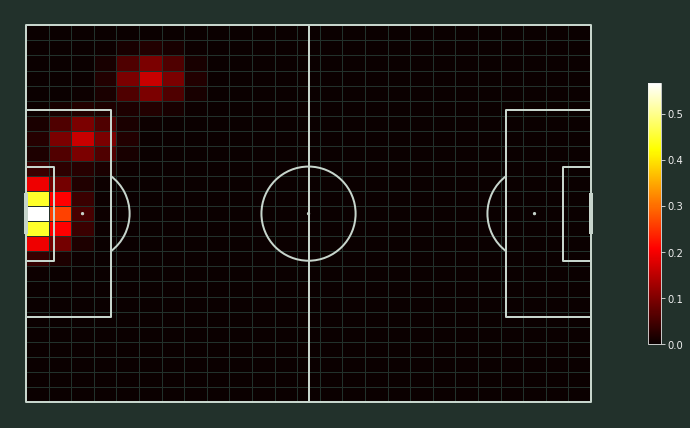

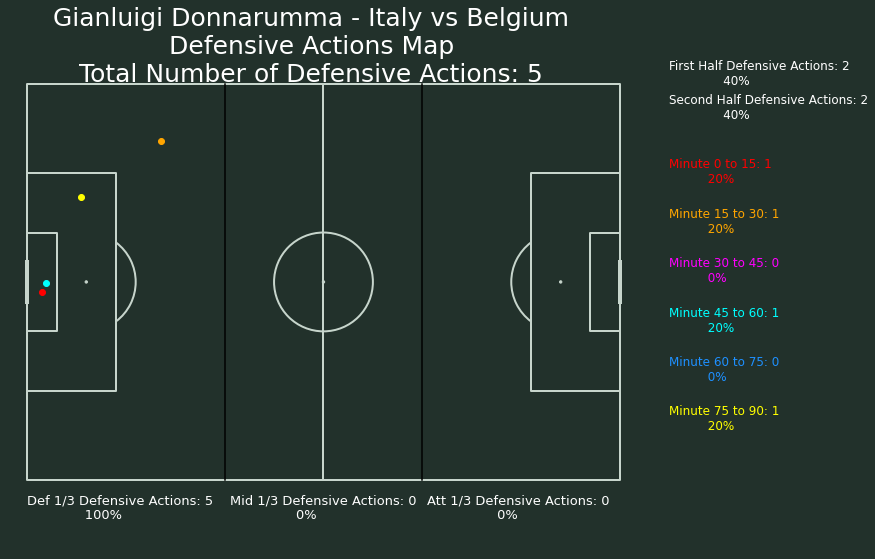

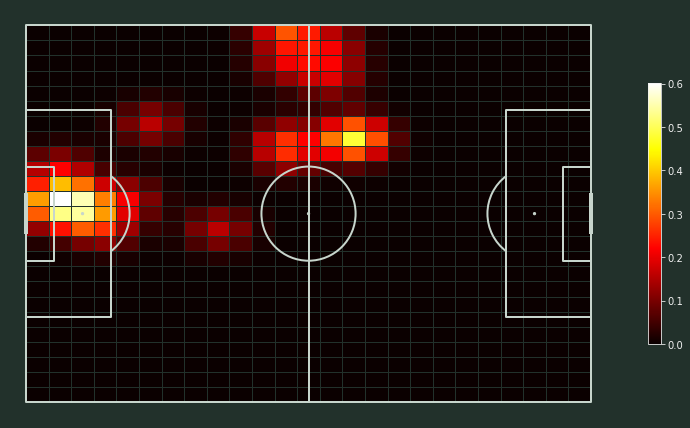

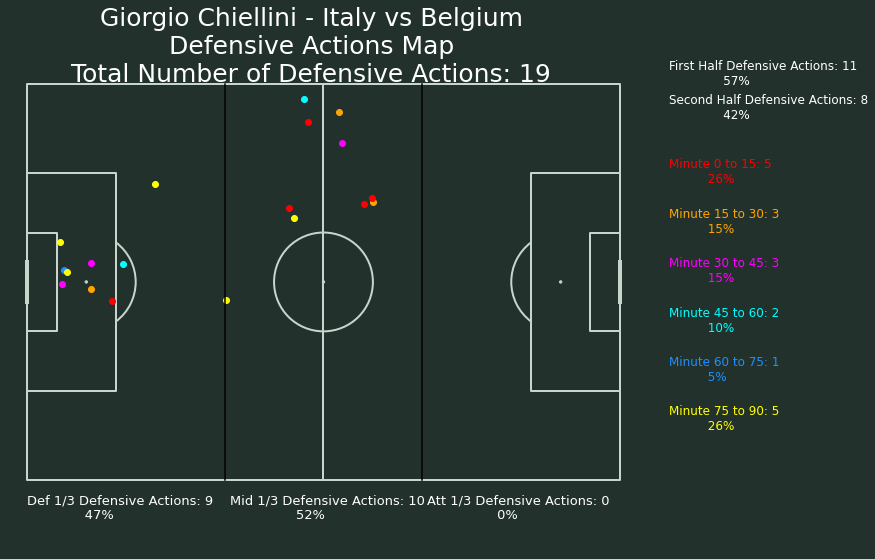

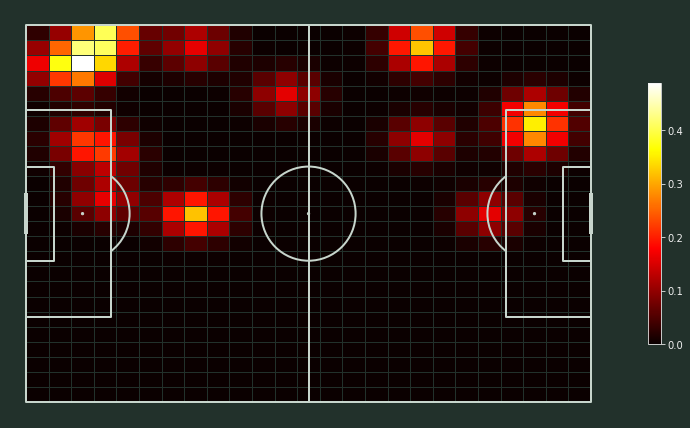

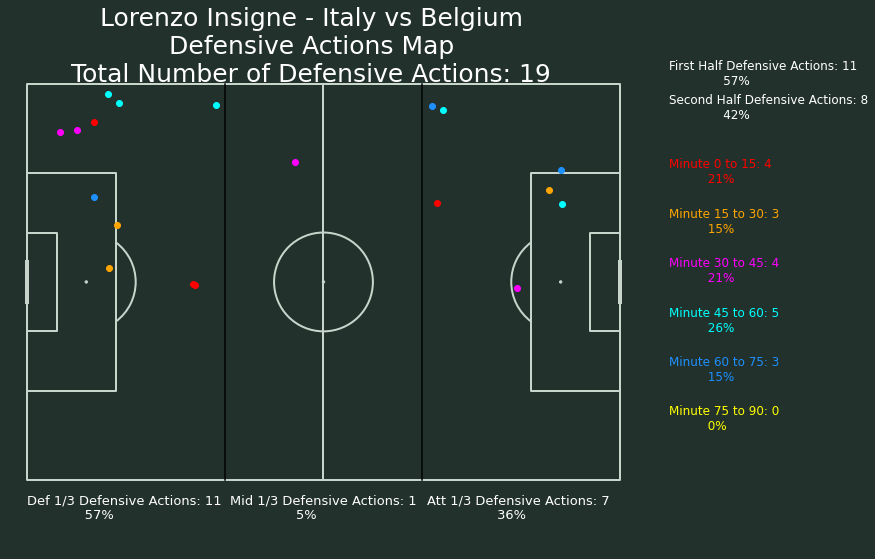

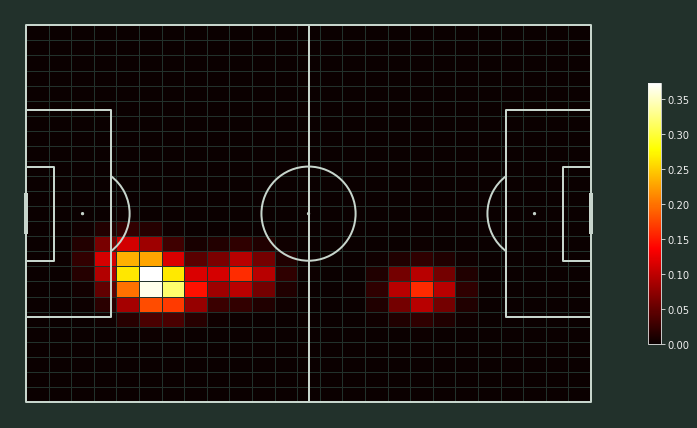

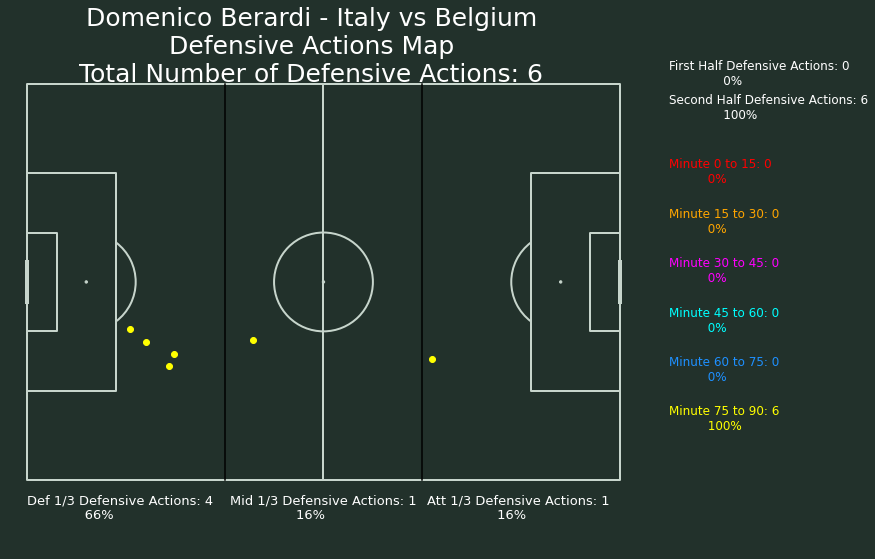

In [21]:
# Create by Italy player def actions vizz

# Italy - Belgium
itaBelDf = getEvents(3795107)

defActionsVizz(itaBelDf, 'Italy')

## Italy - Spain (3795220) Semi Final

### Pressures

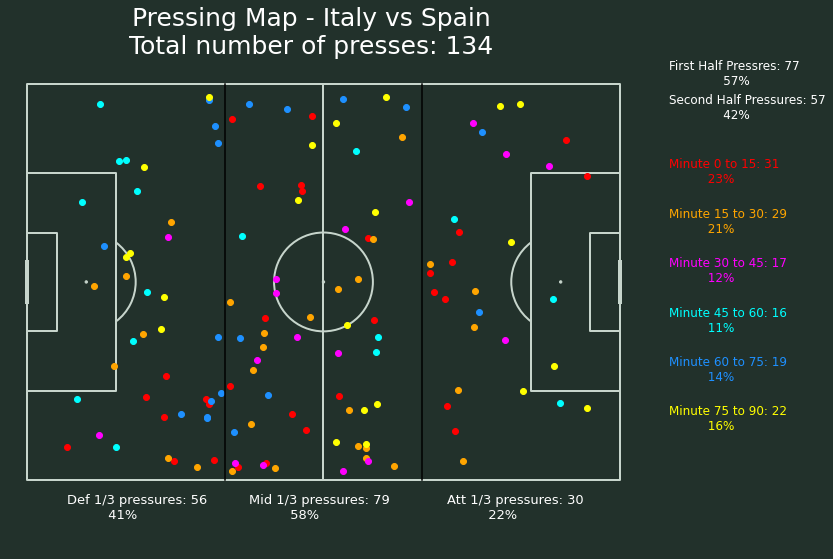

In [26]:
# Create Italy pressure vizz

# Italy - Spain
itaEspDf = getEvents(3795220)

pressureVizz(itaEspDf, 'Italy')

### Def Actions

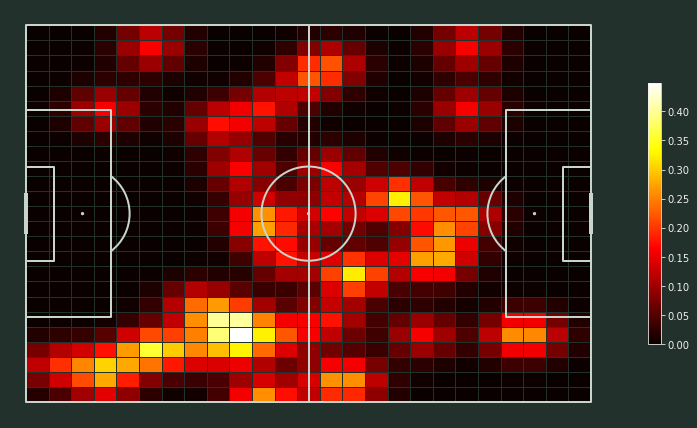

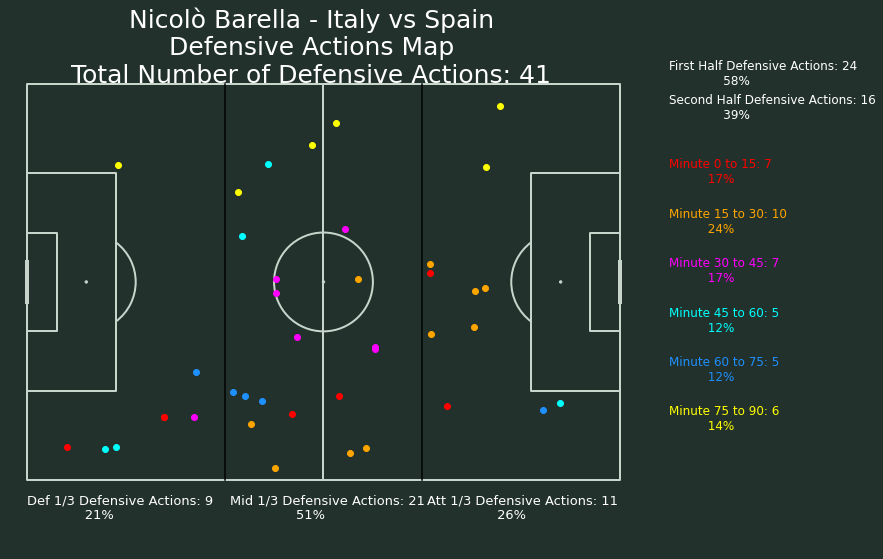

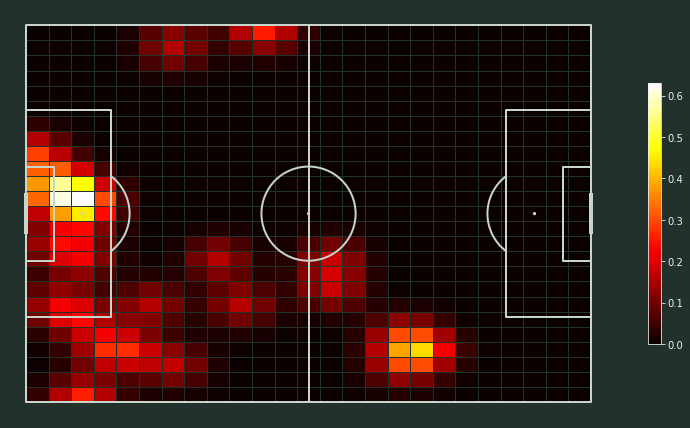

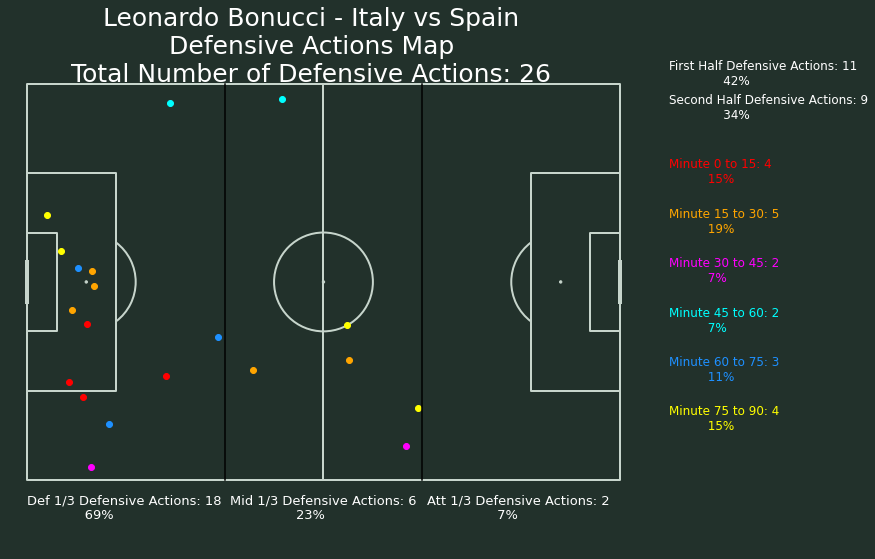

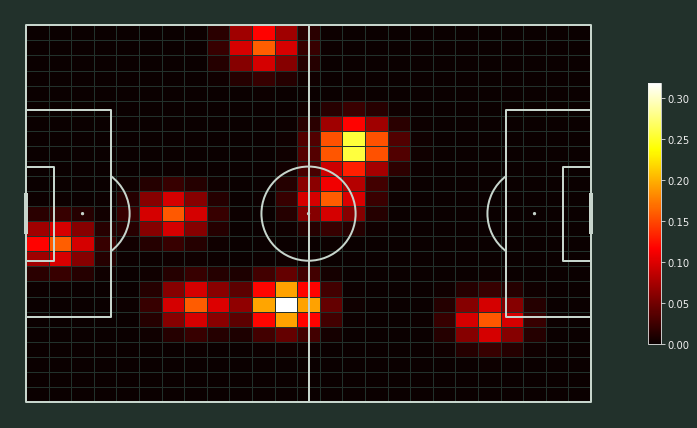

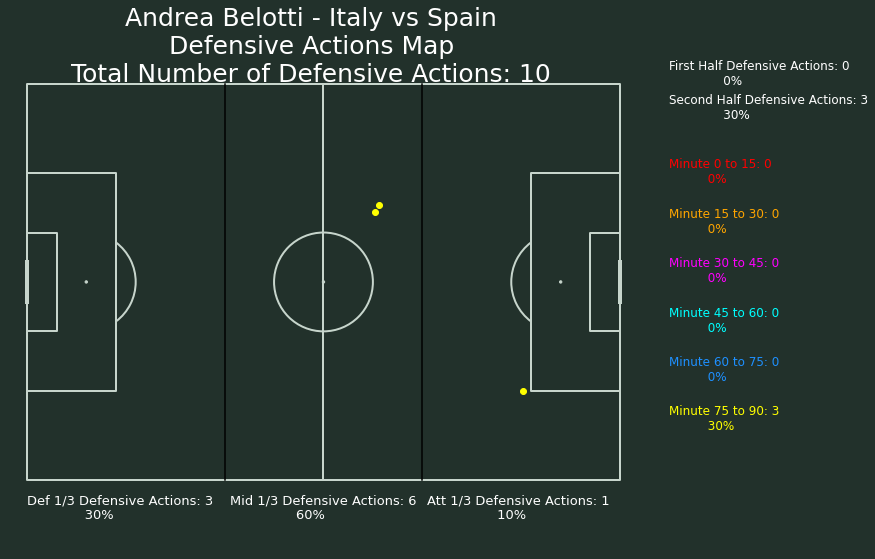

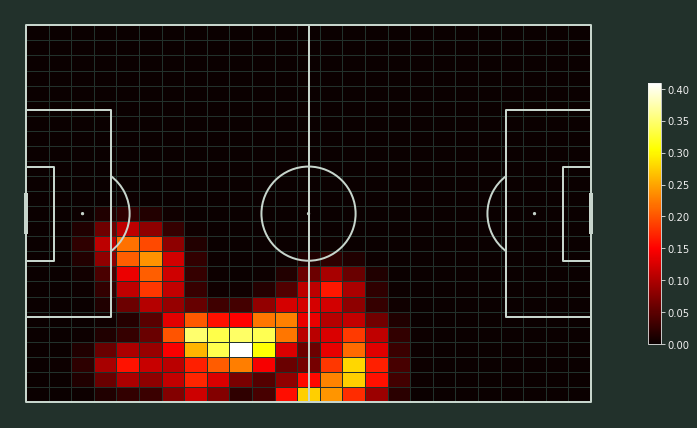

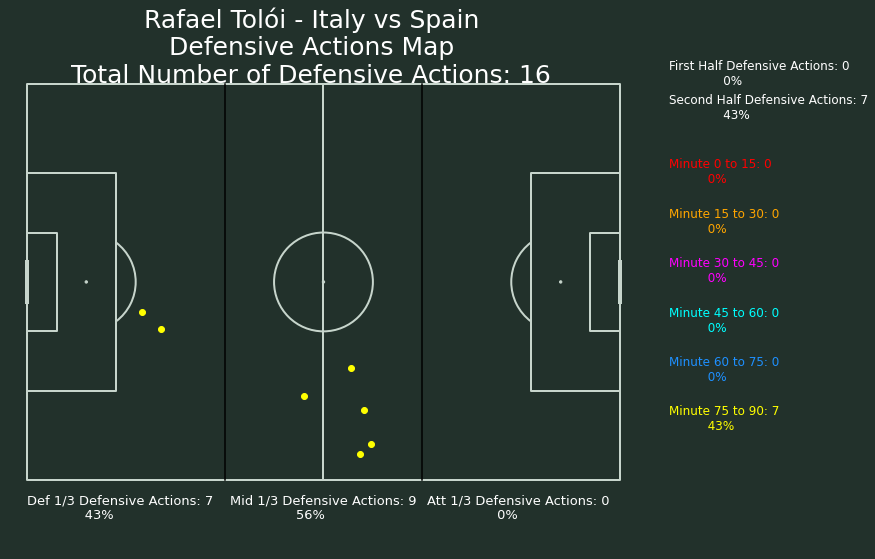

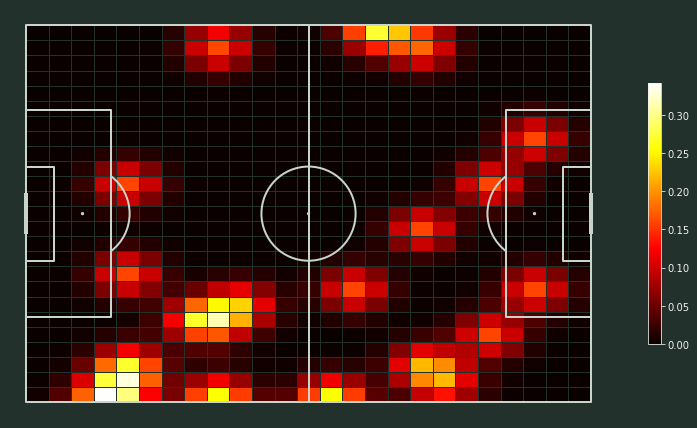

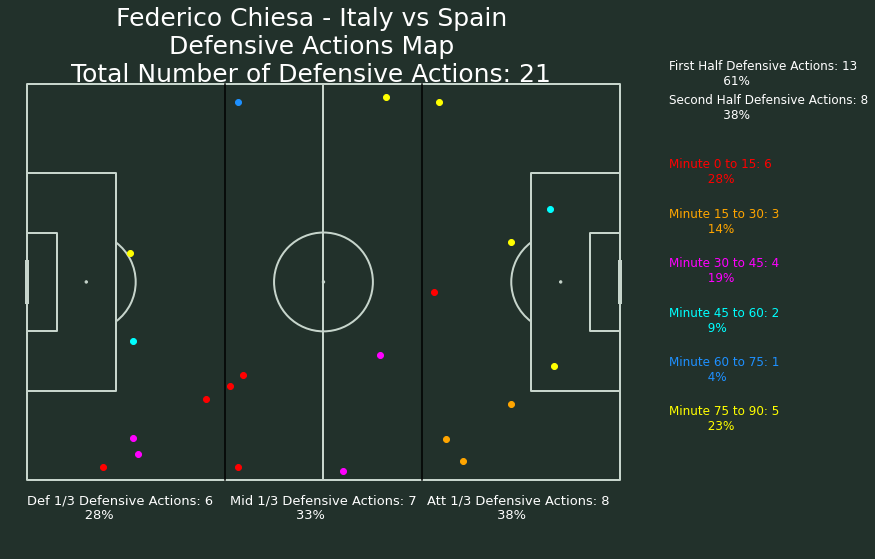

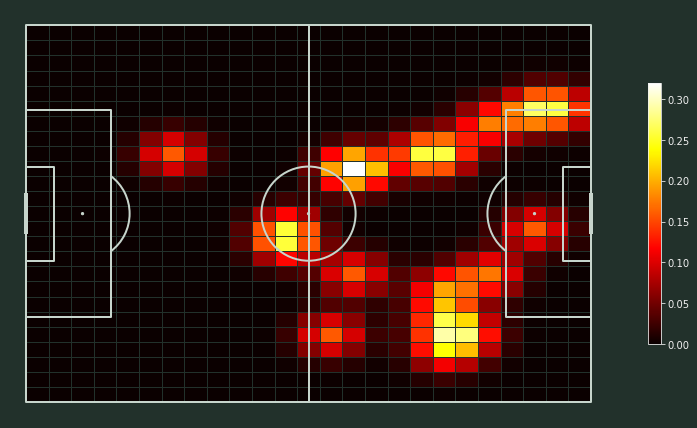

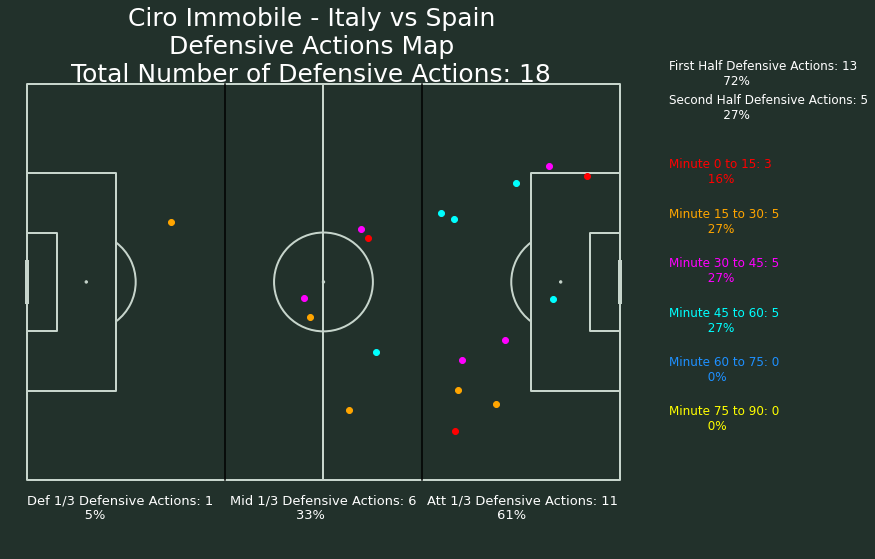

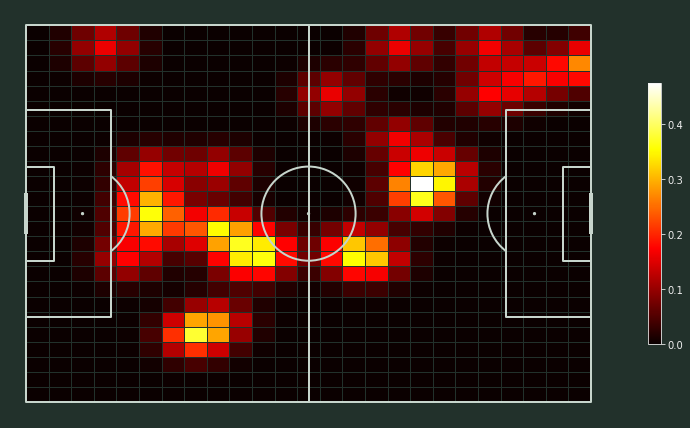

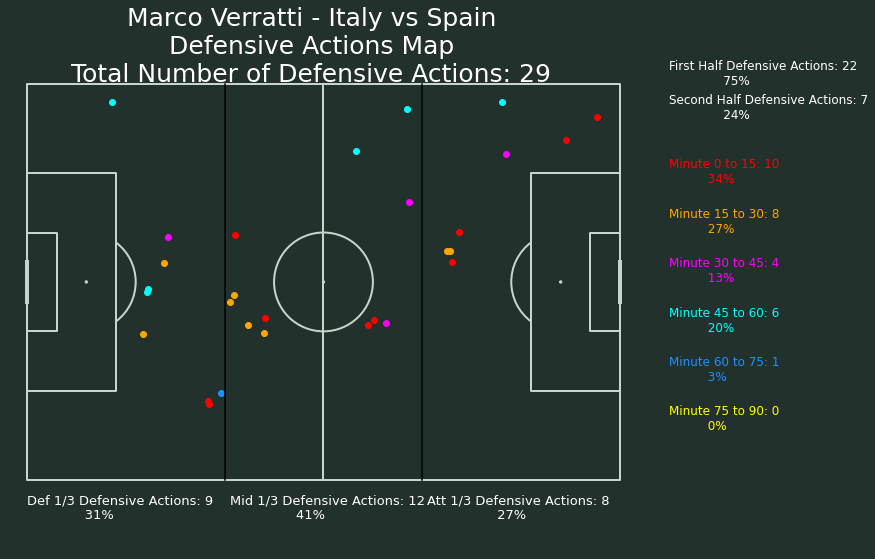

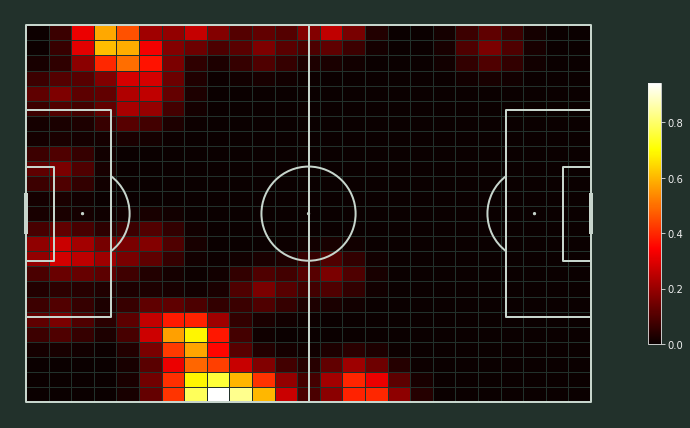

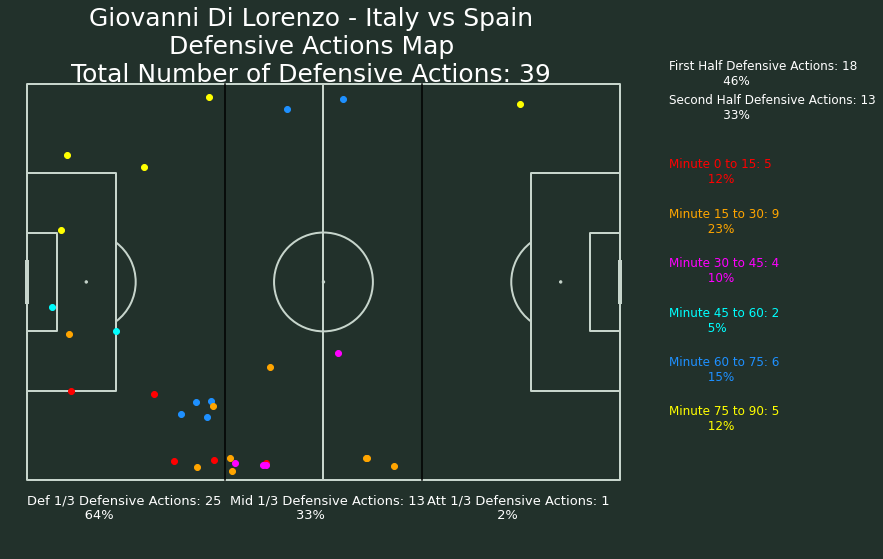

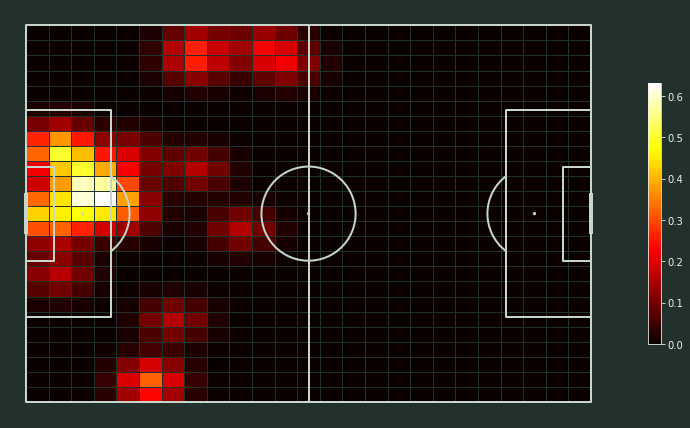

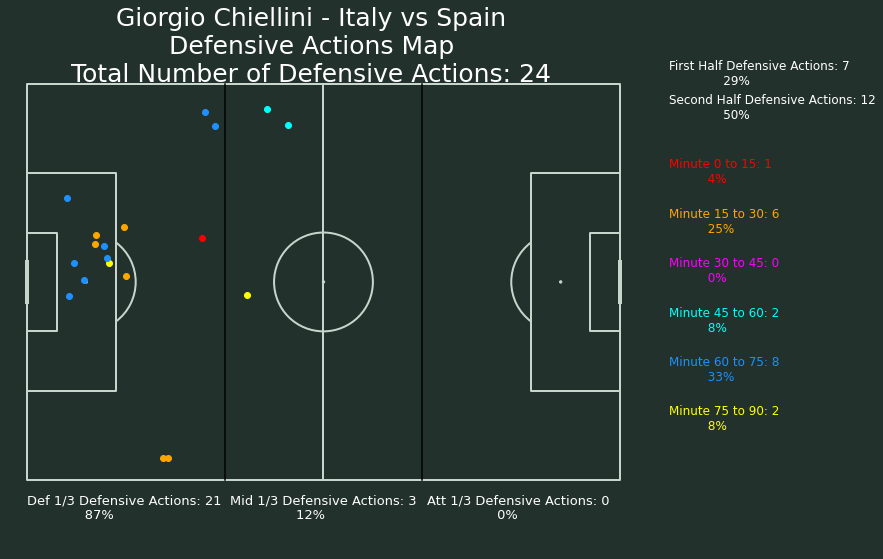

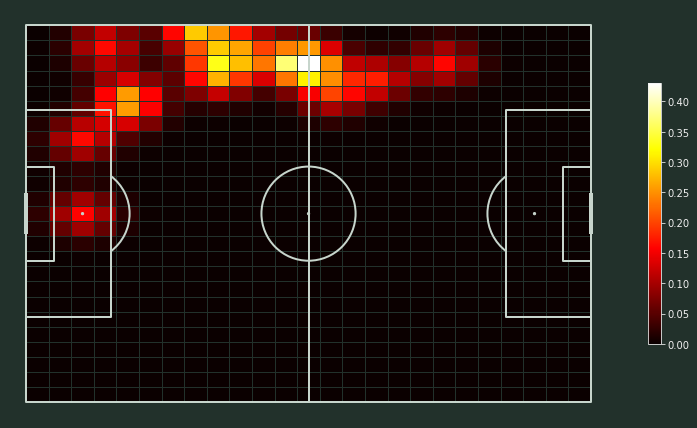

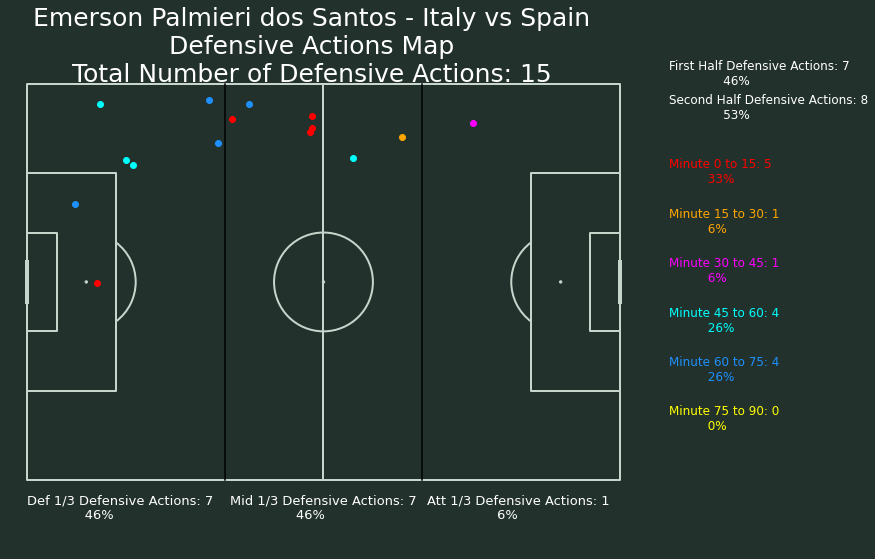

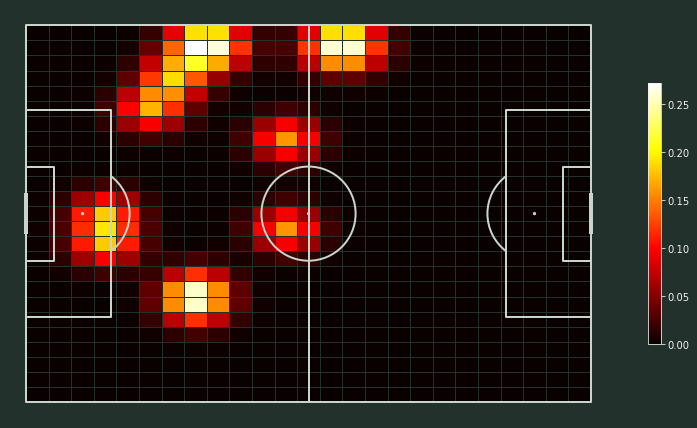

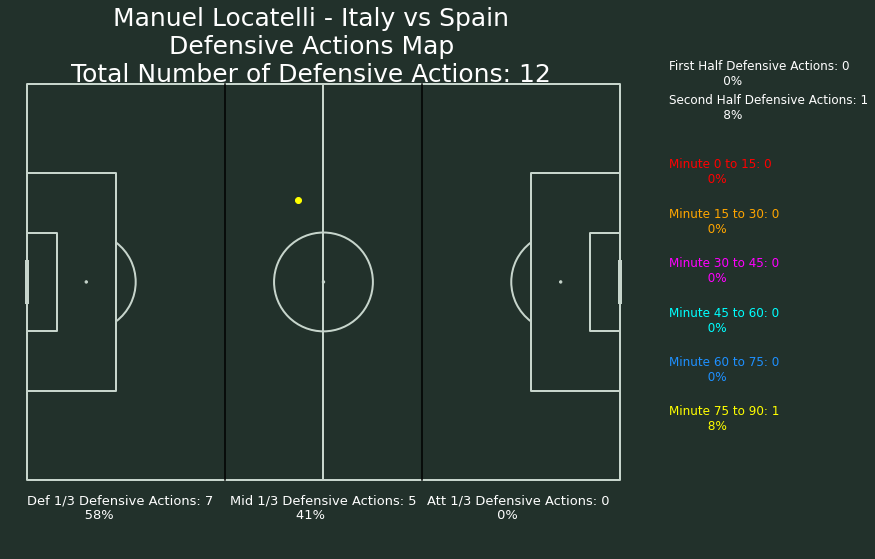

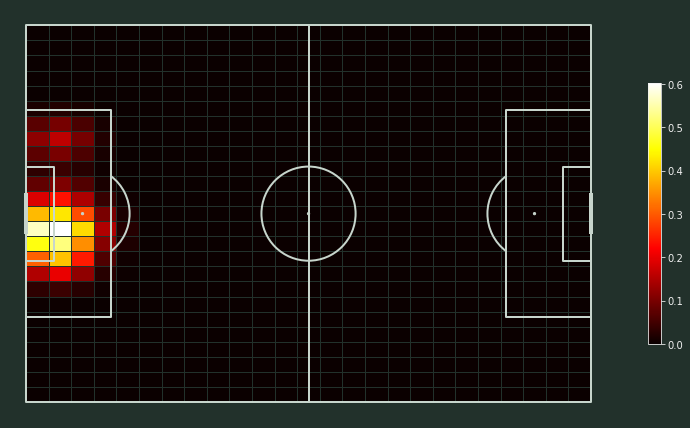

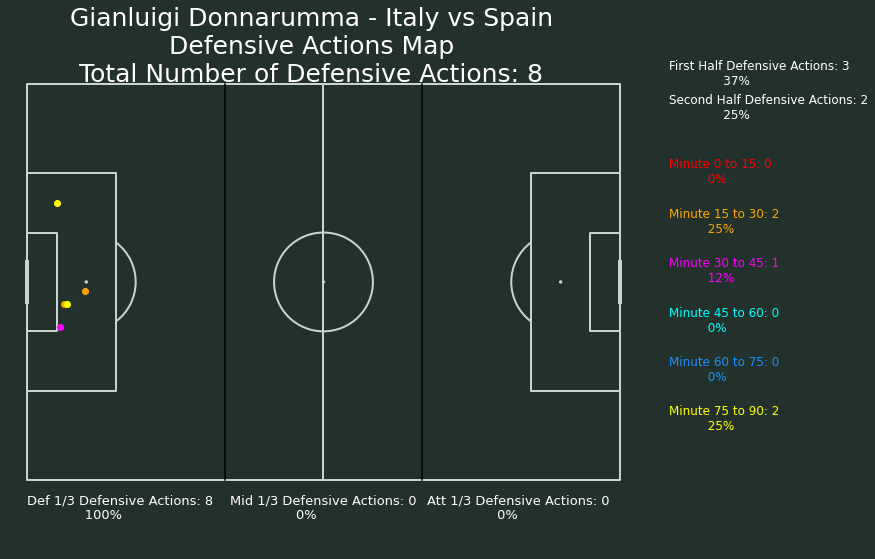

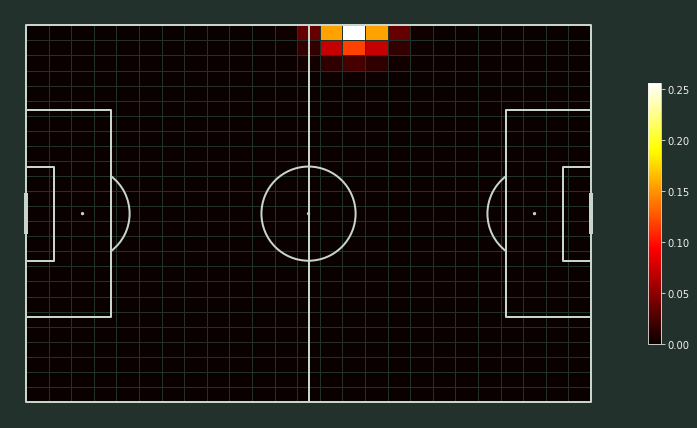

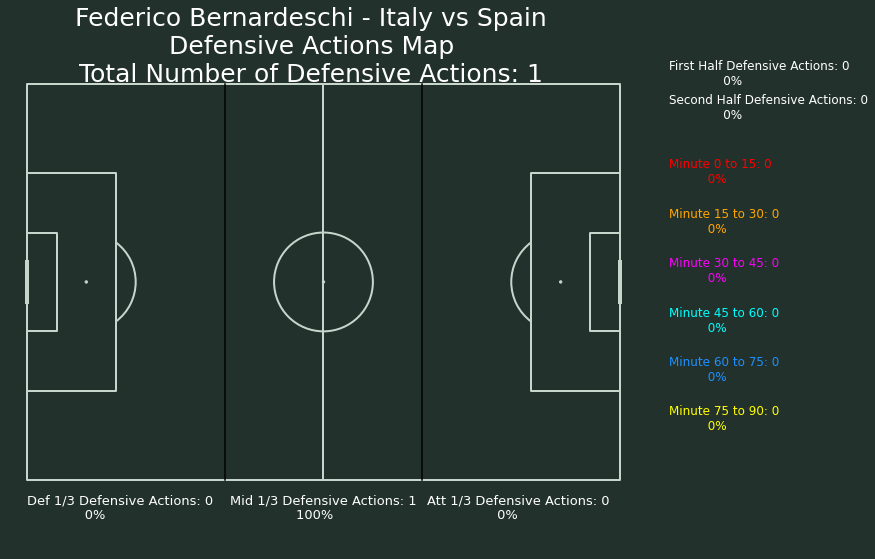

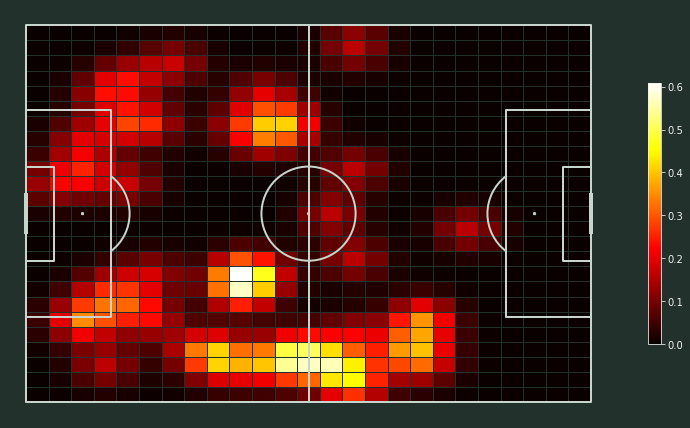

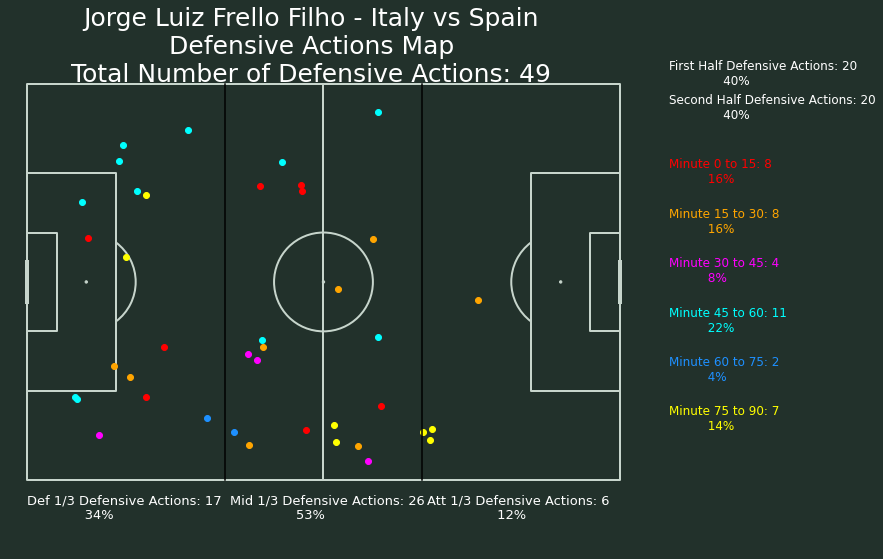

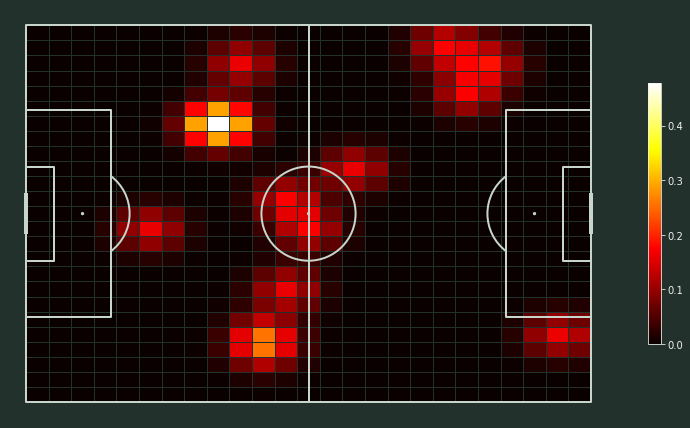

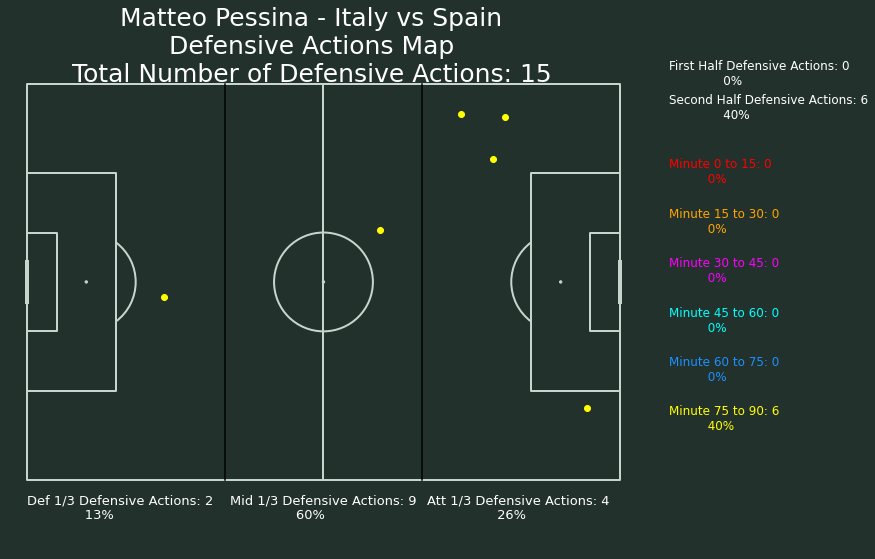

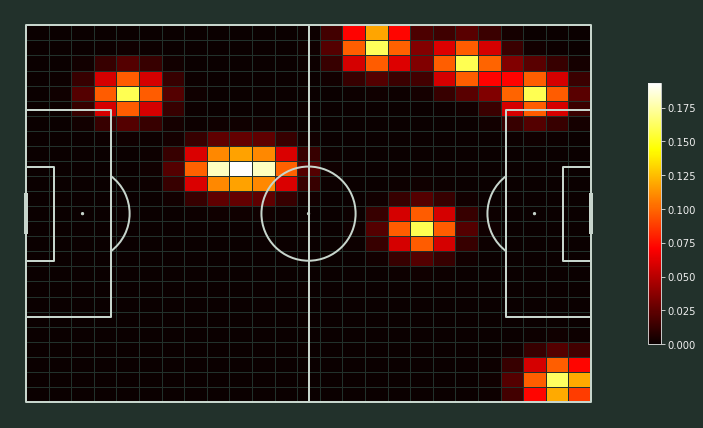

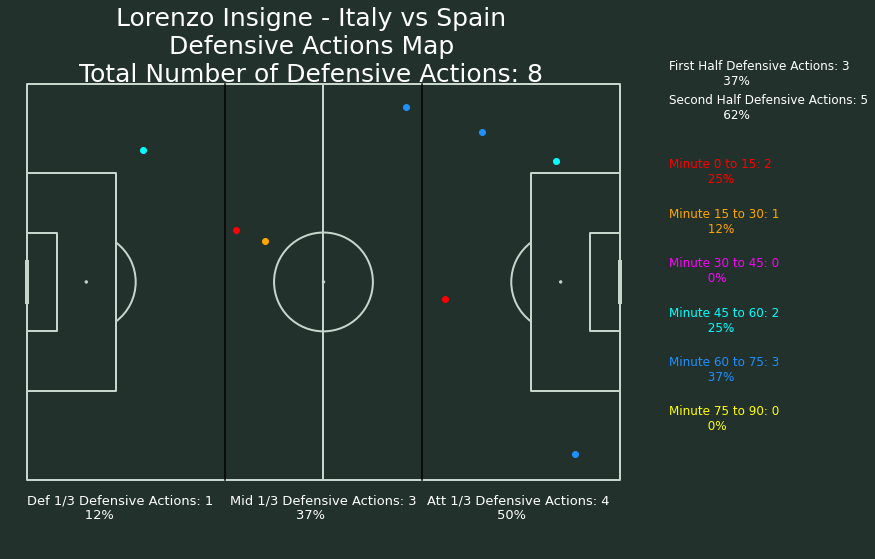

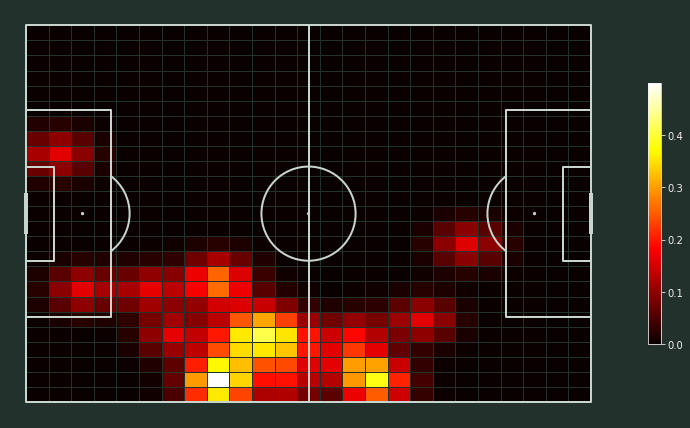

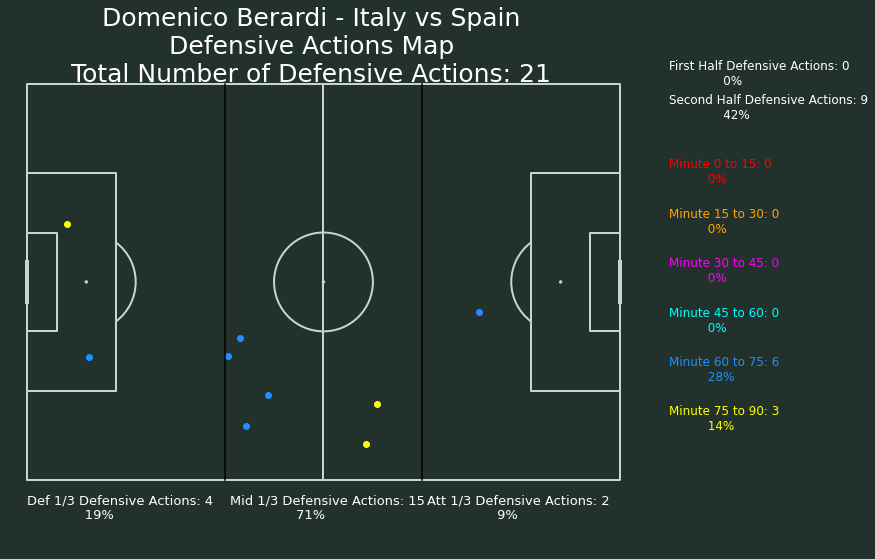

In [27]:
# Create by Italy player def actions vizz

# Italy - Spain
itaEspDf = getEvents(3795220)

defActionsVizz(itaEspDf, 'Italy')

## Italy - England (3795506) Final

In [23]:
# Find Italy matches
euroDf = sb.matches(55, 43)
itaDf = euroDf.loc[(euroDf['home_team'] == 'Italy') | (euroDf['away_team'] == 'Italy')]
itaDf.sort_values('match_date')

match_id  match_date      kick_off         competition season home_team  \
11   3788741  2021-06-11  21:00:00.000  Europe - UEFA Euro   2020    Turkey   
7    3788754  2021-06-16  21:00:00.000  Europe - UEFA Euro   2020     Italy   
3    3788766  2021-06-20  18:00:00.000  Europe - UEFA Euro   2020     Italy   
21   3794685  2021-06-26  21:00:00.000  Europe - UEFA Euro   2020     Italy   
34   3795107  2021-07-02  21:00:00.000  Europe - UEFA Euro   2020   Belgium   
0    3795220  2021-07-06  21:00:00.000  Europe - UEFA Euro   2020     Italy   
16   3795506  2021-07-11  21:00:00.000  Europe - UEFA Euro   2020     Italy   

      away_team  home_score  away_score match_status  ...  last_updated_360  \
11        Italy           0           3    available  ...  2022-08-04T12:00   
7   Switzerland           3           0    available  ...  2022-08-04T12:00   
3         Wales           1           0    available  ...  2022-08-04T12:00   
21      Austria           2           1    available  ...  2022-08-04T12:00   
34        Italy           1           2    available  ...  2022-08-04T12:00   
0         Spain           1           1    available  ...  2022-08-04T12:00   
16      England           1           1    available  ...  2022-08-04T12:00   

   match_week competition_stage           stadium                 referee  \
11          1       Group Stage  Estadio Olímpico  Danny Desmond Makkelie   
7           2       Group Stage  Estadio Olímpico          Sergey Karasev   
3           3       Group Stage  Estadio Olímpico     Ovidiu Alin Hațegan   
21          4       Round of 16   Wembley Stadium          Anthony Taylor   
34          5    Quarter-finals     Allianz Arena           Slavko Vinčić   
0           6       Semi-finals   Wembley Stadium             Felix Brych   
16          7             Final   Wembley Stadium           Björn Kuipers   

                home_managers                 away_managers data_version  \
11                Şenol Güneş               Roberto Mancini        1.1.0   
7             Roberto Mancini             Vladimir Petković        1.1.0   
3                                                                  1.1.0   
21            Roberto Mancini                   Franco Foda        1.1.0   
34  Roberto Martínez Montoliú               Roberto Mancini        1.1.0   
0             Roberto Mancini  Luis Enrique Martínez García        1.1.0   
16            Roberto Mancini              Gareth Southgate        1.1.0   

   shot_fidelity_version xy_fidelity_version  
11                     2                   2  
7                      2                   2  
3                      2                   2  
21                     2                   2  
34                     2                   2  
0                      2                   2  
16                     2                   2  

[7 rows x 22 columns]

### Pressures

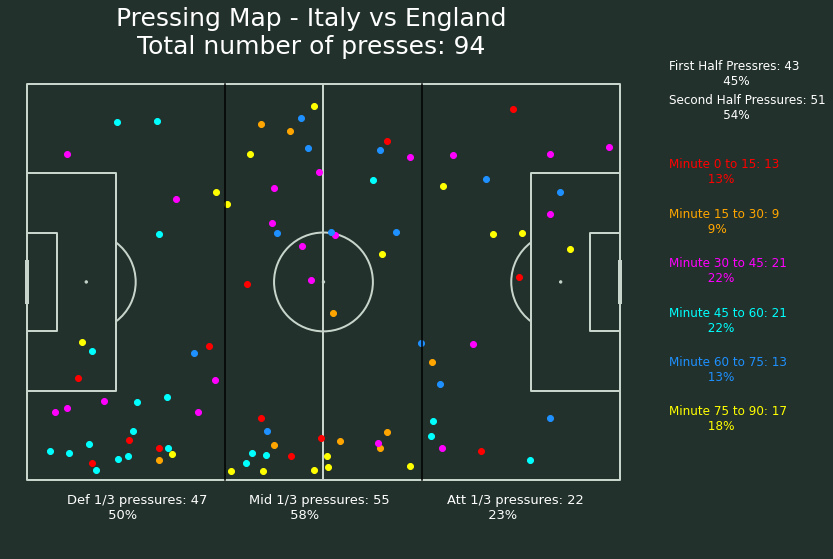

In [28]:
# Create Italy pressure vizz

# Italy - England
itaEngDf = getEvents(3795506)

pressureVizz(itaEngDf, 'Italy')

### Def Actions

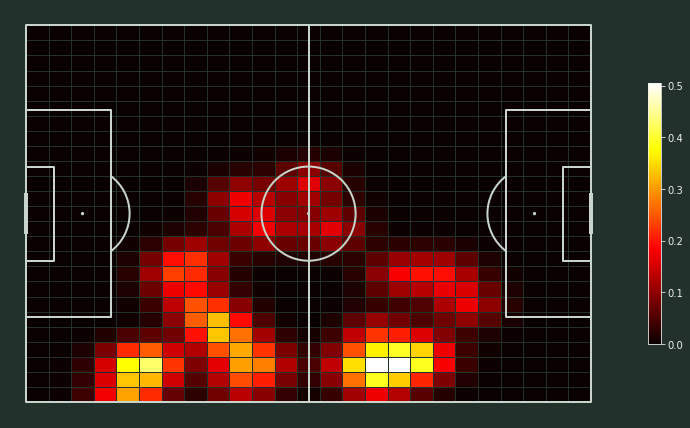

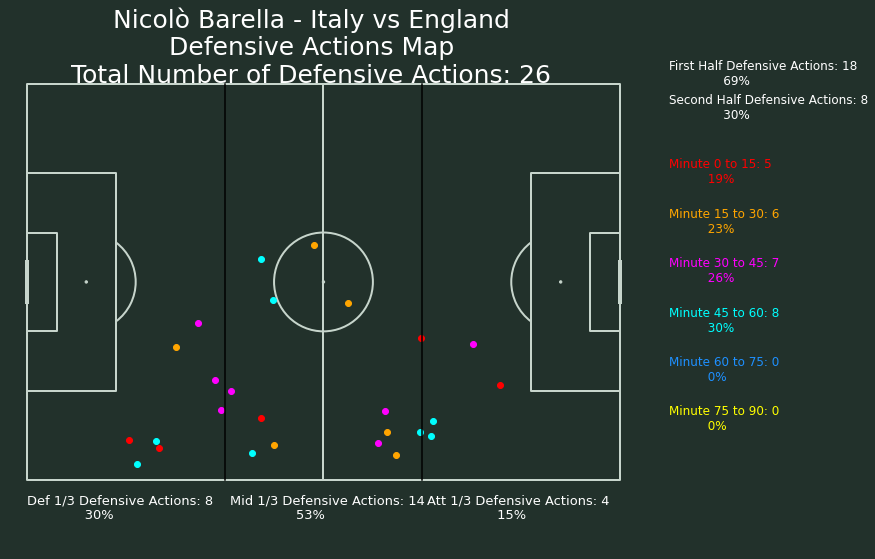

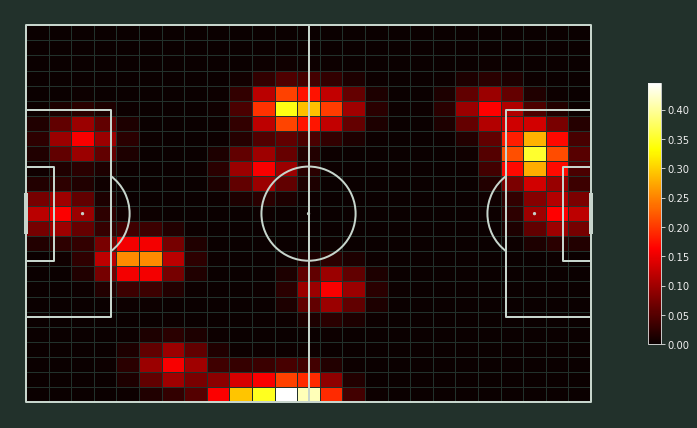

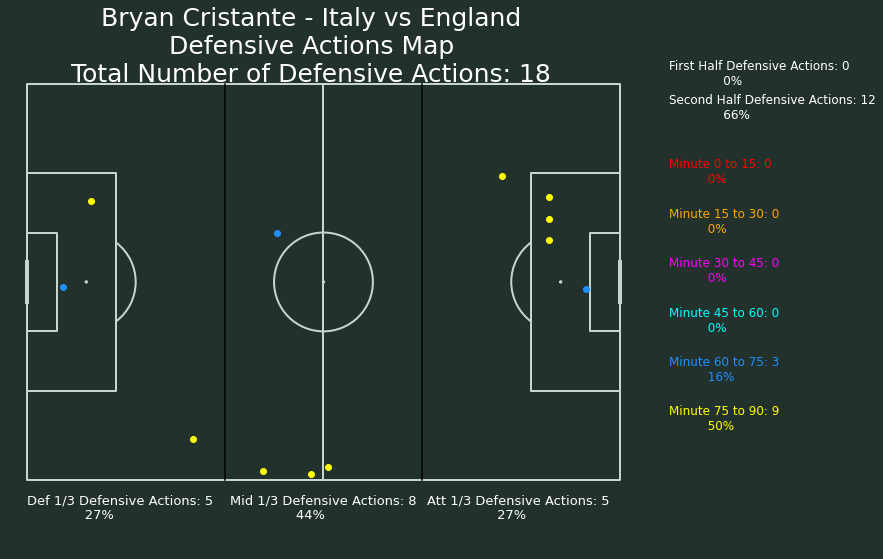

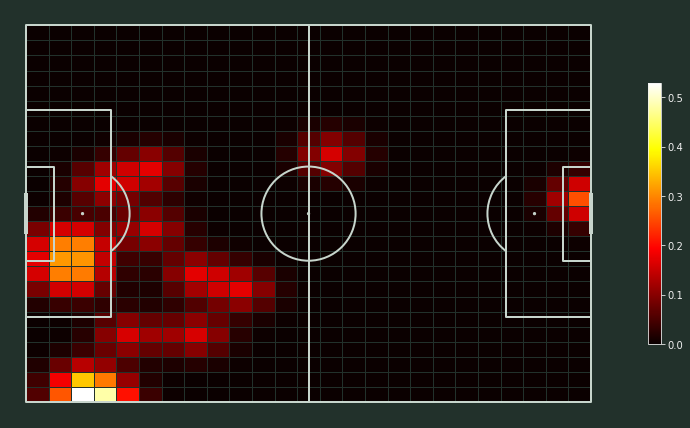

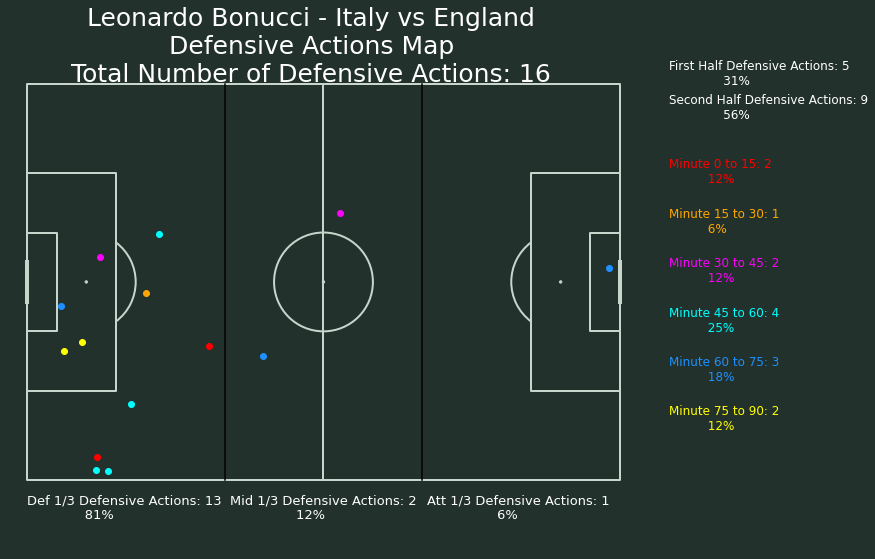

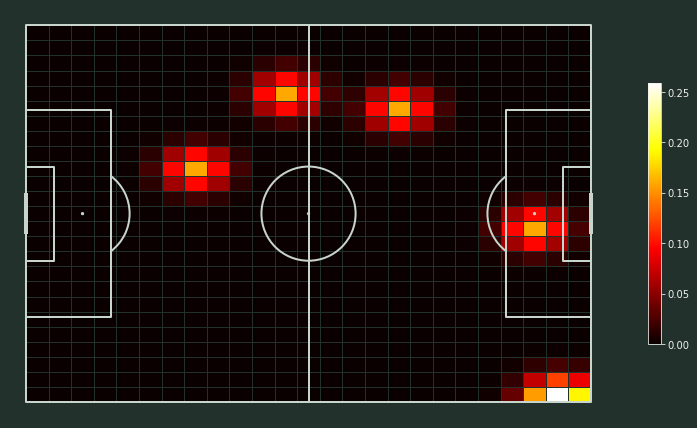

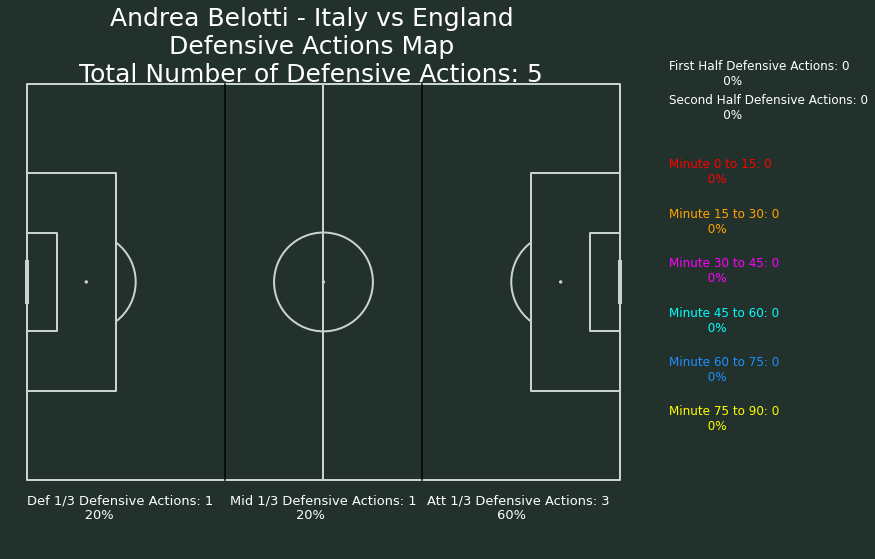

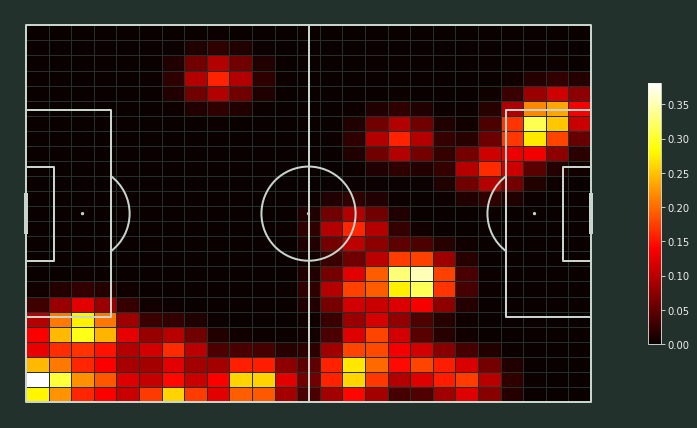

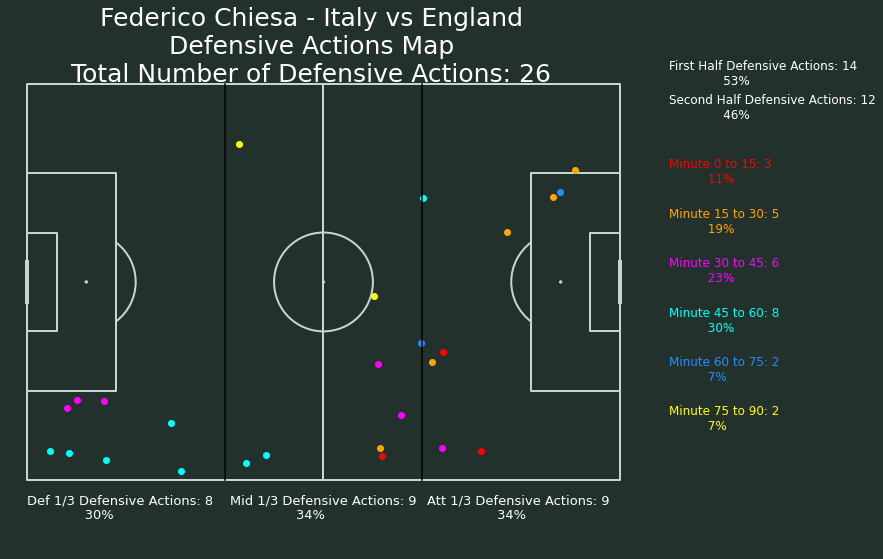

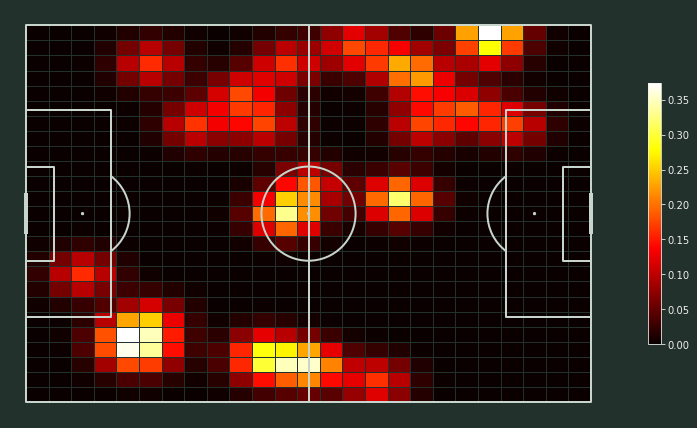

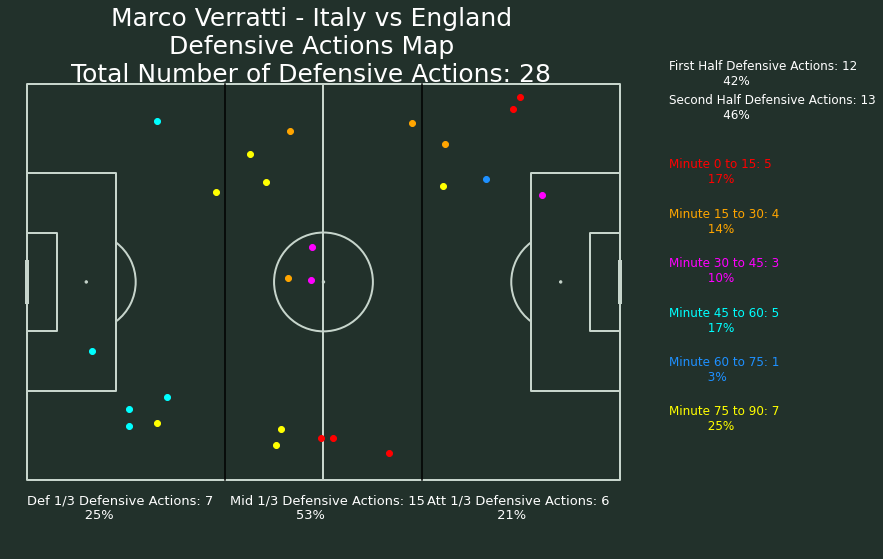

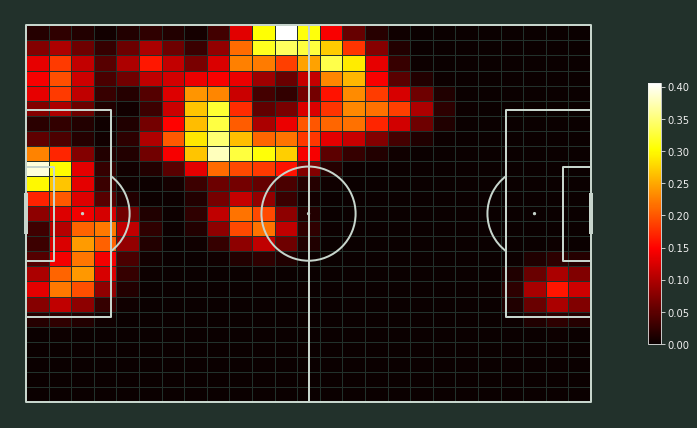

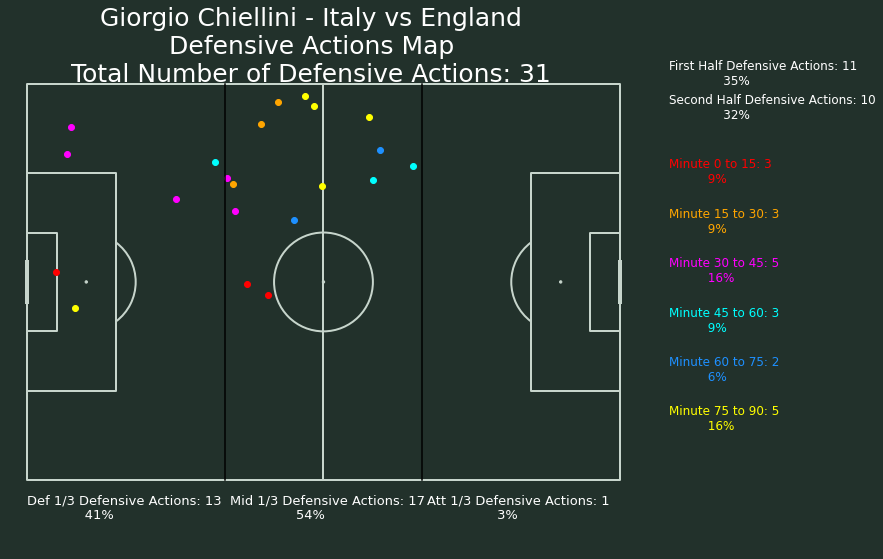

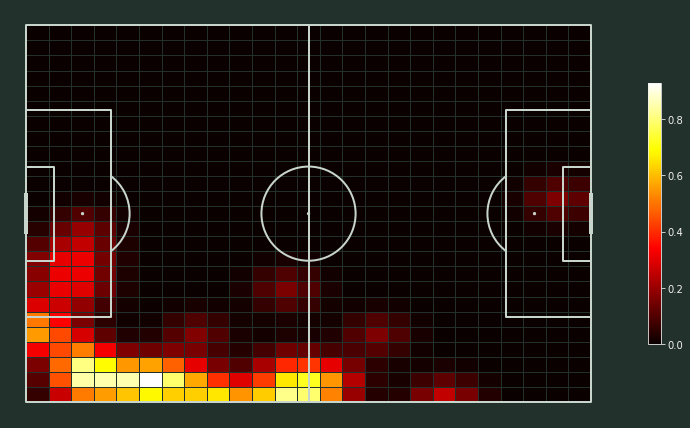

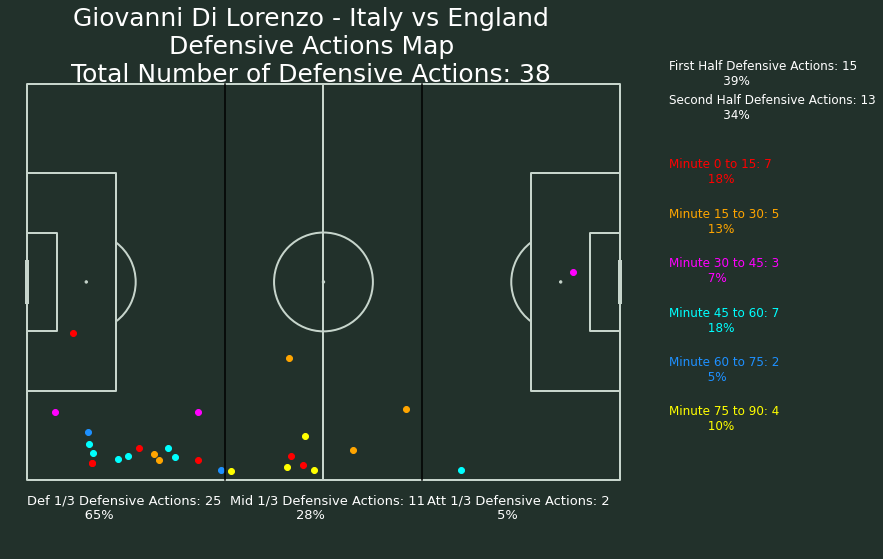

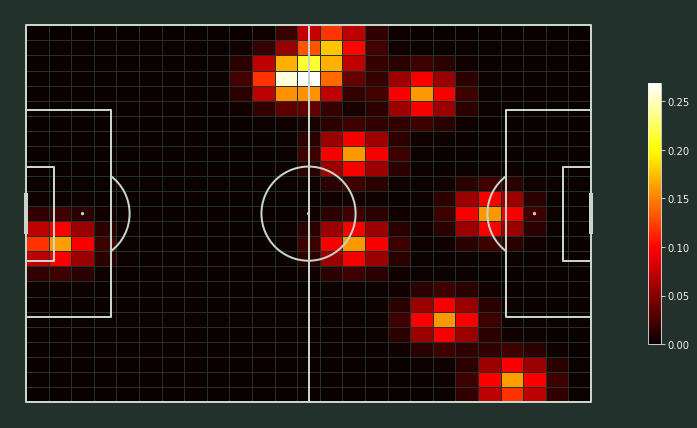

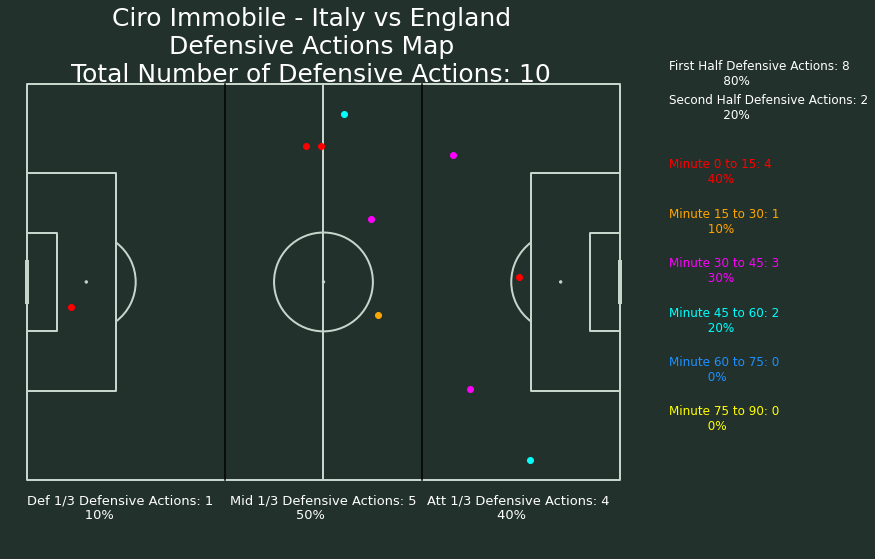

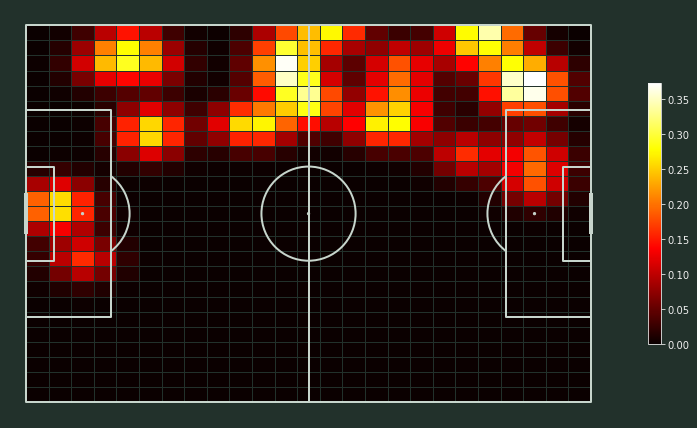

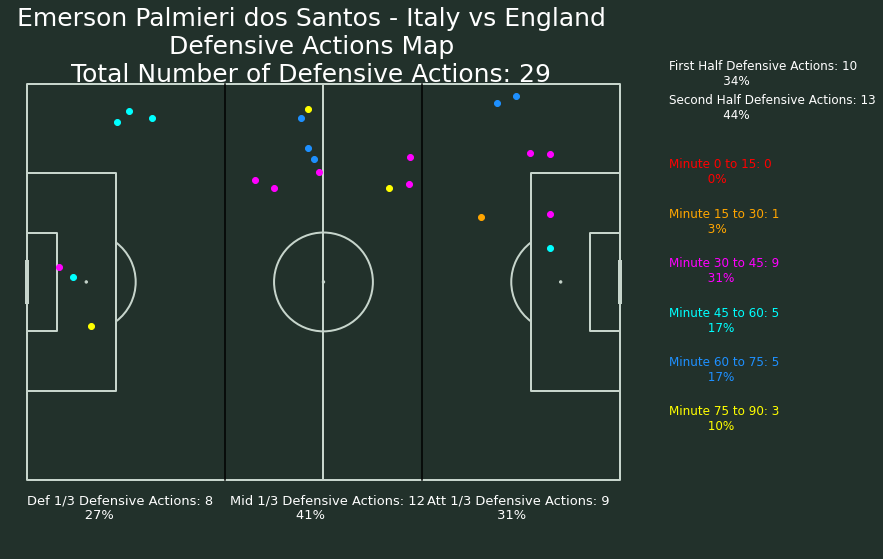

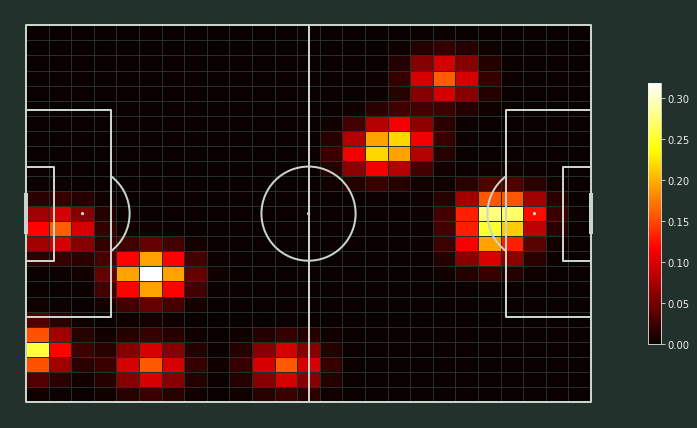

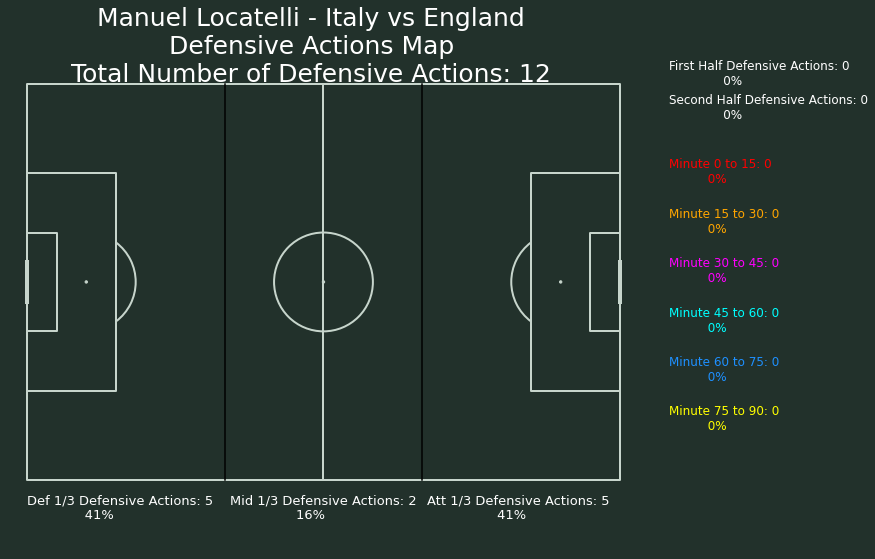

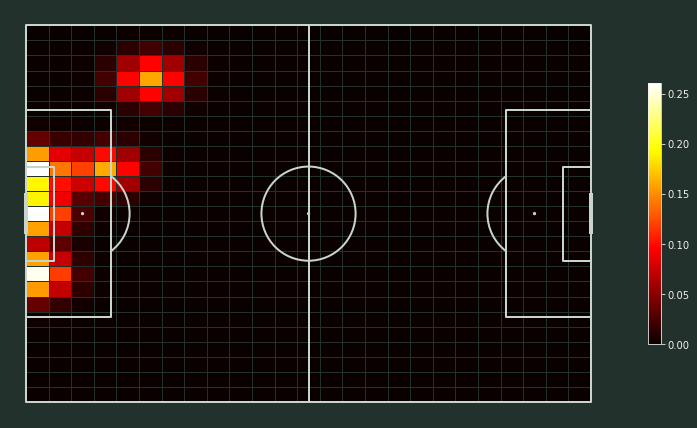

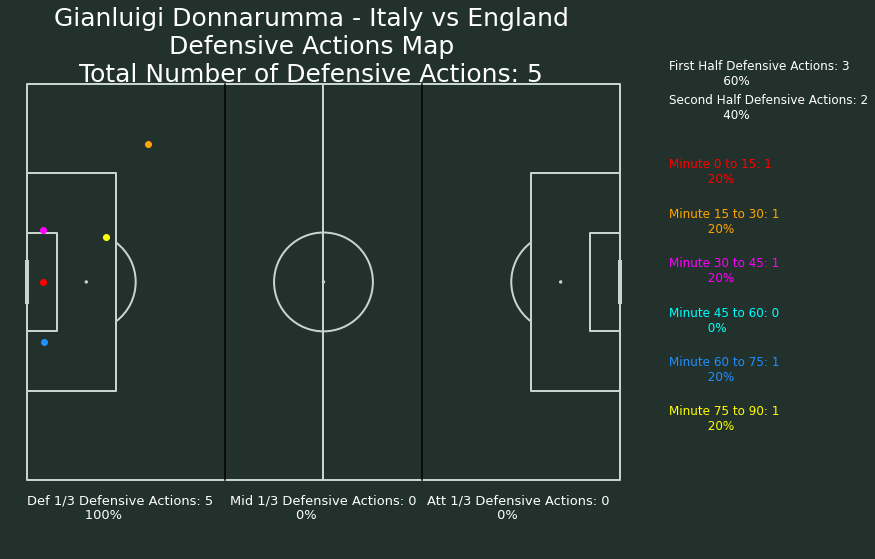

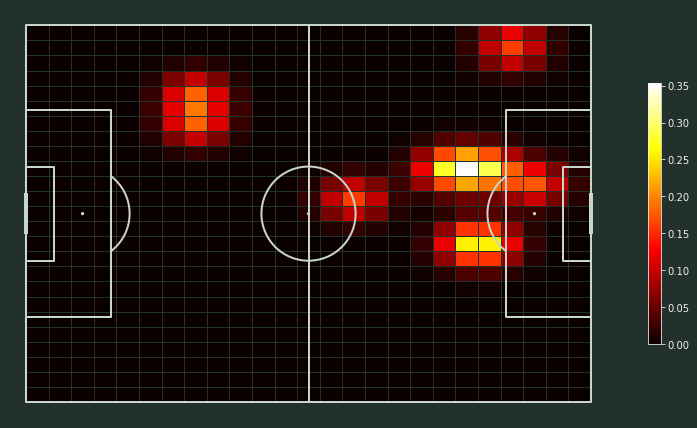

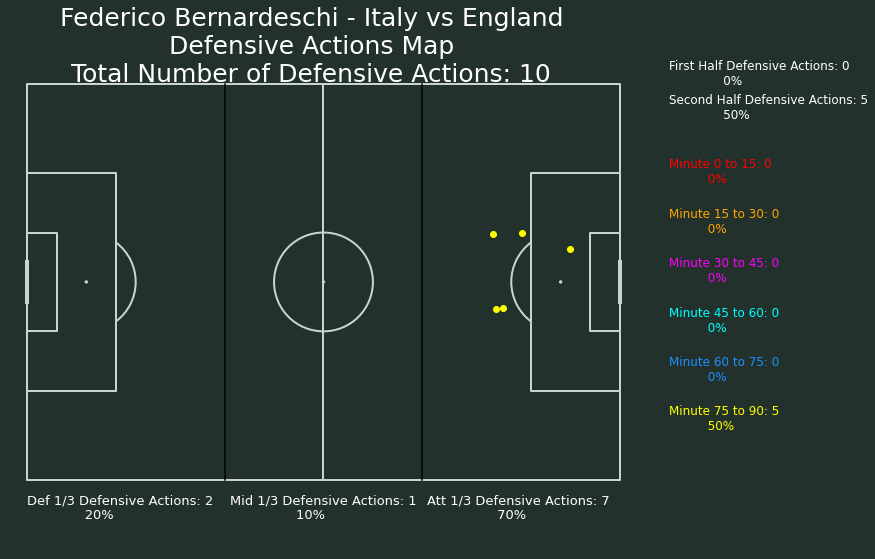

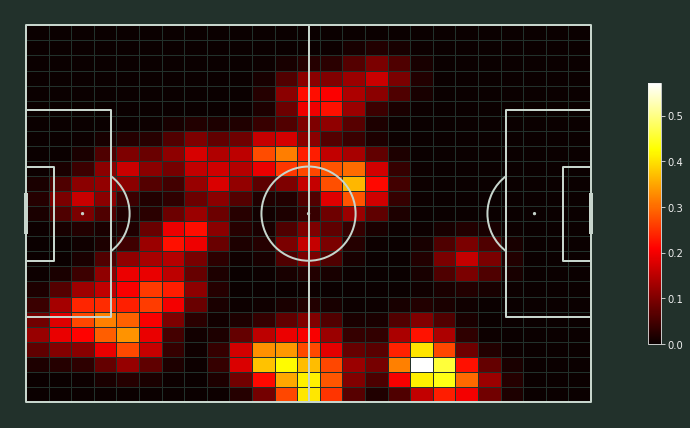

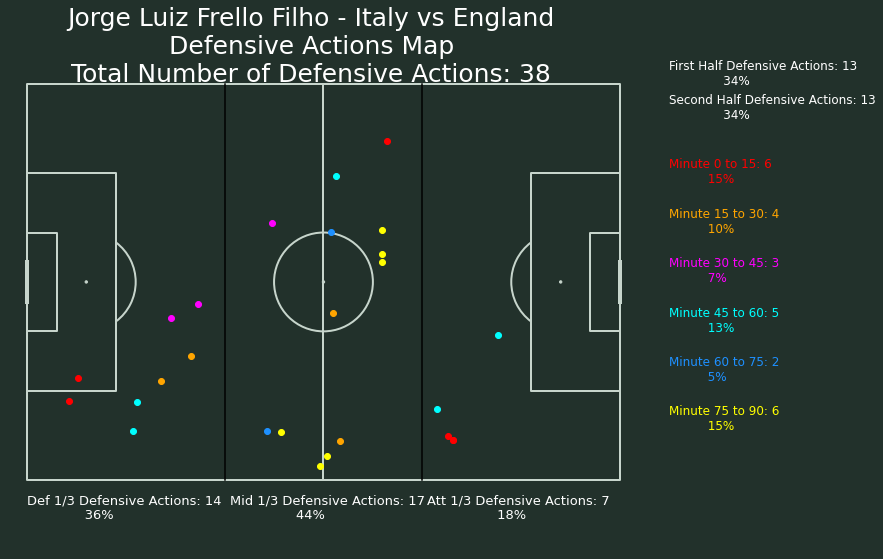

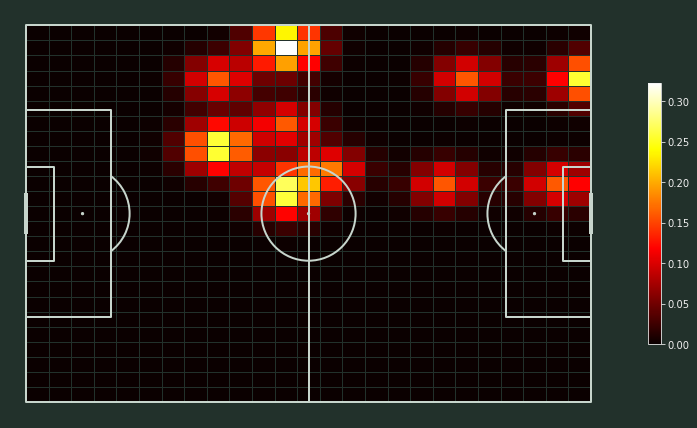

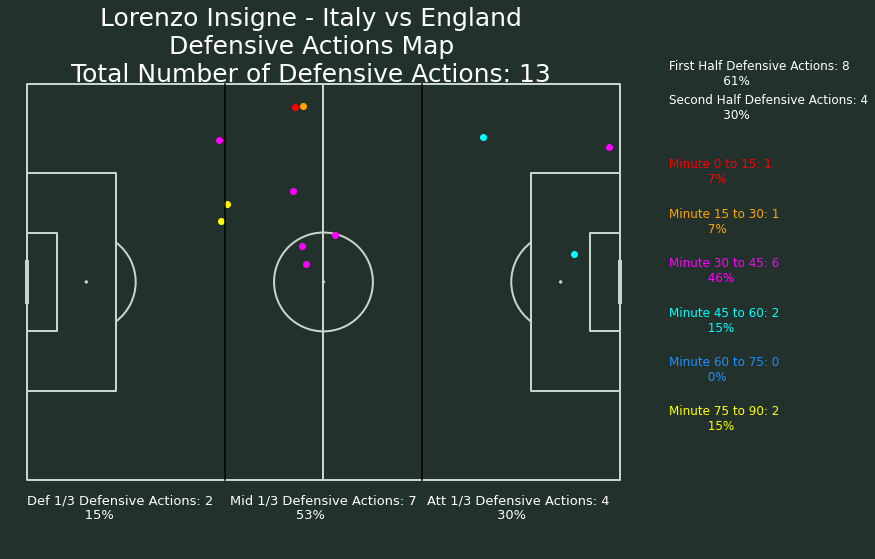

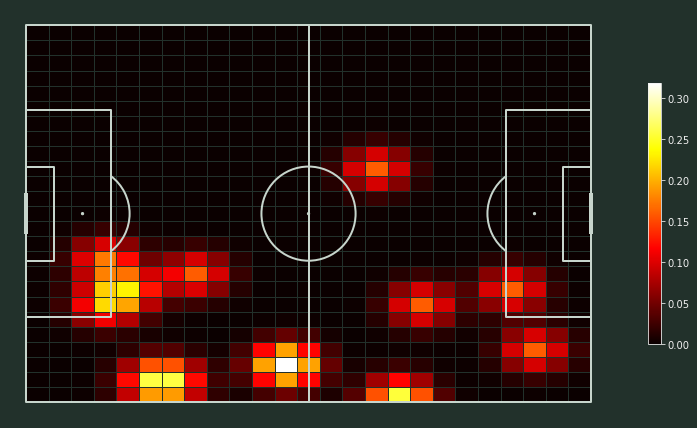

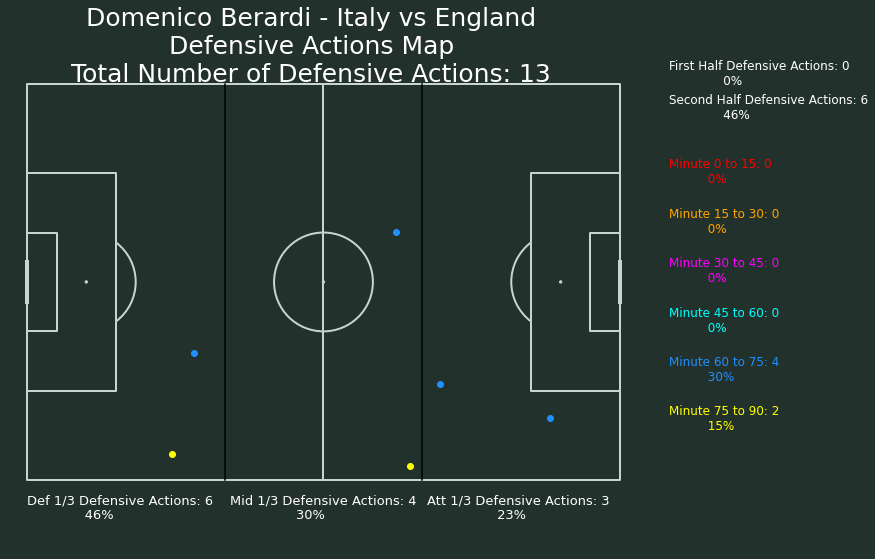

In [29]:
# Create by Italy player def actions vizz

# Italy - England
itaEngDf = getEvents(3795506)

defActionsVizz(itaEngDf, 'Italy')